In [33]:
from time import time
from datetime import datetime
import numpy as np
seq = 8
def multiply(A,B):
    return [a*b for a,b in zip(A,B)]
def divide(A,B):
    return [a/b for a,b in zip(A,B)]

def minus(A,B):
    return [a-b for a,b in zip(A,B)]
def log(txt):
    f= open("log%i.txt"%seq,"a+")
    f.write('%s: %s \r\n'%(datetime.now().strftime('{%Y-%m-%d %H:%M:%S}'),txt))
    print(txt)
    f.close() 
def initial_log():
    f= open("log%i.txt"%seq,"w+")
    f.write('%s: starting.... \r\n'%(datetime.now().strftime('{%Y-%m-%d %H:%M:%S}')))
    f.close() 
import pickle
def savedf():
    with open('df%i.dat'%seq,'wb') as f:
        pickle.dump((X_train, X_test, y_train, y_test),f)

def loaddf():
    global X_train, X_test, y_train, y_test
    with open('df%i.dat'%seq,'rb') as f:
        X_train, X_test, y_train, y_test = pickle.load(f)
    print("Shape of X_train:", len(X_train),len(X_train[0]))
    print("Shape of X_test:",len(X_test),len(X_test[0]))

        
def save():
    with open('data%i.dat'%seq,'wb') as f:
        pickle.dump((i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse),f)
def load():
    global i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse
    with open('data%i.dat'%seq,'rb') as f:
        i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse = pickle.load(f)

def load1():
    global i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse
    with open('data4.dat','rb') as f:
        i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse = pickle.load(f)
import os
os.environ["PATH"] += os.pathsep +"C:\\Users\\User\\Downloads\\graphviz-2.38\\release\\bin"


In [34]:
from numpy import var

class Splitter:
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y

    def split(self,index,value):
        """ 
        Split X and Y based on the given variable index and value
  
        Parameters: 
            index (int): index of variable to splitted on
            value (float): the value of splitting varaible
          
        Returns: 
            right_x,left_x,rigth_y,left_y
        """
        right_x = [x for x in self.X if x[index]>=value]
        left_x = [x for x in self.X if x[index]<value]
        
        right_y = [self.Y[i] for i,x in enumerate(self.X) if x[index]>=value]
        left_y = [self.Y[i] for i,x in enumerate(self.X) if x[index]<value]
        return right_x,left_x,right_y,left_y
    
    def weighted_var(self,Y):
        if len(Y) ==0:
            return float('inf')
        return var(Y)/len(Y)
    
    def SE(self,Y):
        if len(Y) ==0: return float('inf')
        mean = sum(Y)/len(Y)
        SE = sum([(y-mean)**2 for y in Y])
        return SE
        
    
    def splitting_cost(self,right_x,left_x,right_y,left_y):
        """ 
        Compute cost of spliting.
        in the current version, we have used varaince based cost function
  
        Parameters: 
            right_x,left_x,rigth_y,left_y
          
        Returns: 
            float: the cost of computing
        """        
        return (self.SE(right_y)+self.SE(left_y))/(len(right_y)+len(left_y))
    
    def possibleValues(self,index):
        values = [x[index] for x in self.X]
        values.sort()
        max_values = 100
        if len(values)<max_values:
            return values
        
        return set([np.percentile(values,i*100//max_values) for i in range(max_values)])
    
    def test_splitting(self,index,value):
        right_x,left_x,right_y,left_y = self.split(index,value)
        return  self.splitting_cost(right_x,left_x,right_y,left_y),len(right_y),len(left_y)
    
    def find_best_splitting(self,min_leaf_treshold=0,min_split=0):
        """ 
        Find best splitting and return index and value of splitting variable respectively
       
        Returns: 
            int,float: the index and value of best possible splitting variables
        """ 
        
        best_splitting = (self.SE(self.Y)/len(self.Y))
        best_splitting_index = -1
        best_splitting_value = 0
        if len(self.Y)<min_split:
            return best_splitting_index,best_splitting_value            
        for index in range(len(self.X[0])):
            for value in self.possibleValues(index):
                splitting_cost,left_cnt,right_cnt = self.test_splitting(index,value)
#               print('splitting at %f: cost->%f'%(value,splitting_cost))
                if splitting_cost < best_splitting and left_cnt >= min_leaf_treshold and right_cnt >= min_leaf_treshold:
                    best_splitting = splitting_cost
                    best_splitting_index = index
                    best_splitting_value = value
        return best_splitting_index,best_splitting_value


In [35]:
id = 0
last_leaf_no = 1
j = 0
def create_Tree():
    global last_leaf_no
    last_leaf_no = 1
    return Node(0)
class Node:
    isLeaf = True
    Left = None
    Right = None
    Value = None
    Depth = 0
    splitting_var_index = 0
    splitting_value = 0
    cnt = 0
    
    
    def __init__(self,depth):
        global id
        id+=1
        self.ID = id
        self.isLeaf = True
        self.Depth = depth
    def predict(self,X):
        return [self.predict_one(x).Value for x in X]
        
    def predict_one(self,X):
        if type(X) != list:
            raise TypeError("predict_one.X: expected list but recieved %s (%s)"%(X,type(X)))
        try:
            if self.isLeaf:
                self.cnt +=1
                return self
            if X[self.splitting_var_index] >= self.splitting_value:
                return self.Right.predict_one(X)
            else:
                return self.Left.predict_one(X)
        except IndexError:
            print('index: %i'%self.splitting_var_index)
            raise
    def get_leafs(self):
        if self.isLeaf:
            return [self]
        return self.Right.get_leafs()+self.Left.get_leafs()   
    
    def fit(self,X,Y,max_depth):
        global last_leaf_no

        #tree reached maximum depth
        if max_depth <= self.Depth:
            self.isLeaf = True
            self.leafID = last_leaf_no
            last_leaf_no+=1
            self.fit_leaf_value(Y)
            return 
        
        #continue splitting if more depth allowed
        splitter = Splitter(X,Y)
        best_splitting_index,best_splitting_value = splitter.find_best_splitting()
        if best_splitting_index == -1:
            #better to not split
            self.isLeaf = True
            self.leafID = last_leaf_no
            last_leaf_no+=1
            self.fit_leaf_value(Y)
        else:
            right_x,left_x,right_y,left_y = splitter.split(best_splitting_index,best_splitting_value)
            self.isLeaf = False
            self.splitting_var_index = best_splitting_index
            self.splitting_value = best_splitting_value
            self.Right = Node(self.Depth+1)
            self.Left = Node(self.Depth+1)
            self.Right.fit(right_x,right_y,max_depth)
            self.Left.fit(left_x,left_y,max_depth)
    def fit_leaf_value(self,Y):
        self.Value = sum(Y)/len(Y)

        
    def tune(self,X,R,T):
        #self.X = X
       # self.Y = ['%f:%f'%(r,t) for r,t in zip(R,T)]
        if len(X) != len(R):
            raise TypeError("tune function: X and R should be with same size. recieved <%i>.<%i>"%(len(X),len(R)))
        if len(X) != len(T):
            raise TypeError("tune function: X and T should be with same size. recieved <%i>.<%i>"%(len(X),len(T)))
            
        if self.isLeaf:
            if sum(multiply(T,T)) == 0:
                self.value = 1
            else:
                self.Value = sum(multiply(R,T))/sum(multiply(T,T))
            return
        
        splitter = Splitter(X,R)
        right_x,left_X,right_R,left_R = splitter.split(self.splitting_var_index,self.splitting_value)
        splitter = Splitter(X,T)
        right_x,left_X,right_T,left_T = splitter.split(self.splitting_var_index,self.splitting_value)
        self.Right.tune(right_x,right_R,right_T)
        self.Left.tune(left_X,left_R,left_T)
        
    def draw_tree(self):
        global j
        from graphviz import Source
        from io import BytesIO
        import time
        timestr = time.strftime("%Y%m%d-%H%M%S")
        from matplotlib import pyplot as plt
        from matplotlib import image
        g = Source('digraph {\n\tgraph [rankdir=UT]\n'+self.print_tree()+'}')
        g.render('round-table%i.gv'%j, view=True)
        j+=1
        #return img
        
    def get_leafcounts(self):
        if self.isLeaf:
            return 1
        return self.Left.get_leafcounts()+self.Right.get_leafcounts()
    
    def print_tree(self,prefix=''):
        '\t0 [label="f0<8.40779079e-45] yes=1,no=2,missing=1\n\t1:[f0<2.80259693e-45] yes=3,no=4,missing=3\n\t\t3:leaf=7.46349096\n\t\t4:leaf=-0.278686523\n\t2:[f0<8.40779079e-45] yes=5,no=6,missing=5\n\t\t5:leaf=-0\n\t\t6:leaf=-0.188493282\n'
        if not self.isLeaf:
            ret = '\t%i [label="f%i>=%f"]\n\t%i -> %i [label="yes" color="#0000FF"]\n\t %i -> %i [label=no color="#FF0000"]\n'%(
                self.ID,self.splitting_var_index,self.splitting_value,self.ID,self.Right.ID,self.ID,self.Left.ID)
            ret += self.Right.print_tree(prefix+'\t')
            ret += self.Left.print_tree(prefix+'\t')
            return ret
        else:
            return '\t%i [label="leaf=%f\nCount=%i"]\n'%(self.ID,self.Value,self.cnt)
    def get_leaf_values(self):
        if self.isLeaf:
            return [self.Value]
        return self.Right.get_leaf_values()+self.Left.get_leaf_values()
    
'''digraph {
	graph [rankdir=UT]
	0 [label="f0<8.40779079e-45"]
	0 -> 1 [label="yes, missing" color="#0000FF"]
	0 -> 2 [label=no color="#FF0000"]
	1 [label="f0<2.80259693e-45"]
	1 -> 3 [label="yes, missing" color="#0000FF"]
	1 -> 4 [label=no color="#FF0000"]
	3 [label="leaf=7.46349096"]
	4 [label="leaf=-0.278686523"]
	2 [label="f0<8.40779079e-45"]
	2 -> 5 [label="yes, missing" color="#0000FF"]
	2 -> 6 [label=no color="#FF0000"]
	5 [label="leaf=-0"]
	6 [label="leaf=-0.188493282"]
}'''       
        

'digraph {\n\tgraph [rankdir=UT]\n\t0 [label="f0<8.40779079e-45"]\n\t0 -> 1 [label="yes, missing" color="#0000FF"]\n\t0 -> 2 [label=no color="#FF0000"]\n\t1 [label="f0<2.80259693e-45"]\n\t1 -> 3 [label="yes, missing" color="#0000FF"]\n\t1 -> 4 [label=no color="#FF0000"]\n\t3 [label="leaf=7.46349096"]\n\t4 [label="leaf=-0.278686523"]\n\t2 [label="f0<8.40779079e-45"]\n\t2 -> 5 [label="yes, missing" color="#0000FF"]\n\t2 -> 6 [label=no color="#FF0000"]\n\t5 [label="leaf=-0"]\n\t6 [label="leaf=-0.188493282"]\n}'

In [36]:
    from copy import deepcopy
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    from scipy.sparse import csr_matrix
    from scipy import sparse
    import numpy as np
    from scipy.optimize import lsq_linear

    class FractBoosting:

        def __init__(self,learning_rate):
            self.learning_rate = learning_rate
            self.trees = []

        def predict(self,X,ignore_last=0):
            Y = []
            tree_filtered = self.trees[:max(1,len(self.trees)-ignore_last)]
            print('prediciting using %i trees'%len(tree_filtered))
            for x in X:
                predictions = [S.predict([x])[0]*T.predict([x])[0] for S,T in tree_filtered]
                predict = predictions[0] + self.learning_rate*sum(predictions[1:])
                Y.append(predict)

            return Y

        def fit(self,X,Y,max_depth,max_trees):
            """ 
            Fit the boosting trees on the given data

            Parameters: 
                X (list of list): the input X
                Y (list): input Y
                max_depth (int): maximum depth of trees
                max_trees (int): the number of trees
            """ 

            lastRMSE = self.rmse(X,Y)
            improvment = []
            for i in range(1,max_trees):
                t0 = time()
                depth = int(1+max_depth*sqrt(i/max_trees))
                log('starting itteration %i with depth %i'%(i,depth))
    #            print('itteration %i, begining, mean loss: %f, tree depth: %i'%(i,self.rmse(X,Y),depth))
                self.fit_one_step(X,Y,depth)

                current_rmse = self.rmse(X,Y)
                RMSEDif = lastRMSE - current_rmse
                lastRMSE = current_rmse
                cost = T.get_leafcounts()
                imp = cost/RMSEDif
                improvment.append(imp)
                log('itteration %i done in %0.3fs, RMSE: %f, Cost/improvement: %f'%(i,time() - t0,current_rmse,imp))
            return improvment
        def create_root_tree(self,Y):
            root_s = create_Tree()
            root_s.Value = 1
            root_t = create_Tree()
            root_t.fit_leaf_value(Y)
            self.trees = [(root_s,root_t)]

        def fit_one_step(self,X,Y,depth,backprop_level):
            Y_r = self.get_residual(X,Y)
            T = create_Tree()
            T.fit(X,Y_r,depth)
            Y_t = T.predict(X)
            S = deepcopy(self.trees[-1][1])
            S.tune(X,Y_r,Y_t)
            self.trees.append((S,T))
            self.back_prop(X,Y,backprop_level)
            
        def back_prop(self,X,Y,level):
            global A4
            #self.trees[-1][0].draw_tree()
            h = self.predict(X,level)
            R = np.array(minus(Y , h))
            tr = self.trees[max(1,len(self.trees)-level):]
            print('computing last %i trees of S [total trees: %i]'%(len(tr),len(self.trees)))
            i = 0
            S_nodes =[]
            s_values = []
            for s,_ in tr:
                for leaf in s.get_leafs():
                    leaf.leaf_index = i
                    i+=1
                    S_nodes.append(leaf)
                    s_values.append(leaf.Value)
            row = []
            col = []
            data =[]
            for i,x in enumerate(X):
                for s,t in tr:
                    s_leaf = s.predict_one(x)
                    t_leaf = t.predict_one(x)
                    row.append(i)
                    col.append(s_leaf.leaf_index)
                    data.append(t_leaf.Value)
            A = sparse.csr_matrix((data, (row, col)), shape=(len(X), len(S_nodes))) 
            ##U = A.transpose().dot(A).todense()
            #V = A.transpose().dot(R)
            #A4 = np.linalg.pinv(U,hermitian =True).dot(V)
            print(A4.shape)
            A4 = lsq_linear(A,R, bounds=(-0.01, .1)).x
            print("S Values before ",s_values)
            print('S Values after ',A4)
            #A4 = A4.todesne()
#            A1 = A.transpose().dot(A)
#            print(np.linalg.matrix_rank(A.todense()),np.linalg.matrix_rank(A1.todense()))
#            A2 = sparse.csr_matrix(inv(A1))
#            A3 = A.transpose().dot(R)
#            A4 = (A2.dot(A3)).todense()
            print('rmse before:',self.rmse(X,Y))
            r1 = self.get_residual(X,Y)
            for i,s1 in enumerate(S_nodes):
                s1.Value = A4[i]
            #self.trees[-1][0].draw_tree()
            print('rmse after:',self.rmse(X,Y))
            r2 = self.get_residual(X,Y)
            #print('Residual before ',r1)
            #print('Residual after ',r2)
            #print('diff ',minus(r1,r2))
            
        def get_residual(self,X,Y):
            h = self.predict(X)
            Y_r = minus(Y , h)
            return Y_r
        def print_trees(self):
            for i,(s,t) in enumerate(self.trees):
                print('%ith fractal tree\n'%i)
                print('-----------------\n')
                print('S:\n')
                s.print_tree()
                print('-----------------\n')
                print('T:\n')
                t.print_tree()
                print('\n-----------------\n')

        def rmse(self,X,Y):
            h = self.predict(X)
    #        R = minus(Y , h)
    #        print('Residual:',R)
            return sqrt(mean_squared_error(h, Y))


In [38]:
from numpy import std
import xgboost as xgb
from threading import Thread
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
max_depth=5

loaddf()
#initial_log()
mdl_1 = FractBoosting(1)
mdl_2 = FractBoosting(1)
mdl_3 = FractBoosting(1)
mdl_1.create_root_tree(y_train)
mdl_2.create_root_tree(y_train)
mdl_3.create_root_tree(y_train)
last_rmse = mdl_3.rmse(X_train,y_train)
last_depth = 1

m = sum(y_train)/len(y_train)
y_train_xgb = [y-m for y in y_train]

RMSETest = [[],[],[],[],[],[]]
RMSETrain =  [[],[],[],[],[],[]]
i=0
try:
    load()
    i
except Exception as e:
    print(e)
    initial_log()
try:
    while i<200:
        processes = []




        ################Fixed depth
        mdl_1.fit_one_step(X_train,y_train,max_depth,1)
        RMSETrain[0].append( mdl_1.rmse(X_train,y_train))
        RMSETest[0].append( mdl_1.rmse(X_test,y_test))    
        print('1 Back')


        
        ###############Linear depth
        #depth = min(5,int(1+max_depth*(i/50)))
        mdl_2.fit_one_step(X_train,y_train,max_depth,2)    
        RMSETrain[1].append( mdl_2.rmse(X_train,y_train))
        RMSETest[1].append( mdl_2.rmse(X_test,y_test))    
        print('2 Back')


        ###############dynamic depth
        mdl_3.fit_one_step(X_train,y_train,max_depth,3)
        #mdl3_rmse = mdl_3.rmse(X_test,y_test)
        RMSETrain[2].append( mdl_3.rmse(X_train,y_train))
        RMSETest[2].append( mdl_3.rmse(X_test,y_test))
        print('3 Back')
        


        ##################XGBoost
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 5,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        RMSETrain[3].append(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        RMSETest[3].append(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        print('XGB')
        
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 1,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        RMSETrain[4].append(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        RMSETest[4].append(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        
                
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 2,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        RMSETrain[5].append(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        RMSETest[5].append(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        
        print('XGB')
        i+=1
        
        save()
                           
        log('\r\n-----------------------------------------------\r\n'+
            'ittr %i \tTrain\t\tTest\t\tDiff\t\tRVar\tSVar\tTVar\r\n'%i+
            'FGB[%i]:\t%.2f\t\t%.2f\t\t%.2f\t\t%.1f\t%.1f\t\t%.1f\r\n'%(1,RMSETrain[0][-1],RMSETest[0][-1],RMSETest[0][-1]-RMSETrain[0][-1],std(mdl_1.get_residual(X_train,y_train)),std(mdl_1.trees[-1][0].get_leaf_values()),std(mdl_1.trees[-1][1].get_leaf_values()))+
            'FGB[%i]:\t%.2f\t\t%.2f\t\t%.2f\t\t%.1f\t%.1f\t\t%.1f\r\n'%(2,RMSETrain[1][-1],RMSETest[1][-1],RMSETest[1][-1]-RMSETrain[1][-1],std(mdl_2.get_residual(X_train,y_train)),std(mdl_2.trees[-1][0].get_leaf_values()),std(mdl_2.trees[-1][1].get_leaf_values()))+
            'FGB[%i]:\t%.2f\t\t%.2f\t\t%.2f\t\t%.1f\t%.1f\t\t%.1f\r\n'%(3,RMSETrain[2][-1],RMSETest[2][-1],RMSETest[2][-1]-RMSETrain[2][-1],std(mdl_3.get_residual(X_train,y_train)),std(mdl_3.trees[-1][0].get_leaf_values()),std(mdl_3.trees[-1][1].get_leaf_values()))+
            'XGB[%i]:\t%.2f\t\t%.2f\t\t%.2f \r\n'%(1,RMSETrain[5][-1],RMSETest[5][-1],RMSETest[5][-1]-RMSETrain[5][-1])+
            'XGB[%i]:\t%.2f\t\t%.2f\t\t%.2f \r\n'%(2,RMSETrain[4][-1],RMSETest[4][-1],RMSETest[4][-1]-RMSETrain[4][-1])+
            'XGB[%i]:\t%.2f\t\t%.2f\t\t%.2f \r\n'%(max_depth,RMSETrain[3][-1],RMSETest[3][-1],RMSETest[3][-1]-RMSETrain[3][-1]))

        if (last_rmse/mdl3_rmse)<1.005 and last_depth < max_depth:
            last_depth +=1
        last_rmse = mdl3_rmse

except Exception as e:
    log(e)
    raise


Shape of X_train: 22865 9
Shape of X_test: 22865 9
prediciting using 1 trees
[Errno 2] No such file or directory: 'data8.dat'
prediciting using 1 trees
prediciting using 1 trees
computing last 1 trees of S [total trees: 2]
(1, 94)
S Values before  [0.9999999999998568]
S Values after  [0.1]
prediciting using 2 trees
rmse before: 5.1156787427214105
prediciting using 2 trees
prediciting using 2 trees
rmse after: 5.940252236303511
prediciting using 2 trees
prediciting using 2 trees
prediciting using 2 trees
1 Back
prediciting using 1 trees
prediciting using 1 trees
computing last 1 trees of S [total trees: 2]
(1,)
S Values before  [0.9999999999998568]
S Values after  [0.1]
prediciting using 2 trees
rmse before: 5.1156787427214105
prediciting using 2 trees
prediciting using 2 trees
rmse after: 5.940252236303511
prediciting using 2 trees
prediciting using 2 trees
prediciting using 2 trees
2 Back
prediciting using 1 trees
prediciting using 1 trees
computing last 1 trees of S [total trees: 2]


rmse before: 5.003570704684155
prediciting using 4 trees
prediciting using 4 trees
rmse after: 5.653060272948656
prediciting using 4 trees
prediciting using 4 trees
prediciting using 4 trees
2 Back
prediciting using 3 trees
prediciting using 1 trees
computing last 3 trees of S [total trees: 4]
(64,)
S Values before  [0.09999999988895991, 0.09999999986487465, 0.09999999999669551, -0.00999999992946427, 0.09999999987274118, 0.09999999985934518, 0.09999999988474517, 0.09999999990373609, 0.09999999999517986, 0.09999999999999999, -0.00999999587064239, 0.09999999999999999, 0.0999999998811497, 0.0999999999962532, 0.09999999971505362, 0.09999999988583654, 0.09999999983325497, 0.0999999998703452, 0.09999999984687244, 0.09999999987001235, 0.0999999999996612, 0.09999999987583282, 0.09999999986285368, 0.09999999972492508, 0.099999999977267, 0.09999999997536135, 0.09999999986922525, 0.09999999937499296, 0.09999999999967361, 0.0999999999512976, 0.0999999998566396, 0.09999999999999999, 0.0999999998749

rmse before: 4.966183444657305
prediciting using 5 trees
prediciting using 5 trees
rmse after: 5.535937018213322
prediciting using 5 trees
prediciting using 5 trees
prediciting using 5 trees
3 Back
[11:38:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[11:38:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 5 trees
prediciting using 5 trees
prediciting using 5 trees

-----------------------------------------------
ittr 4 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	5.54		5.57		0.04		5.5	0.0		3.1
FGB[2]:	5.54		5.57		0.04		5.5	0.0		3.1
FGB[3]:	5.54		5.57		0.04		5.5	0.0		3.1
XGB[1]:	5.88		5.

XGB
prediciting using 6 trees
prediciting using 6 trees
prediciting using 6 trees

-----------------------------------------------
ittr 5 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	5.44		5.48		0.05		5.4	0.0		2.9
FGB[2]:	5.44		5.48		0.05		5.4	0.0		2.9
FGB[3]:	5.44		5.48		0.05		5.4	0.0		2.9
XGB[1]:	5.82		5.83		0.01 
XGB[2]:	5.92		5.92		0.01 
XGB[5]:	5.54		5.58		0.04 

prediciting using 6 trees
prediciting using 6 trees
computing last 1 trees of S [total trees: 7]
(96,)
S Values before  [1.1211934881478032, 1.1703396242304676, 0.6034498867627067, 1.0851527495062998, 0.6645948515585511, -0.27348477780182445, 0.42743636219292525, 0.8198969553212004, -0.13550479870341578, 0.4868429540039848, 0.39626047672261056, 0.8376502545552906, 0.6564490109959855, 1.1482613348027477, 0.6480600201442868, 0.9826212037819915, 0.8858535629014702, 1.0602854011401637, 0.9035509074929735, 0.993657743042406, 1.087042461246066, 1.129575284441896, -1.7618836604585364, 0.16372733553180052, 2.05009585501935, 2.49822

rmse before: 4.881155263247914
prediciting using 8 trees
prediciting using 8 trees
rmse after: 5.264761535874464
prediciting using 8 trees
prediciting using 8 trees
prediciting using 8 trees
1 Back
prediciting using 7 trees
prediciting using 6 trees
computing last 2 trees of S [total trees: 8]
(32,)
S Values before  [0.09999999999999959, 0.09999999999999823, 0.09999999999999996, 0.09999999999999754, 0.09999999999999941, -0.009999999999988619, 0.09999999999999329, 0.09999999999999985, -0.00999999981609215, 0.09999999999850497, 0.09999999999718581, 0.0999999999999997, 0.09999999999999944, 0.09999999999996517, 0.0999999999999996, 0.09999999999999956, 0.09999999999999687, 0.09999999999999455, 0.09999999999999973, 0.09999999999999894, 0.09999999999999877, 0.0999999999999626, -0.009999999999983867, 0.09999999999999999, 0.09999999999999157, 0.09999999999999958, 0.09999999999995968, 0.09999999999999794, -0.0099999999999126, 0.09999999999999316, 0.09999999997137829, 0.0999999999998519, 1.177582

rmse before: 4.840761541967923
prediciting using 9 trees
prediciting using 9 trees
rmse after: 5.191399286135847
prediciting using 9 trees
prediciting using 9 trees
prediciting using 9 trees
2 Back
prediciting using 8 trees
prediciting using 6 trees
computing last 3 trees of S [total trees: 9]
(64,)
S Values before  [0.09999999999997039, 0.09999999999910346, 0.09999999999910032, 0.09999999999909331, 0.09999999999688762, -0.009999999999999998, 0.09999999999999969, 0.09999999999961527, -0.009999999979345552, 0.09999999999340667, 0.0999999999999669, 0.09999999999999616, 0.09999999999999107, 0.09999999999975479, 0.09999999999882464, 0.09999999999999704, 0.09999999999953078, 0.09999999999918972, 0.09999999999999783, 0.09999999999954902, 0.09999999999957818, 0.09999999999997876, -0.009999999999847665, 0.09999999999211433, 0.09999999999990371, 0.09999999999999644, 0.09999999999966486, 0.099999999999747, -0.009999999999982053, 0.09999999999926602, 0.09999999993200714, 0.0999999999995159, 0.099

rmse before: 4.803784742389929
prediciting using 10 trees
prediciting using 10 trees
rmse after: 5.123698960626666
prediciting using 10 trees
prediciting using 10 trees
prediciting using 10 trees
3 Back
[12:08:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[12:08:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 10 trees
prediciting using 10 trees
prediciting using 10 trees

-----------------------------------------------
ittr 9 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	5.12		5.20		0.07		5.1	0.0		2.5
FGB[2]:	5.12		5.20		0.07		5.1	0.0		2.5
FGB[3]:	5.12		5.20		0.07		5.1	0.0		2.5
XGB[1]:	

computing last 1 trees of S [total trees: 12]
(96,)
S Values before  [1.6558159556645797, -0.06556423204892012, -2.023200298876563, 3.9981866681803755, 1.2733845960357133, 1.4657042557739772, -4.424861841446107, 0.9011697651526069, 0.8487363588928188, 0.6462511594332727, 1.3445301016806903, 1.594931154428051, 1.2378725789670282, 1.4790507556546881, 0.9883623567917246, 0.9249595017840769, 2.4832989363250033, 1.089200242571188, 0.672871440046979, 0.7429468625604487, 1.0023225906712032, 1.233454376126163, -3.9451923751335727, 0.8918482953120221, 1.1074518324895806, 1.9048027683214757, 0.11307823869398405, 1.2524927292514434, 0.947931307587296, 0.8053285918680791, 1.5321796622191284, 0.8992544127275577]
S Values after  [ 0.1        -0.01       -0.01        0.1         0.1         0.1
 -0.01        0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.1         0.1        -0.01        0.1
  0.1      

rmse before: 4.7324085380267125
prediciting using 13 trees
prediciting using 13 trees
rmse after: 4.9579983628277455
prediciting using 13 trees
prediciting using 13 trees
prediciting using 13 trees
1 Back
prediciting using 12 trees
prediciting using 11 trees
computing last 2 trees of S [total trees: 13]
(32,)
S Values before  [0.09999999999999999, -0.009999999996757934, -0.009999999999999998, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, -0.009999999999999998, 0.09999999999999999, 0.09999999999999999, 0.09999999999999998, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, -0.009999999999999998, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999267431181, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.0999999999

(32,)
S Values before  [0.09999999995217998, 0.09999999999991377, 0.09999999494196413, 0.09999999999989717, 0.09999999999952938, -0.009999999997082629, 0.09999999995878942, -0.009999999999999978, 0.09999999999811865, 0.09999999992586202, 0.09999999993319435, 0.09999999999876667, 0.09999999999937632, 0.09999999997888187, 0.09999999991017322, 0.09999999808950467, 0.09999999989221842, 0.09999999999959683, 0.09999999996018961, 0.09999999999996668, 0.09999999999991763, 0.09999999997912704, 0.09999999994577446, 0.09999999997853622, 0.09999999999994091, 0.09999999999996466, 0.09999999999999395, 0.09999999999999963, 0.09999999997890635, 0.09999999999941284, 0.09999999999999983, 0.0999999999667807, 0.939946679861767, 3.174233021706822, 0.17655155049318982, 1.2471989733145632, 0.8559061302592073, 0.9430013046956118, 1.3422047205726089, 1.2271490126579783, -0.8798868679921021, 0.877866650872793, 1.3897536838985918, 1.028779568879489, 1.1678752040297384, 1.0733695949957764, 0.6756286851501369, 0.9

rmse before: 4.642889063978029
prediciting using 15 trees
prediciting using 15 trees
rmse after: 4.866041426186027
prediciting using 15 trees
prediciting using 15 trees
prediciting using 15 trees
2 Back
prediciting using 14 trees
prediciting using 12 trees
computing last 3 trees of S [total trees: 15]
(64,)
S Values before  [0.09999999999941425, 0.09999999999934993, 0.09999999999913409, 0.099999999999092, 0.09999999999996165, -0.009999999999810225, 0.09999999999699732, -0.009999999999999998, 0.09999999999998375, 0.09999999999999167, 0.09999999999956645, 0.09999999999999495, 0.09999999999980691, 0.09999999999979702, 0.09999999999999905, 0.0999999995393467, 0.09999999982775366, 0.09999999999998774, 0.09999999999999568, 0.0999999999999992, 0.09999999999915259, 0.09999999999895363, 0.09999999999997553, 0.09999999999999898, 0.09999999999999833, 0.09999999999999873, 0.09999999999944627, 0.0999999999999493, 0.09999999999983647, 0.09999999999999999, 0.0999999999999991, 0.09999999999999808, 0.0

rmse before: 4.642179435181043
prediciting using 16 trees
prediciting using 16 trees
rmse after: 4.832787790700536
prediciting using 16 trees
prediciting using 16 trees
prediciting using 16 trees
3 Back
[12:48:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[12:48:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:48:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 16 trees
prediciting using 16 trees
prediciting using 16 trees

-----------------------------------------------
ittr 15 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.83		4.95		0.11		4.8	0.0		2.7
FGB[2]:	4.83		4.95		0.11		4.8	0.0		2.7
FGB[3]:	4.83		4.95		0.12		4.8	0.0		2.7
XGB[1]:

prediciting using 17 trees
prediciting using 17 trees
3 Back
[12:54:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[12:55:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:55:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 17 trees
prediciting using 17 trees
prediciting using 17 trees

-----------------------------------------------
ittr 16 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.80		4.92		0.12		4.8	0.0		3.0
FGB[2]:	4.79		4.92		0.12		4.8	0.0		3.0
FGB[3]:	4.79		4.92		0.12		4.8	0.0		3.0
XGB[1]:	5.47		5.50		0.02 
XGB[2]:	5.69		5.70		0.01 
XGB[5]:	4.81		4.94		0.12 

prediciting using 17 trees
prediciting using 17 trees
computing last 1

XGB
[13:01:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 18 trees
prediciting using 18 trees
prediciting using 18 trees

-----------------------------------------------
ittr 17 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.76		4.89		0.13		4.8	0.0		2.5
FGB[2]:	4.76		4.89		0.13		4.8	0.0		2.5
FGB[3]:	4.76		4.89		0.13		4.8	0.0		2.5
XGB[1]:	5.45		5.48		0.02 
XGB[2]:	5.68		5.69		0.02 
XGB[5]:	4.78		4.91		0.13 

prediciting using 18 trees
prediciting using 18 trees
computing last 1 trees of S [total trees: 19]
(96,)
S Values before  [2.1332404502596503, 0.16219870085289623, 0.9256369126275381, 0.5901345011039962, -1.7722186516768699, 1.0292009169206824, 0.5228698480833094, 1.4605933893772745, 0.5534712

prediciting using 19 trees
computing last 1 trees of S [total trees: 20]
(96,)
S Values before  [1.1814763637753645, 0.4029794807645606, 1.0225786338096603, 0.8064347326650463, -1.2687459444974083, -3.943833532287006, 1.2801321966383263, 2.2237992254346914, 2.471618468940728, -1.8520030013665871, 1.0291158402711862, -3.66823340616635, 1.656300974328707, 1.5939987387493906, 2.4601586354386726, 0.497851427277098, 0.8794908632460031, -9.96781671614142, 2.165318392494021, 1.1410013344589522, -20.535332565953127, -272.6750963519051, 0.3858407886689187, -0.9595205735819856, 46.10438220615651, -2.554626164745758, -1.031009906528976, 0.8025961977266833, 0.9775846133099939, 0.9131481388694082, 1.1874042400632876, 4.109309301328582]
S Values after  [ 0.1         0.1         0.1         0.1        -0.01       -0.01
  0.1         0.1         0.1        -0.01        0.1        -0.01
  0.1         0.1         0.1         0.09999999  0.1        -0.01
  0.1         0.1        -0.01       -0.00999872  

rmse before: 4.537720362236043
prediciting using 21 trees
prediciting using 21 trees
rmse after: 4.680048781637212
prediciting using 21 trees
prediciting using 21 trees
prediciting using 21 trees
1 Back
prediciting using 20 trees
prediciting using 19 trees
computing last 2 trees of S [total trees: 21]
(32,)
S Values before  [0.09999999997722586, 0.09999999999187226, 0.09999999999042002, 0.09999999928888258, -0.009999998406496992, -0.009999999360282404, 0.09999999899125335, 0.09999999994956076, 0.09999999963441074, -0.009999999927246633, 0.09999999990679657, -0.009999999473467512, 0.0999999999415802, 0.09999999987904601, 0.09999999912579073, 0.09999999998398812, 0.09999999913908675, -0.009999999925575749, 0.09999999999376945, 0.09999999954437302, -0.009999999999982679, -0.009999837510286127, 0.09999999585762352, -0.00999999998829082, 0.09999999999999999, -0.009999999380062873, -0.009999999501189655, 0.09999999924588582, 0.09999999953878719, 0.09999999999418117, 0.09999999999336458, 0.09

(32,)
S Values before  [0.09999999992013968, -0.009999999804184576, 0.09999999992218332, 0.09999999996656778, 0.09999999992649594, 0.09999999931929623, 0.09999999559540103, 0.09999999905247667, 0.0999999999495135, 0.099999999923814, 0.09999999695930714, 0.09999999891959778, 0.09999999889840644, 0.0999999999476347, 0.0999999996381643, 0.09999999918580507, 0.09999999870356562, 0.09999999996426617, 0.0999999992401832, 0.09999999910739148, 0.09999999992700503, 0.09999999996270294, 0.09999999999999999, -0.009999999967598292, 0.09999999996471656, 0.09999999996461441, 0.09999999997299935, 0.0999999993594369, 0.09999999996601361, 0.09999999932836677, 0.09999999999999999, 0.09999999943681148, 2.437213537361506, 1.1484796144206548, -23.033593620080214, 0.26131944437194354, -1.942957997867359, 0.5249015925313633, 0.794718052369053, 0.9559241694029189, 0.9520988126472744, 1.1161295793987926, 2.6199968773599727, 0.668944390890969, 0.48532080464211336, 1.2021545908833435, 1.5419547389380721, 1.01463

rmse before: 4.477329880828061
prediciting using 23 trees
prediciting using 23 trees
rmse after: 4.625538540561982
prediciting using 23 trees
prediciting using 23 trees
prediciting using 23 trees
2 Back
prediciting using 22 trees
prediciting using 20 trees
computing last 3 trees of S [total trees: 23]
(64,)
S Values before  [0.09999999999149108, -0.009999999829630726, 0.09999999983663921, 0.09999999984769946, 0.09999999971201964, 0.09999999986968042, 0.09999999999118293, 0.09999999977137523, 0.09999999998545944, 0.09999999982101516, 0.09999999999010432, 0.09999999999183833, 0.099999999988828, 0.09999999998762493, 0.09999999985964762, 0.09999999999213655, 0.09999999998993427, 0.09999999999026747, 0.0999999998135001, 0.09999999979588817, 0.09999999998645401, 0.09999999999176792, 0.09999999999999999, -0.009999999877856715, 0.09999999983086454, 0.09999999998906384, 0.09999999998780934, 0.09999999968571549, 0.099999999809745, 0.09999999999304204, 0.09999999674910486, 0.09999999988143879, 0.

prediciting using 24 trees
prediciting using 24 trees
2 Back
prediciting using 23 trees
prediciting using 21 trees
computing last 3 trees of S [total trees: 24]
(64,)
S Values before  [0.09999999999639789, 0.09999999966644633, -0.009999999999999998, 0.09999999999999999, -0.009999999967492661, 0.09999999934890502, 0.09999999998658207, 0.09999999999120164, 0.09999999968518672, 0.09999999980577821, 0.09999999999477034, 0.09999999918684999, 0.09999999683816387, 0.09999999995273127, 0.09999999998956942, 0.09999999964811838, 0.09999999979219497, 0.09999999972264796, 0.09999999995655695, 0.09999999972196268, 0.09999999949835588, 0.09999999998946855, 0.09999999999341436, 0.09999999999299386, 0.09999999961745959, 0.09999999999999999, 0.09999999832804682, 0.09999999999215128, 0.0999999969706834, 0.09999999989776039, -0.009999999986717583, 0.09999999971793931, 0.09988170384124495, -0.009999997534442612, -0.00999999973086556, 0.09999999999327834, 0.09999999965430734, -0.00999999999797893, 0.099999

(64,)
S Values before  [0.09999961330496927, -0.00999999897340607, -0.00999999995656895, 0.09999999944687663, 0.09999999872138463, -0.009999999934180718, 0.09999999997154006, 0.09999999680211397, 0.0999999999799782, -0.009999999882046648, -0.009999999963254895, 0.0999999999585577, -0.009999997641597543, 0.09999999853585828, 0.09999999994185028, 0.09999999995283619, 0.09999999999252542, 0.09999999993461628, 0.09999999997159417, -0.00999999999331969, 0.09999999965094192, 0.09999999995654228, 0.09999999997854646, 0.09999999999734212, 0.09999999995603022, 0.09999999949073896, 0.09999999991071956, 0.09999999998319482, 0.09999999993056066, -0.009999999995115836, 0.09999999867389703, 0.09999999988472229, 0.09999999990813702, 0.09999999996943074, 0.09999999996939118, 0.09999999921696762, 0.09999999895899027, 0.09999999993915604, -0.00999999996518169, 0.09999999997422747, 0.09999999867914719, 0.09999999999990254, 0.09999999902681259, -0.009999996815070796, 0.09999999905924106, 0.099999999285362

rmse before: 4.464133498536862
prediciting using 26 trees
prediciting using 26 trees
rmse after: 4.562700355621554
prediciting using 26 trees
prediciting using 26 trees
prediciting using 26 trees
3 Back
[13:57:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[13:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 26 trees
prediciting using 26 trees
prediciting using 26 trees

-----------------------------------------------
ittr 25 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.56		4.73		0.17		4.6	0.0		2.4
FGB[2]:	4.56		4.73		0.17		4.6	0.0		3.6
FGB[3]:	4.56		4.73		0.17		4.6	0.0		3.5
XGB[1]:

XGB
[14:05:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 27 trees
prediciting using 27 trees
prediciting using 27 trees

-----------------------------------------------
ittr 26 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.53		4.71		0.17		4.5	0.0		3.4
FGB[2]:	4.53		4.71		0.18		4.5	0.1		3.6
FGB[3]:	4.54		4.71		0.17		4.5	0.0		2.4
XGB[1]:	5.31		5.35		0.04 
XGB[2]:	5.60		5.61		0.02 
XGB[5]:	4.55		4.73		0.18 

prediciting using 27 trees
prediciting using 27 trees
computing last 1 trees of S [total trees: 28]
(95,)
S Values before  [1.228531451877317, -0.9511825996081623, 0.7702205707381602, 4.3748821546103445, 0.42911335504510767, 1.2470680149212876, 1.3186889802372206, 0.6607225329157279, 0.97942376

prediciting using 28 trees
computing last 1 trees of S [total trees: 29]
(95,)
S Values before  [1.0200548719595215, 0.8941313577344607, 1.1206152659714075, 1.7510695350706262, 0.6704469390466021, 2.9037641652260437, 0.9968694243506269, 1.1781747288961029, 0.9363690978130358, 2.266558426601485, 2.1392705052147947, 1.5506169584478482, 1.2407436633947582, 0.19214787330714578, 1.5447063869192335, 0.9096477049680783, 0.13470927029519555, 0.08605322749122807, 1.1831532969059355, 0.7709870265682361, -5.0756920039044235, 2.0080697533162017, 1.2128207438737015, 0.9487204809458492, 0.7701735991581732, 0.9413939007156006, 1.1696184943134968, 0.9558701658197495, 1.1329836764753594, -1.2645066661730404, 0.20781111486561196, -5.145433459981568]
S Values after  [ 0.1         0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.1         0.1         0.09998655  0.08601052
  0.1         0.09999999 -0.00999999 

rmse before: 4.341806742022428
prediciting using 30 trees
prediciting using 30 trees
rmse after: 4.465124095572962
prediciting using 30 trees
prediciting using 30 trees
prediciting using 30 trees
1 Back
prediciting using 29 trees
prediciting using 28 trees
computing last 2 trees of S [total trees: 30]
(32,)
S Values before  [-0.0099999999993973, 0.09999999999983718, -0.009999999999832563, 0.09999999999917318, -0.009999999999999998, -0.009999999891615007, 0.09999999999954672, -0.009999999973486466, 0.09999999997444209, 0.09999999999942405, 0.09999999999914976, 0.09999999995582723, -0.009999999999999998, 0.09999999961745881, -0.009999999999999998, 0.09999999996045382, 0.09999999998763402, 0.0999999999538177, 0.0999999999992163, 0.09999999996695659, 0.0999999999974491, 0.09999999996993378, 0.09999999999953546, -0.009999999937788117, 0.09999997846963475, 0.09999999999780533, 0.09999999995165151, 0.09999999999890119, 0.09999999989263991, 0.09999999998108895, 0.09999999999977763, 0.099999999

prediciting using 31 trees
prediciting using 31 trees
1 Back
prediciting using 30 trees
prediciting using 29 trees
computing last 2 trees of S [total trees: 31]
(32,)
S Values before  [0.0999999999963579, 0.09999999984266969, 0.0999999999990042, 0.09999999995441863, 0.09999999999971416, 0.0999999999790539, 0.09999999894602091, 0.0999999970740874, 0.09999999965536925, -0.009999999815842065, 0.09999999994591276, 0.09999999984873759, 0.09999999933314352, 0.09999999935424796, 0.0999999999827672, 0.09999999939767572, 0.09999999999622664, 0.09999999999997497, -0.009999999845867033, 0.09999999999789569, 0.09999999999999999, 0.09999999991930243, -0.009999999999999998, 0.09999999803090188, 0.09999999999736633, 0.09999999999704855, 0.099999999904811, 0.09999999783365435, -0.009999999963619154, 0.09999999999265771, 0.09999998526606495, 0.09999999924273027, 0.9773742722238861, 0.9605177594338682, 0.9708567315313066, 0.9609699656034003, 1.1677266222705762, 1.2740287693629766, 2.140672223391347, 0.6

prediciting using 30 trees
computing last 2 trees of S [total trees: 32]
(32,)
S Values before  [0.09999999983914729, 0.09999999999778594, 0.09999999977115226, 0.09999999960956195, 0.09999999988719033, 0.09999999999783268, 0.0999999999093935, 0.0999999997649527, -0.009999999956831769, -0.009999999999995174, 0.09999999999435641, 0.0999999999952463, 0.09999999966384678, 0.0999999998414138, 0.0999999998257252, 0.09999999999034599, 0.09999999970394036, 0.09999999983034036, -0.009999999999999988, 0.09999999996555681, -0.009999967900583115, 0.09999999999730588, 0.09999999999436548, -0.009999999998898796, 0.09999999986956332, 0.09999999999783193, 0.09999999982227883, 0.09999999983530576, 0.09999999999972298, 0.09999999981571785, -0.009999999620742103, 0.09999999976788615, 44.34223183820893, 1.4144127433439475, -27.554548935633758, 23.827694094905414, 0.4786683374002246, 0.7029584905989238, 1.0438828477682274, 0.3978311081102004, -1.2839686853224603, 0.7221293740556657, 4.7405900816992546, -1.

rmse before: 4.331107204778095
prediciting using 33 trees
prediciting using 33 trees
rmse after: 4.417932091585571
prediciting using 33 trees
prediciting using 33 trees
prediciting using 33 trees
2 Back
prediciting using 32 trees
prediciting using 30 trees
computing last 3 trees of S [total trees: 33]
(60,)
S Values before  [0.09999999997883505, 0.0999999999750177, 0.09999999771767037, 0.09999999469473732, 0.09999999770914295, 0.09999999772148763, 0.09999998981771302, 0.099999997234998, 0.09999999983740374, 0.09999999990312623, -0.009999795343934786, -0.009999998413670361, 0.09999999986504607, -0.00999999524491193, 0.09999999662425683, 0.09999999537931067, 0.09999999984756444, 0.09999999824476649, 0.09999999995829563, 0.09999999980829913, -0.009999951676927374, 0.09999949665254235, -0.007026321608798533, -0.009999999997790257, 0.09999999994013772, -0.009999999806525196, 0.09999999962584696, 0.09999999720606091, -0.009999991733180622, 0.02759265903839594, -0.009999999421871271, 0.099999

computing last 3 trees of S [total trees: 34]
(60,)
S Values before  [-0.009999999792886361, 0.09999999999200847, 0.09999999980790462, -0.00999999976732039, -0.009999999938904845, 0.09999999977702373, -0.009999999981436108, -0.009999999981774204, -0.009999999999999998, -0.009999999964614661, 0.09999999979491063, -0.009999999999692017, 0.0999999999846063, 0.09999999998435691, -0.009999999982307637, 0.09999999982703442, 0.09999999975755722, 0.09999999937733894, 0.0999999999805662, 0.09999999974254425, -0.009999999864186739, -0.00999999998904233, 0.09999999994134257, -0.009999999992256208, 0.09999999728900505, 0.09999999998994645, 0.09999999998988134, 0.09999999974929527, 0.09999999998684195, 0.09999999998213982, 0.09999999998605703, 0.09999999980047816, 0.09999999967219592, 0.09999999997834437, 0.09999999999236982, 0.09999999982090721, 0.09999999976481967, 0.09999999995048951, -0.009999995719516156, 0.09999999999999999, -0.009999999999997875, -0.009999999986918215, 0.09999999975627627, 0

rmse before: 4.287927027959117
prediciting using 35 trees
prediciting using 35 trees
rmse after: 4.377772722036869
prediciting using 35 trees
prediciting using 35 trees
prediciting using 35 trees
3 Back
[15:05:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[15:05:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 35 trees
prediciting using 35 trees
prediciting using 35 trees

-----------------------------------------------
ittr 34 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.40		4.61		0.21		4.4	0.0		3.6
FGB[2]:	4.39		4.61		0.21		4.4	0.0		3.2
FGB[3]:	4.38		4.59		0.22		4.4	0.0		3.2
XGB[1]:

XGB
prediciting using 36 trees
prediciting using 36 trees
prediciting using 36 trees

-----------------------------------------------
ittr 35 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.39		4.60		0.21		4.4	0.1		5.5
FGB[2]:	4.39		4.60		0.22		4.4	0.0		3.5
FGB[3]:	4.36		4.58		0.22		4.4	0.1		3.0
XGB[1]:	5.20		5.25		0.05 
XGB[2]:	5.54		5.56		0.02 
XGB[5]:	4.40		4.61		0.22 

prediciting using 36 trees
prediciting using 36 trees
computing last 1 trees of S [total trees: 37]
(96,)
S Values before  [28.21114797748044, 9.623873262475383, -84.10997750619416, 8.252657695916648, -45.7343075882058, -59.24487090955138, 4.127042487351403, -32.31692399965169, -7.640759848896574, -33.639429933888, -48.38838999432692, -0.9609094333260195, -36.44278690294742, 6.428650367384087, 0.16843481954702996, 0.8402502091418537, -3.303505451313972, 1.06764000426686, 1.0022354061553613, -62.455000528162536, 18.582759121687012, 6.137629175583661, -39.814888714869994, -5.897392231101858, -9.135097711896814, -32.716619

prediciting using 37 trees
computing last 1 trees of S [total trees: 38]
(96,)
S Values before  [0.9659947267868424, 1.2611979556681878, 60.656739059432, 6.483420749680715, -5.556443617188046, 79.31956741646778, 0.8944165525945523, 5.2425035284412695, -1.3482400742754013, 2.3268511535696907, 4.2991066950050865, -15.832959965107777, 0.8580731094331334, -0.13203567691113657, 2.4461588674715777, -2.660355171758385, 2.722950856372458, 35.894246557923715, -161.35434436757438, -12.694266638690069, 59.195244377064505, -27.518571203415387, -29.092565004416375, 17.050117848378417, -40.23327105163487, 21.169225966837452, -29.156869386245305, 8.641103526054003, -23.215826841030704, -121.23664763969222, 56.32412327900847, -87.98125654730148]
S Values after  [ 0.1   0.1   0.1   0.1  -0.01  0.1   0.1   0.1  -0.01  0.1   0.1  -0.01
  0.1  -0.01  0.1  -0.01  0.1   0.1  -0.01 -0.01  0.1  -0.01 -0.01  0.1
 -0.01  0.1  -0.01  0.1  -0.01 -0.01  0.1  -0.01]
prediciting using 38 trees
rmse before: 4.2635472

rmse before: 4.297009070006132
prediciting using 39 trees
prediciting using 39 trees
rmse after: 4.351659134493254
prediciting using 39 trees
prediciting using 39 trees
prediciting using 39 trees
1 Back
prediciting using 38 trees
prediciting using 37 trees
computing last 2 trees of S [total trees: 39]
(32,)
S Values before  [0.09999999999999992, 0.09999999998332215, 0.09999999999938189, 0.09999999998123925, 0.0999999999993701, 0.09999999999932294, 0.09999999999937995, 0.09999999998390925, 0.09999999999952147, 0.09999999998207755, 0.09999999997321997, 0.0999999999593386, 0.09999999998785694, 0.09999999999934005, 0.099999999980571, 0.09999999999939022, -0.00999998031351202, 0.09999999995444088, 0.09999999998664963, 0.09999999999684621, 0.099999999994367, 0.09999999999999978, -0.009999999995632383, 0.0999999999873475, 0.09999999998270596, 0.09999999999437131, 0.09999999997903253, 0.09999999989987962, 0.09999999999932285, 1.0541288493203298, 0.21844712273859568, -7.06975455811775, 21.51734

rmse before: 4.247499840998781
prediciting using 40 trees
prediciting using 40 trees
rmse after: 4.333605313648948
prediciting using 40 trees
prediciting using 40 trees
prediciting using 40 trees
2 Back
prediciting using 39 trees
prediciting using 37 trees
computing last 3 trees of S [total trees: 40]
(58,)
S Values before  [0.09999999847449503, 0.09999999838816957, 0.09999999993985963, 0.09999999657375229, 0.09999999915413363, 0.09999999996041169, -0.009999999529803974, 0.09999999838429473, 0.0999999999867268, 0.09999999828109808, -0.009999999999936632, 0.0999999999200917, 0.09999999996573859, 0.09999999725922343, 0.09999999996368711, 0.09999999995698979, -0.009999999999999998, 0.09999999833952578, -0.00999999996150615, 0.09999999838141123, 0.09999999836506032, 0.09999999815899079, -0.009999999906688603, 0.09999999931081598, 0.09999999861207938, 0.09999999871471016, 0.09999999878702033, -0.009999999953863541, 0.09999999944629909, -0.009999999999999998, -0.009999999999526176, 0.0999999

rmse before: 4.232908863287281
prediciting using 41 trees
prediciting using 41 trees
rmse after: 4.305292441494236
prediciting using 41 trees
prediciting using 41 trees
prediciting using 41 trees
3 Back
[15:53:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[15:53:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 41 trees
prediciting using 41 trees
prediciting using 41 trees

-----------------------------------------------
ittr 40 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.33		4.56		0.23		4.3	0.0		4.9
FGB[2]:	4.33		4.56		0.23		4.3	0.0		2.9
FGB[3]:	4.31		4.54		0.24		4.3	0.0		2.5
XGB[1]:

XGB
prediciting using 42 trees
prediciting using 42 trees
prediciting using 42 trees

-----------------------------------------------
ittr 41 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.32		4.55		0.23		4.3	0.1		2.5
FGB[2]:	4.32		4.55		0.23		4.3	0.1		4.3
FGB[3]:	4.29		4.53		0.24		4.3	0.1		3.5
XGB[1]:	5.14		5.20		0.05 
XGB[2]:	5.51		5.53		0.02 
XGB[5]:	4.33		4.57		0.24 

prediciting using 42 trees
prediciting using 42 trees
computing last 1 trees of S [total trees: 43]
(90,)
S Values before  [0.9902835569894274, 1.9408829877289298, 2.3753226169302324, 1.7687614873856636, 7.779982976616056, 9.619382722942401, 10.511095385331222, -4.568854143793361, 0.6971593846572286, 44.48784030648839, 12.201291424527623, 2.721881530298363, -7.625575812017547, 8.076959609549698, 16.456997848143757, 0.30965852796791254, 0.8288006279055029, -14.647976247854782, 3.741736797029068, 10.313951399812217, -9.020261969708281, -9.444009504304116, -2.2476603316845134, 25.88070500862145, 0.9636840903200494, -5.1683

prediciting using 43 trees
computing last 1 trees of S [total trees: 44]
(96,)
S Values before  [-7.218960093125232, -2.4207577662321396, 3.6221498965082635, 8.13432576684307, 2.5816207740839605, 1.781534917892463, 0.6689995861020661, 0.009967990390585492, -0.5332333763215108, 2.151853035954125, -8.638924263059222, 1.8772415126163613, 0.6233061190100949, 2.643233877259767, -10.634475080884508, 0.03850779829896884, 18.091570064397136, 0.9929754513507035, 2.936303182709141, 0.9785636362039004, 0.4422352271991684, 0.7152040497623158, 0.008970189595249416, 0.9994170326579879, 2.1711535473667483, 1.8953587570414618, 1.028192582917441, 1.4985505791601947, 0.9354280940673476, 1.328801559711167, 0.9848361247438682, 0.8298264168138719]
S Values after  [-0.01       -0.01        0.1         0.1         0.1         0.1
  0.1         0.01004555 -0.00999998  0.1        -0.01        0.1
  0.1         0.1        -0.01        0.0385078   0.1         0.1
  0.1         0.1         0.1         0.09999999 

rmse before: 4.212796135539139
prediciting using 45 trees
prediciting using 45 trees
rmse after: 4.2837033727326475
prediciting using 45 trees
prediciting using 45 trees
prediciting using 45 trees
1 Back
prediciting using 44 trees
prediciting using 43 trees
computing last 2 trees of S [total trees: 45]
(32,)
S Values before  [0.09999997192019014, -0.009271167857759739, 0.09999993466653548, 0.09999999870828072, 0.09999998078906586, 0.0999999995341298, 0.09999999943038376, 0.09999999783576416, 0.09999991665941292, -0.009999996867078897, 0.09999991788186524, 0.09999999924100082, -0.009999998391829076, 0.0999999261296315, 0.09999997975310235, 0.0999999736294893, 0.09999996120335303, 0.09999999903056171, 0.09999999999999999, 0.049003914418002205, -0.009999998447303263, -0.009999999999999998, 0.09999993859043758, 0.09999999858292685, 0.09999995260389785, 0.09999994650970034, 0.09999994487612493, 0.09999994541893885, 0.09999999937412338, 0.09999995150686784, 0.09999999992508357, 0.09999999898

rmse after: 4.275436025683071
prediciting using 46 trees
prediciting using 46 trees
prediciting using 46 trees
1 Back
prediciting using 45 trees
prediciting using 44 trees
computing last 2 trees of S [total trees: 46]
(32,)
S Values before  [0.09999999998673983, 0.09999999404392268, -0.009999999999999998, -0.009999999999999998, 0.09999999999999999, 0.09999999849289294, 0.09999999999999999, 0.09999999650471332, 0.09999999999999999, -0.00999999978311647, 0.09999999998955758, -0.009999999999987713, 0.09999999999999999, -0.009999999967517215, 0.0999999996695808, 0.09999999998733203, -0.009999999999999998, 0.09999999999999999, -0.009999999999999998, 0.016427235574551825, 0.09999999999999999, 0.09999999441820749, -0.009999999999999998, 0.09999999999999999, 0.09999999999999999, -0.00999999922064268, 0.09999999999999998, -0.009999999999999998, 0.09948051619870046, 0.09999999999999601, -0.008818255615920575, -0.007079399402197977, 2.0751634345311447, 0.6477666695167152, 1.7326957401998293, 0.87

(32,)
S Values before  [0.09999999768901417, 0.09999993371042618, 0.09999999714225223, 0.09999999759788476, 0.09999996443216033, 0.09999999999999999, 0.09999999710247218, 0.09999993581309026, 0.09999993602290297, -0.009999938186010011, 0.09999996750414482, -0.009999997120165405, 0.09999999710369649, 0.09999999708925178, 0.09999999644843187, 0.0999999735820474, -0.009999997769069862, 0.09999996677266186, 0.09999996749018564, 0.09999994387398477, 0.09999999755210186, -0.00999983593975714, 0.099999854796939, 0.09999999739831146, 0.09999999751038934, 0.09999996201187362, 0.0999999517962608, -0.009999943113090149, 0.09999993399780135, 0.09999999751267766, 0.09999996115059086, 0.09999999975248838, 2.8048977560092365, 6.6466269251804695, -2.404718923061071, -0.10305498814857522, 0.1845990343258984, 96.06387473815055, 94.49222056421914, -18.713045461502624, -1.727569323774846, -3.5925048369016905, 2.0076100832954507, 1.1481184503186785, 0.8645350971421095, 353.2859535478779, 277.06582983197177

rmse before: 4.197268189088448
prediciting using 48 trees
prediciting using 48 trees
rmse after: 4.247218351244557
prediciting using 48 trees
prediciting using 48 trees
prediciting using 48 trees
2 Back
prediciting using 47 trees
prediciting using 45 trees
computing last 3 trees of S [total trees: 48]
(64,)
S Values before  [0.09999999985014395, 0.0999999887412251, 0.09999999583329913, 0.09999999968697157, 0.09999999637958344, 0.09999998890216119, -0.009999999419705762, 0.09999999999999999, 0.0999999988517411, 0.09999999266346776, -0.009995018535242796, 0.09999998866609212, 0.09999999190422104, 0.09999999966389397, 0.09999999841880523, 0.09999999620363546, 0.09999999897649182, 0.09999999972481632, 0.09999999999939925, -0.009999999753085532, -0.009999999999999998, -0.009999999959229556, 0.09999999961213576, -0.009999998950999758, -0.009999997310353174, -0.009999995456693715, 0.09999998883356823, 0.09999999901620828, 0.09986257171918916, 0.09999999407473632, 0.09999999999999999, 0.099999

rmse before: 4.147518334865084
prediciting using 49 trees
prediciting using 49 trees
rmse after: 4.218804316132834
prediciting using 49 trees
prediciting using 49 trees
prediciting using 49 trees
3 Back
[17:00:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[17:00:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:00:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 49 trees
prediciting using 49 trees
prediciting using 49 trees

-----------------------------------------------
ittr 48 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.24		4.50		0.25		4.2	0.0		2.5
FGB[2]:	4.24		4.50		0.26		4.2	0.1		4.1
FGB[3]:	4.22		4.48		0.27		4.2	0.1		2.3
XGB[1]:

XGB
[17:09:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 50 trees
prediciting using 50 trees
prediciting using 50 trees

-----------------------------------------------
ittr 49 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.24		4.49		0.26		4.2	0.0		4.5
FGB[2]:	4.24		4.50		0.26		4.2	0.0		4.9
FGB[3]:	4.21		4.48		0.27		4.2	0.1		2.7
XGB[1]:	5.09		5.15		0.06 
XGB[2]:	5.47		5.50		0.03 
XGB[5]:	4.26		4.52		0.26 

prediciting using 50 trees
prediciting using 50 trees
computing last 1 trees of S [total trees: 51]
(94,)
S Values before  [-2.937019759427317, 2.378271169789824, -4.069507167845505, 6.7580060909779185, 132.4219907005801, 78.45233901265158, 27.585863231999177, -8.594440134315121, 113.7974653194

prediciting using 51 trees
computing last 1 trees of S [total trees: 52]
(94,)
S Values before  [1.0199129848592519, 0.9864091735317235, 1.0232110758873647, 0.8929910728813716, 1.0088432905263802, 0.7774411946642804, 1.1632455558161776, 0.9458560644905935, 9.101055321231827, 1.224346902462567, 0.9854246775824027, 1.988048932464071, 1.8600645405647296, 0.8633720237885806, 0.5442345299584245, 0.06068969508282666, 1.1766955037128426, 1.2781612014749806, 2.2580082135903936, -0.1603797596548564, 0.092470257185297, 0.1522485062874765, 0.8609157558829785, -0.9247741187343499, -1.254862721516198, 1.906516098166632, 0.9432765329106094, 2.127040427200055, 6.851951517685812, -102.85025334955235, 2.105660541442792, -0.16952244976858033]
S Values after  [ 0.09999999  0.1         0.09999999  0.1         0.09999999  0.09999998
  0.09999999  0.09999999  0.1         0.09999999  0.09999999  0.1
  0.1         0.1         0.1         0.06070118  0.09999999  0.1
  0.1        -0.00999998  0.09227005  0.0999

rmse before: 4.1521275885125934
prediciting using 53 trees
prediciting using 53 trees
rmse after: 4.205370880833244
prediciting using 53 trees
prediciting using 53 trees
prediciting using 53 trees
1 Back
prediciting using 52 trees
prediciting using 51 trees
computing last 2 trees of S [total trees: 53]
(32,)
S Values before  [0.09999999990703616, -0.009999999991245812, 0.09999999991666261, 0.09999999999777397, 0.09999999961942625, -0.009999989636785096, 0.09999999991103774, 0.09999999999012348, 0.09999999987698455, -0.00999999948937333, 0.09999999993874825, -0.009999999926138248, -0.00999999999051168, -0.009999999912729315, -0.009999998627611247, 0.09999999999310576, -0.009999999879287553, 0.09999999999675413, 0.09999999981603444, 0.0999999999911308, 0.09999999993120842, 0.09999999999114845, 0.09999999989065016, 0.09999999999806897, 0.09999999988585781, -0.009999999913494595, 0.09999999999143572, 0.09999999998984328, 0.09999999999012546, 0.09999999999999999, -0.009999999991430019, 0.09

computing last 2 trees of S [total trees: 54]
(32,)
S Values before  [-0.009999977225974553, 0.09999999858324429, 0.09999999931537586, 0.09999999989984558, 0.09999999959204094, 0.09999999992648358, 0.09999999753831468, -0.009999999999787387, 0.0999999994082431, 0.09999999995276979, 0.09999999992443197, 0.0999999999375311, -0.009999999937550599, 0.09999999993783673, -0.009999999999999998, 0.09999999934595982, 0.09999999996517878, -0.009999999932211803, -0.00999999994436041, -0.009999999748048362, 0.0999998261255863, 0.09999999995885943, 0.09999999992292435, -0.00999999972944054, 0.09999999940115234, -0.009999999943140414, 0.09999999936023964, 0.0999999995803861, 0.09999999994214338, 0.09999999999999999, -0.009999999918927882, 0.09999999934429527, -0.5163501139975354, 23.269677690617506, 0.6218435230515571, 1.2491225838172322, 14.689079674271948, -0.11977737149551239, 7.828991632507555, -1.5628673065548806, -20.71428293115178, 20.60522541424549, 1.250454354618245, 0.5900831357911854, 0.8

rmse before: 4.133541933863435
prediciting using 55 trees
prediciting using 55 trees
rmse after: 4.192349293735676
prediciting using 55 trees
prediciting using 55 trees
prediciting using 55 trees
2 Back
prediciting using 54 trees
prediciting using 52 trees
computing last 3 trees of S [total trees: 55]
(57,)
S Values before  [0.09999999997402322, 0.09999999939669461, -0.009999988972430247, 0.09999999998156127, 0.0999999992527546, 0.0999999999197599, 0.0416870264865198, 0.09999999914103214, -0.00999999951829428, 0.0999999999804912, -0.009999999916434667, 0.0999999919801286, 0.09999999996863808, 0.09999999943431007, 0.09999999937407658, 0.09999999997103368, 0.09999999943141623, -0.009993285443120269, 0.09999983190403583, 0.0999999991917269, 0.09999999833046026, 0.09999999993895486, 0.09999999993740681, -0.00999999994144729, 0.09999999995350461, 0.09999999999999999, -0.009999999093682441, -0.009999999385065725, 0.09999999999999999, -0.009999999962612605, 0.09999999993967815, -0.00999999999

2 Back
prediciting using 55 trees
prediciting using 53 trees
computing last 3 trees of S [total trees: 56]
(63,)
S Values before  [0.09999999912964132, 0.09999999997640382, 0.09999999992750444, 0.09999999950985211, -0.009999999959941339, -0.009999999999175418, 0.09999999999999999, 0.09999999934216453, 0.09999999970627171, -0.00999999998996098, 0.0999999996076477, 0.09999999998254203, 0.09999999997866552, 0.09999999961022696, 0.09999999968640096, 0.09999999997525591, 0.09999999991269168, 0.09999999955275386, 0.0999999999570843, 0.09999999924382708, 0.09999999835650084, 0.00196750490051527, -0.00999993779288191, 0.09999999925880186, -0.009999999999613563, 0.09999999995556672, 0.09999999649671085, 0.09999999992311089, 0.09999999997180418, -0.009999997436939422, 0.09999999995136905, 0.0999999997681576, 0.09999999998720273, 0.09999999998002147, -0.00999999997122126, -0.009999999335577527, -0.009999998653743682, -0.009999999991898741, -0.009999999938448289, 0.09999999969421998, 0.09999999998

rmse before: 4.113899106819314
prediciting using 57 trees
prediciting using 57 trees
rmse after: 4.154139671748947
prediciting using 57 trees
prediciting using 57 trees
prediciting using 57 trees
3 Back
[18:12:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[18:12:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 57 trees
prediciting using 57 trees
prediciting using 57 trees

-----------------------------------------------
ittr 56 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.17		4.45		0.28		4.2	0.1		2.4
FGB[2]:	4.18		4.46		0.28		4.2	0.1		4.4
FGB[3]:	4.15		4.44		0.29		4.2	0.0		4.2
XGB[1]:

XGB
[18:21:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 58 trees
prediciting using 58 trees
prediciting using 58 trees

-----------------------------------------------
ittr 57 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.17		4.45		0.28		4.2	0.1		4.0
FGB[2]:	4.17		4.46		0.29		4.2	0.1		2.8
FGB[3]:	4.14		4.44		0.29		4.1	0.1		4.2
XGB[1]:	5.03		5.10		0.07 
XGB[2]:	5.44		5.47		0.03 
XGB[5]:	4.20		4.49		0.28 

prediciting using 58 trees
prediciting using 58 trees
computing last 1 trees of S [total trees: 59]
(90,)
S Values before  [15.052464088850732, 4.302318642324259, -0.4062486678635294, 4.10449609582975, 9.71165494037809, 3.620182713673738, -0.9813323162384194, 5.75024810601184, -13.0089884786472

prediciting using 59 trees
computing last 1 trees of S [total trees: 60]
(91,)
S Values before  [0.7258514159207541, 1.0098253942288253, 6.244143692359132, -28.778076997434606, 12.241140097295524, -39.04221959542069, 35.732633863267104, -0.7232551586195848, -1.8990935634111028, 51.61943518257039, 0.7269141398461263, -72.49378474574121, 29.137730191094683, -7.548543905323266, -26.84956825332441, 13.672780535837187, 35.51503645826322, -52.69900516303318, 125.54043406059617, 35.85598806968983, -29.544979504947513, -83.34358777641643, 18.84266782155539, 72.51494704290272, 15.401969426613842, -124.48279350114096, -31.87858632471374, 27.52287222928745, -149.18384619548624, -149.5845712932583, -85.136719666395]
S Values after  [ 0.1   0.1   0.1  -0.01  0.1  -0.01  0.1  -0.01 -0.01  0.1   0.1  -0.01
  0.1  -0.01 -0.01  0.1   0.1  -0.01  0.1   0.1  -0.01 -0.01  0.1   0.1
  0.1  -0.01 -0.01  0.1  -0.01 -0.01 -0.01]
prediciting using 60 trees
rmse before: 4.099285348712724
prediciting using 60 tr

rmse before: 4.119263395876479
prediciting using 61 trees
prediciting using 61 trees
rmse after: 4.147381249245659
prediciting using 61 trees
prediciting using 61 trees
prediciting using 61 trees
1 Back
prediciting using 60 trees
prediciting using 59 trees
computing last 2 trees of S [total trees: 61]
(31,)
S Values before  [-0.009999999459211475, 0.09999999945949983, 0.09999999957789385, -0.009999999992792554, 0.09999999932029909, -0.009999999311513325, -0.009999999994605645, -0.009999990329941191, 0.09999999098418448, 0.09999998999638599, 0.09999999905858496, -0.009999925780316946, 0.09999998662021706, 0.09999999261129572, 0.09999999214196435, 0.09999999999999254, 0.0999999289140163, 0.09999999904915122, -0.009999997068746415, -0.00999999999864749, 0.09999999019711579, 0.09999999533162379, 0.09999999924971034, -0.009999990735641324, 0.09999999932068179, 0.09999999944630515, 0.09999999890755885, 0.09999999958067168, 186.7776877511137, -1018.2982691821755, -1502.3618977236372, 470.3749

rmse before: 4.116256608569453
prediciting using 62 trees
prediciting using 62 trees
rmse after: 4.142988302407194
prediciting using 62 trees
prediciting using 62 trees
prediciting using 62 trees
2 Back
prediciting using 61 trees
prediciting using 59 trees
computing last 3 trees of S [total trees: 62]
(59,)
S Values before  [-0.009999998212739527, -0.00999996201396592, 0.09999999837571612, 0.09999999865720134, 0.09999999497803207, -0.009999997694800736, 0.09999998716045999, 0.09999999999817145, -0.009999999999999998, 0.09999999999999978, -0.009999763510651034, 0.028494851169884265, 0.09999989574774713, -0.00999999997915566, 0.09999999999491926, 0.09999986856352983, -0.009999833836850332, 0.09999999770808644, 0.09999998396717069, 0.09999998295881606, -0.00999998519810269, 0.09999997745334785, 0.09999997919605642, 0.09999999999889062, 0.09999999979837597, -0.009999987661107775, -0.009999984042865489, 0.09999999999999999, 0.09999980127308954, -0.009999988982285362, -0.009999999999997428, 

rmse before: 4.04279371005748
prediciting using 63 trees
prediciting using 63 trees
rmse after: 4.103436706909308
prediciting using 63 trees
prediciting using 63 trees
prediciting using 63 trees
3 Back
[19:08:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:08:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 63 trees
prediciting using 63 trees
prediciting using 63 trees

-----------------------------------------------
ittr 62 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.13		4.42		0.29		4.1	0.1		3.0
FGB[2]:	4.13		4.43		0.30		4.1	0.1		2.8
FGB[3]:	4.10		4.41		0.31		4.1	0.1		3.1
XGB[1]:	

XGB
[19:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 64 trees
prediciting using 64 trees
prediciting using 64 trees

-----------------------------------------------
ittr 63 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.12		4.42		0.29		4.1	0.1		3.7
FGB[2]:	4.13		4.43		0.30		4.1	0.1		2.5
FGB[3]:	4.10		4.41		0.31		4.1	0.1		3.4
XGB[1]:	5.00		5.07		0.07 
XGB[2]:	5.42		5.45		0.03 
XGB[5]:	4.16		4.46		0.30 

prediciting using 64 trees
prediciting using 64 trees
computing last 1 trees of S [total trees: 65]
(93,)
S Values before  [8.364739849670432, -117.58362595361501, 18.59615497913659, -1.0573281880350591, -42.68374222467219, -472.07885025619214, -14.968709868750311, 9.551084933037451, 13.9242721

XGB
prediciting using 65 trees
prediciting using 65 trees
prediciting using 65 trees

-----------------------------------------------
ittr 64 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.11		4.41		0.30		4.1	0.1		2.6
FGB[2]:	4.12		4.43		0.31		4.1	0.1		3.0
FGB[3]:	4.08		4.40		0.32		4.1	0.0		2.6
XGB[1]:	4.99		5.06		0.07 
XGB[2]:	5.42		5.45		0.03 
XGB[5]:	4.15		4.45		0.30 

prediciting using 65 trees
prediciting using 65 trees
computing last 1 trees of S [total trees: 66]
(93,)
S Values before  [0.9593352183239596, 4.707168398803413, -0.315330631204792, 1.8307669553622588, 29.68195568312512, 1.582178113698578, -1.4944597568359579, 0.9512837311198811, 1.126733549994805, 1.32813648957833, -205.17088234973738, -3.615894729051684, 1.7623826401718727, 1.0867850156568706, -0.12899144433176982, 0.8225184436464676, 1.056527244666136, 1.7794525530279404, 1.540260646235024, 4.519484896835623, 0.9603161497242942, 0.9924171027442198, 0.8871412711492246, -0.2892312335071728, 1.129617329560411, -1.10950

prediciting using 66 trees
computing last 1 trees of S [total trees: 67]
(95,)
S Values before  [12.209591061657443, 22.42693933606404, -22.975148216722978, 0.12610023164742412, 2326.373939121715, 2203.982709361218, 1108.210788157596, 190.87130176130643, 1071.8765961804381, -1866.4066072513929, -111.0479735616277, 1377.21427104214, 611.3138208672582, 566.8439994127527, -336.5805806634756, 11.92019081097114, -3.1224479050130713, 1.0263014312210925, -0.7326233426653592, 0.41610458407617223, 1.4748286062590716, 0.27611286847395683, -0.06282331407919052, -835.5385161892781, -117.43677514706708, -5.834482844023879, 689.7246600342021, 560.5094254469572, -2.6600711591270554, 4.657555039060595, -95.06672911201971]
S Values after  [ 0.09999992  0.09999999 -0.00999999  0.09997419  0.1         0.1
  0.09999996  0.09999979  0.1        -0.00999992 -0.00997392  0.1
  0.1         0.1        -0.01        0.09999992 -0.00999999  0.1
 -0.00999999  0.09999999  0.09999978  0.09999838 -0.00999085 -0.009999

rmse before: 4.051190887223027
prediciting using 68 trees
prediciting using 68 trees
rmse after: 4.094349131644969
prediciting using 68 trees
prediciting using 68 trees
prediciting using 68 trees
1 Back
prediciting using 67 trees
prediciting using 66 trees
computing last 2 trees of S [total trees: 68]
(32,)
S Values before  [0.09999999824220653, 0.09999999996317088, 0.09999999807753263, 0.09999999725712175, 0.0999999999198401, 0.09999999978949635, 0.09999999779292047, -0.009999999788802694, 0.09999999991616476, 0.09999999959419077, 0.09999999762200465, -0.009999999999997688, -0.009999999745084136, 0.09999999903655642, -0.009999999881550176, -0.009999999799781497, 0.09999999999895157, 0.09999999979910254, -0.009999999999999998, -0.009998345666496511, 0.09999999863405118, -0.00999999986603112, 0.09999999792358956, -0.009999999999999998, 0.09999999864943873, -0.009999999973241356, 0.09999999993962773, 0.09999999888665392, -0.009999999387511976, -0.009999999413663757, 0.09999999999999999, 

prediciting using 69 trees
prediciting using 69 trees
1 Back
prediciting using 68 trees
prediciting using 67 trees
computing last 2 trees of S [total trees: 69]
(32,)
S Values before  [-0.009999999999999998, -0.009999999999999998, -0.009999999999999998, 0.09999999999999999, -0.009999999928531601, -0.009999999922439948, -0.00999999732222269, -0.009999724401000427, 0.09999999966625206, 0.09999922700184627, -0.009999999999496603, -0.009999999996550749, 0.09999999494339532, 0.09999999805676982, 0.09999999962335895, 0.09999999968515032, -0.009999999990438433, 0.09999999851704534, 0.09999999979366869, 0.09999999983322552, 0.09999999985149528, 0.0999999938433741, 0.09999999984258544, 0.09999999975829314, -0.00999999980123236, 0.09999999386000606, 0.021212633322092236, -0.009999999684291787, 0.099999994865088, 0.09999999984152394, 52.573488407911256, -318.4028621688435, -1350.2350278023139, -145.48549114401638, -1162.3618085020425, -876.5387469646173, 277.5499741320593, 67.13697033286559, -505

(32,)
S Values before  [0.09999999922682479, -0.009999999999999998, -0.009999999999788558, -0.009999999999998344, -0.009999999999999998, -0.009999999999999995, 0.09999999916293666, 0.09999999964761339, -0.009999960926228547, -0.009977233184555973, 0.09999978579239387, -0.009999999997983554, -0.009999999916099452, 0.09999999999999847, -0.009999999999999684, -0.009999999999999998, 0.09999998864793141, -0.009999998706811382, 0.09999999939092945, -0.009999999996060067, -0.009999999999999998, 0.09999999999999991, -0.009999999299446557, 0.09999998757506162, 0.09999999947076056, -0.009999999998764487, 0.09999999734465205, -0.009999999277326517, 0.09999996065211497, 0.09999999134084332, 0.09999999993993375, 1.0215820885726892, 0.32963274528671926, 0.5542149363636742, 0.5682730505836832, 0.5210101588406901, 2.573726809171192, 2.2918112663272066, 1.1207180766905556, -0.6522464404631028, 0.4605302143342205, 54.600596586720954, 4.896245264953762, -1.7005497725251941, -1.3369835364063496, -0.143716

rmse before: 4.049172380993473
prediciting using 71 trees
prediciting using 71 trees
rmse after: 4.07770279694259
prediciting using 71 trees
prediciting using 71 trees
prediciting using 71 trees
2 Back
prediciting using 70 trees
prediciting using 68 trees
computing last 3 trees of S [total trees: 71]
(64,)
S Values before  [-0.009999999999999998, -0.009999999129239844, -0.00999999958745301, -0.009999999999999998, 0.09999999999999999, 0.09999999999095842, -0.009969462007611422, 0.09999976720239699, -0.009999999291615644, -0.009999999999395801, -0.009999999910532588, -0.00998852966734153, 0.09999999999999999, -0.009999999999999998, 0.09999999999999999, -0.009999998600908276, -0.009999987098060197, -0.00999999931883146, 0.09999999224439719, -0.009999999999999998, -0.009999999999418077, 0.09999999999586767, -0.009999999999999962, -0.00999999883475529, -0.009999999999999998, -0.009999999918400036, -0.009993344236597524, -0.009999986069976739, -0.009999998971901292, 0.09999999854148979, 0.09

(58,)
S Values before  [0.09999997596782789, 0.09999996537713204, -0.009999876705800515, 0.09999999787509856, -0.009999998585220621, 0.09999996637444018, 0.09999997100208584, -0.009999977591908599, 0.09999999946947688, 0.09999997765336108, -0.009999996019183123, 0.0999999727249969, -0.009999960765012892, 0.09999999730269721, -0.009999965872133528, -0.009999956695428946, 0.09999999865918208, -0.009999965174795438, 0.09999999902186268, 0.0999999965613838, -0.009999973021496182, 0.09999999736478062, -0.00999999712022059, -0.009999965818212936, 0.09999999570875916, -0.009999962064452368, -0.009999999999321479, 0.09999996802506345, -0.009999967400368915, 0.09999994829744657, -0.009999965907419042, -0.009999996344039419, 0.09999993896455397, -0.009999949546374644, 0.0999999718367904, 0.09999999498434668, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.099716904137064, 0.09999999911354693, -0.009999999999999998, 0.08585640439901779, 0.09999999999929376, 0.09999999999999999, -

rmse before: 3.9708566995720833
prediciting using 73 trees
prediciting using 73 trees
rmse after: 4.026929975130879
prediciting using 73 trees
prediciting using 73 trees
prediciting using 73 trees
3 Back
[20:48:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:48:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 73 trees
prediciting using 73 trees
prediciting using 73 trees

-----------------------------------------------
ittr 72 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.06		4.38		0.32		4.1	0.1		2.6
FGB[2]:	4.07		4.39		0.32		4.1	0.1		2.3
FGB[3]:	4.03		4.37		0.34		4.0	0.1		2.3
XGB[1]

XGB
[20:58:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 74 trees
prediciting using 74 trees
prediciting using 74 trees

-----------------------------------------------
ittr 73 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.05		4.37		0.32		4.0	0.1		2.3
FGB[2]:	4.06		4.39		0.33		4.1	0.0		4.4
FGB[3]:	4.02		4.36		0.34		4.0	0.0		2.7
XGB[1]:	4.96		5.04		0.08 
XGB[2]:	5.39		5.42		0.03 
XGB[5]:	4.10		4.42		0.32 

prediciting using 74 trees
prediciting using 74 trees
computing last 1 trees of S [total trees: 75]
(90,)
S Values before  [1.2197447355706836, 0.24760025355681564, 0.17607142360234163, 0.7997351922314044, 2.620825329450034, -8.701657458254578, 22.943176655731843, -3.462339561741218, 0.21718893

prediciting using 75 trees
prediciting using 75 trees

-----------------------------------------------
ittr 74 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.04		4.37		0.33		4.0	0.1		3.6
FGB[2]:	4.05		4.38		0.33		4.1	0.0		2.6
FGB[3]:	4.01		4.35		0.35		4.0	0.0		2.2
XGB[1]:	4.96		5.04		0.08 
XGB[2]:	5.39		5.42		0.04 
XGB[5]:	4.09		4.41		0.33 

prediciting using 75 trees
prediciting using 75 trees
computing last 1 trees of S [total trees: 76]
(95,)
S Values before  [72.64724609002276, 29.69365824334869, -63.47088807103177, 9.061977287564979, -189.35518374858762, 8.789718017701311, -62.33089485509059, 2.2507066377980434, -20.954574735529334, -41.69067293281205, -76.5368663630165, -40.92268867504505, -46.517077889894324, 24.692028128327667, -16.06230923472442, -0.6500323971857573, -21.08053441257969, 25.201335112708843, -48.58226163245391, -11.166486743852888, 2.726484134716054, -34.226982521283624, 62.126514557383125, 0.05679023702725157, 1.2797035832558628, 0.961161753620788, 0.567475907899

prediciting using 76 trees
computing last 1 trees of S [total trees: 77]
(96,)
S Values before  [1.0108938424096117, 0.6810601313490109, 2.8709541449080445, -0.13902173203954715, -7.918318248832555, 449.4711027545627, -2.4203694389679598, 1.5780404048743546, 61.1129082576182, -1.3674096195803087, 278.2157475786108, -211.38655471149377, 86.21137954909523, 185.36297883627176, -74.67887441355866, 58.321573731937505, 276.3238653305016, 33.75776823799804, -463.58672724738574, -399.42392564402735, 437.42474725005036, 596.163501893716, 372.5449097903627, -54.66044489798744, -51.972946129963844, 7.074049161754686, 148.1075970071347, -242.58780347261623, 1.3311844233841605, -0.3375168520367032, 111.14804773928992, 0.500622178965406]
S Values after  [ 0.1         0.1         0.1        -0.00999999 -0.00999998  0.09999999
 -0.00999995  0.1         0.09999999 -0.00999992  0.09999999 -0.01
  0.1         0.09999999 -0.00999999  0.1         0.1         0.09999999
 -0.01       -0.01        0.1        

rmse before: 3.9760915397847936
prediciting using 78 trees
prediciting using 78 trees
rmse after: 4.020686077951636
prediciting using 78 trees
prediciting using 78 trees
prediciting using 78 trees
1 Back
prediciting using 77 trees
prediciting using 76 trees
computing last 2 trees of S [total trees: 78]
(30,)
S Values before  [0.0999999999385051, 0.09999999846419293, 0.09999999990890379, 0.09999999991560168, 0.09999999652322361, 0.09999999971169826, 0.0999999999475549, 0.09999999993651396, 0.0999999999893266, 0.09999999999999999, 0.09999999987649538, -0.009999999999828766, 0.099999999939978, 0.09999999887509664, 0.09999999988314538, 0.0999999990120507, -0.009999999204579524, -0.009999999999999998, -0.009972951753554605, 0.09999999654808855, 0.09999999990956865, -0.00999999996798018, 0.09999999993082635, 0.09999999908598464, -0.009999999979490673, 0.09999999983136465, -0.009999985110530936, 0.09999999880924447, 0.0999999996547217, 0.09999999850961463, 0.09999999999999999, 0.0999999999307

1 Back
prediciting using 78 trees
prediciting using 77 trees
computing last 2 trees of S [total trees: 79]
(32,)
S Values before  [0.09999999999638387, -0.009999999958014599, 0.09999999799209867, -0.00999999999925919, 0.09999999999999999, 0.09999999999094408, 0.09999999996893123, 0.09999999994982729, 0.09999999999618685, 0.09999999902381049, -0.009999999877367981, 0.099999999991414, 0.09999999744840184, -0.009999999002640305, 0.0999999992910554, 0.09999999949254663, 0.09999999944717052, 0.0999999999931822, 0.09999999999492275, 0.09999999999475581, 0.09999999995919573, 0.09999999999999998, -0.009999999456577705, 0.09999999952835717, -0.009999999456072233, 0.09999999999945094, -0.009999999220885484, -0.009999999340141506, 0.099999999987982, -0.009999998599216587, 0.099999999930946, -0.009999999989867782, -102.54646042635088, -105.742475055531, -4.001438292719834, -46.36297294513908, 1.4282788392840855, 0.9653955262307669, -85.02029158041738, 3.705906334141279, 27.91942110531396, -136.001

rmse before: 3.97929548792472
prediciting using 80 trees
prediciting using 80 trees
rmse after: 4.0176742493737985
prediciting using 80 trees
prediciting using 80 trees
prediciting using 80 trees
2 Back
prediciting using 79 trees
prediciting using 77 trees
computing last 3 trees of S [total trees: 80]
(62,)
S Values before  [0.0999999886578513, -0.009999984333990197, 0.099999997258843, 0.09999996401014428, -0.009999999999999998, -0.009999999999999825, 0.09999999842433692, -0.009999935482020581, -0.009999999999999998, 0.09999996902830183, -0.009999997224097862, -0.009992039518404612, 0.09999995488850257, -0.009999994376540896, -0.009999996731104315, 0.09999991383581523, -0.009999955644543689, 0.0999999970006827, 0.0999999442255154, 0.09999996349322594, 0.09999999999999999, 0.09999999734891554, 0.09999999737595594, -0.009999997220039691, 0.09999995398582542, 0.09999993929028131, -0.009999997379742375, 0.099999935255833, 0.09999999728212329, 0.006043077423698782, -0.009985209576695306, 0.

computing last 3 trees of S [total trees: 81]
(64,)
S Values before  [0.010057290442950888, -0.009700998395008983, 0.09998063346397393, -0.009999999999999998, 0.0997346700239575, -0.009999999980033524, 0.0998631947270088, 0.09029801187430601, 0.09975674942048907, 0.09998257827743756, 0.09999997343180819, -0.009999996938398033, 0.09999997780908541, 0.09999999986164249, -0.009999997211509489, -0.00999998737463494, 0.09999987497987452, -0.009999995721036832, 0.09999999962786996, 0.0993111748289538, -0.009972097945906274, -0.009999999999999998, 0.09999244698370967, -0.00999999999998236, 0.0999999281894147, -0.009999988752548926, 0.099999999346203, 0.09999993604113461, -0.00999987112112272, -0.009999892415188361, 0.09999998798895687, -0.009999998787313585, 0.09999999819202991, 0.09999999758906658, 0.09999997318891031, -0.009999999999999998, -0.00999999417667254, -0.009999954324462728, -0.009999999999999998, 0.09999999999999999, -0.00999999808087812, 0.07710679121601416, 0.09999997532523937,

rmse before: 3.930460625759209
prediciting using 82 trees
prediciting using 82 trees
rmse after: 3.966535795590013
prediciting using 82 trees
prediciting using 82 trees
prediciting using 82 trees
3 Back
[22:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[22:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 82 trees
prediciting using 82 trees
prediciting using 82 trees

-----------------------------------------------
ittr 81 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	4.00		4.35		0.34		4.0	0.0		3.1
FGB[2]:	4.01		4.36		0.35		4.0	0.1		2.4
FGB[3]:	3.97		4.33		0.36		4.0	0.0		1.6
XGB[1]:

prediciting using 83 trees
prediciting using 83 trees
3 Back
[22:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[22:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 83 trees
prediciting using 83 trees
prediciting using 83 trees

-----------------------------------------------
ittr 82 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.99		4.34		0.35		4.0	0.0		2.8
FGB[2]:	4.00		4.35		0.35		4.0	0.0		2.6
FGB[3]:	3.96		4.33		0.36		4.0	0.1		3.4
XGB[1]:	4.93		5.01		0.08 
XGB[2]:	5.36		5.40		0.04 
XGB[5]:	4.05		4.39		0.34 

prediciting using 83 trees
prediciting using 83 trees
computing last 1

XGB
[22:47:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 84 trees
prediciting using 84 trees
prediciting using 84 trees

-----------------------------------------------
ittr 83 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.98		4.34		0.35		4.0	0.1		3.0
FGB[2]:	3.99		4.34		0.35		4.0	0.0		2.1
FGB[3]:	3.96		4.32		0.37		4.0	0.0		2.8
XGB[1]:	4.93		5.01		0.08 
XGB[2]:	5.36		5.40		0.04 
XGB[5]:	4.04		4.38		0.35 

prediciting using 84 trees
prediciting using 84 trees
computing last 1 trees of S [total trees: 85]
(92,)
S Values before  [0.9975644077325898, 0.8590565689053573, 0.9422847541863593, 1.004375969487424, -2.4629549691034938, -0.8924623055236169, 0.15746242192874854, 0.8235801437318406, 1.2966939

XGB
prediciting using 85 trees
prediciting using 85 trees
prediciting using 85 trees

-----------------------------------------------
ittr 84 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.98		4.33		0.35		4.0	0.0		2.2
FGB[2]:	3.98		4.34		0.36		4.0	0.1		4.3
FGB[3]:	3.95		4.32		0.37		4.0	0.1		2.8
XGB[1]:	4.92		5.01		0.08 
XGB[2]:	5.36		5.40		0.04 
XGB[5]:	4.03		4.38		0.35 

prediciting using 85 trees
prediciting using 85 trees
computing last 1 trees of S [total trees: 86]
(92,)
S Values before  [0.09421394131341562, 0.6408886106122426, -0.9421959808298813, -1.2504386899218196, -0.8402100045073002, 0.7684535229391597, 0.88449749883964, 0.7509181872525146, 1.0465333178789937, 1.6199960358275052, 1.6590801842840952, 0.5821701576703523, 0.2526479595189619, -0.3412149008035964, 0.4104689465940356, 1.3012332544958238, 0.9587857954820527, -1.784408455389221, 2.0106291613080907, -37.58130846828886, 21.274857374130992, 0.26675579981156644, 2.3494150316374074, -4.86090557636169, 1.2906455303083622, 

prediciting using 86 trees
computing last 1 trees of S [total trees: 87]
(92,)
S Values before  [-1.7130787803551415, 28.983994266082252, 24.168985155216117, -21.781624724331568, -7.61479000479829, -22.62140148849306, 0.6989495591281941, 0.8987019400470478, 0.6360447819019247, 1.0729053023846373, 1.0245398124388154, 0.9190813226747668, 4.833044125036666, -0.7408730769697021, 0.7435440904085294, 0.692040629043062, 1.1176930736088548, 1.298701785212439, -21.273820190863102, 6.193639862053299, 1.3894741200314003, -6.111400074238122, 1.8347395636130606, -11.384236074954506, -10.839802729789477, -4503.794673466736, 2.1953166152586827, 13405.319056511664, -5.046694917119216, -13.743080863098022, -19861.92251450394, -11463.322183853365]
S Values after  [-0.01        0.1         0.09999998 -0.00999999 -0.01       -0.01
  0.1         0.1         0.1         0.1         0.09999994  0.1
  0.09999998 -0.01        0.09999992  0.1         0.1         0.1
 -0.01        0.09999998  0.09999997 -0.00999

S Values before  [0.23585983275465963, 0.19294500367918663, 0.08149890749752786, -25.03676143007988, -7.237034378621852, 3.2985656688292546, 0.5125944532589102, 1.4563640511504192, 0.48301691952589865, -0.35503681619219296, 2.3769894167275085, 1.133432110242414, 1.3350998328176458, 1.196968324443814, -0.21297359813921052, 1.2482737339145975, 0.9845420485631429, -74.82162781009228, -11.597982114911355, 1.0989517001438347, 4.511449019707255, 2.6715281843747483, -3.6440448643841177, -7.804272936088195, 0.12196537693775082, 11.734387722861657, 0.5300178902843177, -100.61410017591596, 1.0956299428293612, 1.003169284826286, 1.8322719244473196, 0.3076022608810645]
S Values after  [ 0.1         0.1         0.08150896 -0.01       -0.01        0.1
  0.09999995  0.1         0.1        -0.01        0.1         0.1
  0.1         0.09999999 -0.00999983  0.09999999  0.09999999 -0.00999999
 -0.00997613  0.1         0.1         0.1        -0.01       -0.01
  0.0999952   0.1         0.09999996 -0.01    

rmse before: 3.9090899682965436
prediciting using 89 trees
prediciting using 89 trees
rmse after: 3.9446696617168526
prediciting using 89 trees
prediciting using 89 trees
prediciting using 89 trees
1 Back
prediciting using 88 trees
prediciting using 87 trees
computing last 2 trees of S [total trees: 89]
(32,)
S Values before  [0.09999999999999999, -0.009999997119903684, 0.0999999956131657, 0.0999999311274086, 0.09999999658461091, 0.09999995001514286, -0.009999991394041093, 0.09999999822120588, -0.00999999626564904, 0.09999986117306107, 0.09999999999872285, -0.009999996337675255, 0.09999978337829096, 0.09758493611071284, -0.009999999990402242, -0.009911380265631087, 0.09999999999999999, -0.009999997013311824, 0.09990691871780231, -0.009999999999999998, 0.09999999563057936, -0.009999959703924654, 0.0999989905013193, -0.009999999956230993, -0.009999999999999998, 0.0999999999999997, 0.09999999942940575, -0.02126321648489892, 1.3363241623162032, 0.6839970675779312, 0.8700780144863601, 15.93

1 Back
prediciting using 89 trees
prediciting using 88 trees
computing last 2 trees of S [total trees: 90]
(32,)
S Values before  [-0.009979769532640882, 0.09999999832733146, 0.09999999890644247, 0.09999994056583988, 0.0999999740170636, -0.009999973869301527, 0.09999999886325937, -0.009999968272144263, 0.09999999999999984, 0.09999996216936481, 0.09999999998774954, 0.09999998660820593, 0.09999999886928736, -0.00999999769343758, 0.09999996992476887, 0.014747413465270521, 0.0999999590495781, 0.09999998541360175, 0.09999997517356976, 0.09999999992853335, 0.0999999999999663, 0.09999999808007173, 0.09999996308844114, -0.009999999999983317, 0.09999999999999985, 0.0999999752083074, -0.009999696690882973, 0.09999999745553825, -0.009999996753483863, -0.00999999746166516, 0.09999993979750495, 0.09997830775040535, 2.6936318223786513, 2.60407151388401, 0.2805456169934347, 1.938934128555419, 1.3328396447182214, 8.354846623676252, 0.2256814335651716, 1.0817109835116314, -2.6030775639036112, -0.167195

rmse before: 3.8959071864701964
prediciting using 91 trees
prediciting using 91 trees
rmse after: 3.943269468207528
prediciting using 91 trees
prediciting using 91 trees
prediciting using 91 trees
2 Back
prediciting using 90 trees
prediciting using 88 trees
computing last 3 trees of S [total trees: 91]
(63,)
S Values before  [-0.009999999687910157, 0.09999999999317385, 0.09999999995492337, 0.07878504352164027, 0.0999999999794335, 0.09999999998948268, 0.09999999998674593, 0.09999999935181973, 0.09999999999543754, 0.09999999998959136, 0.09999999997415192, 0.09999999994675708, 0.09999999964209808, -0.009999999737643893, -0.009999999659011223, 0.09999999996767803, 0.09999999998783901, 0.09999999964939016, 0.0999999990291059, 0.09999999999361199, 0.09999999980879001, -0.009999999328338506, -0.00999999893363997, -0.009999999400688691, -0.009999999510450558, -0.009999999999999998, 0.09999999996067274, -0.009999999999701022, 0.09999999957111103, 0.09999999981095128, -0.009999999670704602, -0.0

prediciting using 92 trees
prediciting using 92 trees
2 Back
prediciting using 91 trees
prediciting using 89 trees
computing last 3 trees of S [total trees: 92]
(63,)
S Values before  [0.09999996295488259, -0.009999980354086252, -0.00999999828741004, 0.09999999598247165, 0.09999999785913594, -0.009999982597382917, 0.0999999797888829, 0.09999994185480349, -0.00999996509608737, -0.009999999448835332, -0.009999998993453645, -0.009999999999999998, 0.09999996863593746, 0.099999995497449, 0.09999999791546492, 0.09999998804582616, -0.009999999848142474, 0.09999999999999999, 0.0999999994503108, -0.009999989073926643, -0.00999999921765781, 0.0999999998330747, 0.09999999980976247, 0.09999999999999999, 0.09999997713105155, 0.09999998003956966, 0.09999998220570627, -0.009999998246441188, -0.009999953970491658, -0.00999996518273988, -0.009999983493172084, 0.09999999999999999, 0.09999999608675157, -0.009907256883315325, 0.0999999967149808, 0.09999999996860906, 0.09999953251684165, -0.009999997104863

2 Back
prediciting using 92 trees
prediciting using 90 trees
computing last 3 trees of S [total trees: 93]
(64,)
S Values before  [0.09999996082499753, -0.009999948397289798, 0.09999999999999999, 0.09999999999999999, 0.09999998751985237, -0.009999960247556876, -0.009728513938607401, -0.009999999999999998, 0.09999998106930878, -0.009999999999999998, 0.09999999999999999, -0.00999999840015969, -0.009999998371329737, -0.009999984738081787, 0.09999999809350542, -0.009999995804728986, 0.09999999752202343, 0.09999998269336685, 0.09999998097562672, -0.009999998402719661, 0.09999998669685985, 0.09999997116562864, 0.09999999855538658, 0.09999999792162113, -0.00999999755735653, 0.09999999923373093, -0.00999998230320613, 0.09999996651323544, 0.09999998328844377, 0.09999999867037308, 0.09999998719940907, 0.09999998483589555, -0.009999999999721888, -0.009999999999999998, 0.09999998959534581, 0.09999998204649371, -0.009999961643147802, -0.009999998804361495, 0.09999999864273985, -0.009999982727812908

2 Back
prediciting using 93 trees
prediciting using 91 trees
computing last 3 trees of S [total trees: 94]
(64,)
S Values before  [-0.009999999999999998, -0.009999999999999998, 0.0999999531359319, 0.09999994831437176, -0.009999954550750874, -0.009999949150739863, 0.09999995870949008, -0.009999952299931737, -0.009999959431690478, 0.09999997848994163, 0.09999999476498729, -0.009999981258905596, 0.09999994077703746, -0.00999998771284017, -0.0099988385237334, -0.009999999999793747, -0.00999998544233154, -0.009999937946873606, 0.09999999470204575, 0.09999999810370513, -0.009999910341979421, -0.009999864123576311, 0.09999989531928895, 0.09999999959344745, 0.09999994903663628, -0.009999929390084695, -0.009999942777472248, -0.009999993023243059, -0.00999995187874453, 0.09999987587751698, -0.00999994139515903, -0.009999949509883184, 0.099999935311335, 0.09999994195815366, 0.09999999551162023, -0.009999929703522013, 0.0999999370612054, 0.09999994104277649, 0.09999991660426154, 0.0999999424405817

computing last 3 trees of S [total trees: 95]
(64,)
S Values before  [0.08670535633520246, 0.09999999621701375, 0.09999998600943165, -0.009999993310194162, 0.09999999522173833, 0.09999999998701826, 0.09999999129596633, 0.09999999974453214, -0.009999986603083441, 0.09999999959559232, 0.09999999932163633, 0.09999999988954716, 0.0999999952393698, -0.00999999915519514, -0.009999983059860934, 0.09999999108457405, 0.09999999977348933, -0.009999953292452426, 0.0999999998905476, -0.009999999609580859, 0.09999998966087907, -0.009999991507393231, 0.09999999972171986, 0.09999999985029791, 0.09999999922015125, 0.09999999786701311, 0.09999999960664167, 0.0999999998005646, 0.0999999992829945, -0.00999999146145935, 0.09999999947381302, 0.09999998294391256, 0.09999999967268057, 0.09999999694415904, -0.00999999967938633, -0.009999999480442551, 0.09999999960754785, -0.009999996628842567, -0.009999999999999998, 0.09999999720604869, 0.09999999902324012, 0.09999999973738281, 0.09999999962027825, -0.0099999

(64,)
S Values before  [0.09999999939849737, 0.09999999505565356, -0.009999995197962378, -0.009999989549794672, 0.09999999849519274, -0.009999995028269674, -0.009999999999999998, 0.09999999471475224, 0.09999999995277732, 0.0999999995857148, 0.0999999992165734, -0.009999995537871393, -0.009999999646230358, -0.009999994016236297, 0.09999999381605552, 0.09999998458707213, 0.09999999958475966, -0.009999995243698103, -0.009999999978314128, 0.09999999595128489, 0.09999999944129391, 0.09999999405504414, 0.09999999963939342, -0.009999999999999998, -0.009999996904702775, 0.0999999966670503, -0.009999994918766757, 0.09999999884177746, 0.09999999999999999, 0.09999999982732868, -0.009999999999999998, 0.09999999999999999, 0.09999998997352122, 0.09999999923732458, -0.009999990024470532, 0.09999996419735244, 0.09999999096102236, 0.09999999999999999, -0.00999999019366349, -0.009999894486945902, 0.09999999570902136, 0.09999999878323644, 0.09999999948754332, 0.09999999290936526, 0.09999999045402523, 0.0

rmse before: 3.8624530084509425
prediciting using 97 trees
prediciting using 97 trees
rmse after: 3.8828068922884382
prediciting using 97 trees
prediciting using 97 trees
prediciting using 97 trees
3 Back
[01:18:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[01:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 97 trees
prediciting using 97 trees
prediciting using 97 trees

-----------------------------------------------
ittr 96 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.89		4.28		0.39		3.9	0.1		1.5
FGB[2]:	3.90		4.29		0.39		3.9	0.0		2.8
FGB[3]:	3.88		4.28		0.40		3.9	0.0		3.9
XGB[1

XGB
[01:30:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 98 trees
prediciting using 98 trees
prediciting using 98 trees

-----------------------------------------------
ittr 97 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.88		4.28		0.39		3.9	0.0		3.5
FGB[2]:	3.90		4.29		0.39		3.9	0.1		2.9
FGB[3]:	3.88		4.28		0.40		3.9	0.1		2.2
XGB[1]:	4.89		4.98		0.09 
XGB[2]:	5.33		5.37		0.04 
XGB[5]:	3.96		4.34		0.38 

prediciting using 98 trees
prediciting using 98 trees
computing last 1 trees of S [total trees: 99]
(92,)
S Values before  [1.0641839854128499, 0.6066372072198576, 0.24417358445680876, 0.8374073952678539, 2.348831858536835, 0.9677478486834148, -14.071652798876851, 1.3867886733044124, 1.71269090

[01:43:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 99 trees
prediciting using 99 trees
prediciting using 99 trees

-----------------------------------------------
ittr 98 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.88		4.27		0.39		3.9	0.0		2.7
FGB[2]:	3.89		4.29		0.39		3.9	0.0		2.6
FGB[3]:	3.87		4.28		0.40		3.9	0.0		2.1
XGB[1]:	4.88		4.98		0.09 
XGB[2]:	5.33		5.37		0.04 
XGB[5]:	3.96		4.34		0.38 

prediciting using 99 trees
prediciting using 99 trees
computing last 1 trees of S [total trees: 100]
(92,)
S Values before  [0.9988906219858987, 1.0143082655754379, 268.0559988945883, -169.69426549166224, 593.466373203269, 93.57569460948443, 1357.1589757120068, -59.473260609891526, 3.2895721047049404, -865.414567807907, 317.1245154977415, 2845.218789584762, -271.3404028361795, 577.0154784929341, 505.9983058159432, -199.95871153354213, 1909.2013326820445, -919

XGB
prediciting using 100 trees
prediciting using 100 trees
prediciting using 100 trees

-----------------------------------------------
ittr 99 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.88		4.27		0.40		3.9	0.1		2.6
FGB[2]:	3.88		4.28		0.40		3.9	0.1		3.3
FGB[3]:	3.87		4.27		0.41		3.9	0.0		2.8
XGB[1]:	4.88		4.98		0.09 
XGB[2]:	5.33		5.37		0.04 
XGB[5]:	3.95		4.33		0.39 

prediciting using 100 trees
prediciting using 100 trees
computing last 1 trees of S [total trees: 101]
(95,)
S Values before  [-0.017601371540278694, 2.280113469915954, 6.733107312860213, -155.4923119731722, 6.246587201509233, 4.911633727023218, -6.728121802224137, -0.25162956204148484, 98.97015410055188, 23.651379844726797, -151.56298754540907, 4.734401498070124, -113.12943878289732, 177.8732036068321, -45.46755746785912, -0.1277777934272782, -16.23269950347775, 230.6722250147669, -5.904105570030857, 32.87955568927312, -15.901950324030445, 8.034034663465432, -11.559383707533325, 57.173122298642376, 4.05369216341909,

prediciting using 101 trees
computing last 1 trees of S [total trees: 102]
(95,)
S Values before  [1.7491860362403464, -3.5891514097927786, -336.06518376991136, 2.903750540594627, 11.304562260345323, -1.9448691575592207, 17.516613428764554, 2.052228708116447, -3.082549619566845, -26.611162461736832, 0.2399299297311366, -0.07811240996499909, 0.24318460221868937, -18.06286895145142, 1.5255995689547843, 1.0592318552473317, 2.685854229450755, -1.0348669609472922, 1.0243547938083772, 2.1904765968164766, -137.8916359548474, 82.54187656413154, -297.1651458513158, 1.1385158479135238, 1.4525645297512857, 189.5928179038019, 103.4190348799527, -11.233488077597682, 205.41451025209494, -17.161376808111566, 0.7616881771484261, 0.8581433603526976]
S Values after  [ 0.1  -0.01 -0.01  0.1   0.1  -0.01  0.1   0.1  -0.01 -0.01  0.1  -0.01
  0.1  -0.01  0.1   0.1   0.1  -0.01  0.1   0.1  -0.01  0.1  -0.01  0.1
  0.1   0.1   0.1  -0.01  0.1  -0.01  0.1   0.1 ]
prediciting using 102 trees
rmse before: 3.841

rmse before: 3.822289424394752
prediciting using 103 trees
prediciting using 103 trees
rmse after: 3.861227455720375
prediciting using 103 trees
prediciting using 103 trees
prediciting using 103 trees
1 Back
prediciting using 102 trees
prediciting using 101 trees
computing last 2 trees of S [total trees: 103]
(32,)
S Values before  [0.09999698479257609, 0.09999999999999999, 0.09999999973663366, 0.09999999036985581, -0.00999997877748918, 0.099999967736598, -0.009999996561996604, -0.009999999999999998, -0.009999995516780668, 0.09689842709735108, 0.09999996381965345, -0.009999999257041281, 0.09999999468774007, -0.009999986517199643, -0.009999947790068596, -0.009999998046414526, -0.00999996824840553, -0.009999997422241709, 0.09999999999999999, 0.09999999999999999, 0.09999999686428397, -0.009999993691977642, -0.00999996367192311, -0.00999996338224044, -0.009999996630340988, 0.09999999999693338, -0.009999995878745583, 0.0999999851509657, 0.09999999841257262, 0.09999999967936833, 0.0999999568

rmse before: 3.825846125964829
prediciting using 104 trees
prediciting using 104 trees
rmse after: 3.855646508951691
prediciting using 104 trees
prediciting using 104 trees
prediciting using 104 trees
1 Back
prediciting using 103 trees
prediciting using 102 trees
computing last 2 trees of S [total trees: 104]
(32,)
S Values before  [0.09999996207736192, 0.0999999628914269, -0.00999972774331087, 0.09999999722727586, 0.004951304314352175, 0.09999984697935733, 0.09999999896146883, 0.003137899619310329, 0.0999999998015041, -0.009999996793257691, 0.09999999787046564, 0.09999995029723072, 0.09999966273152261, 0.09999999516188443, -0.00999997628213377, 0.09999994969016411, -0.009999969852112434, -0.009999999830296827, -0.009880144522108754, 0.09999999999999999, 0.0999999998578236, -0.009999999999999998, 0.09582585291067558, -0.009999999999999998, 0.09999999215183872, 0.09999995804143029, 0.09999999801495181, 0.099999933946894, 0.09999999849879082, 0.09999996180598601, -0.00999995689552478, 0.

1 Back
prediciting using 104 trees
prediciting using 103 trees
computing last 2 trees of S [total trees: 105]
(32,)
S Values before  [0.09999999999999991, -0.009999985342873498, 0.0999999997797758, 0.09999999925013821, 0.09999999908029239, -0.009999999021791843, 0.09999999897946976, 0.09999999936362795, -0.009999999999999998, 0.09999999999999776, 0.037788816954293085, 0.09999999935066137, -0.009999999999999998, -0.009999937979783524, 0.04289175202871548, 0.0999999994289137, -0.009999999999999998, 0.09999998415345467, 0.09999999911928398, 0.09999999856712731, 0.0999999726521669, -0.009999999999775522, 0.09999997085724169, 0.09999999787025193, 0.09999999925113584, 0.09999998173216575, 0.09999999833885369, 0.09999997154693152, -0.00999997485163302, 0.09999996905429033, -0.009999999999999998, 0.09999999999912415, 0.995267238755619, 1.1806194172146751, -23.371514692286972, -2.3351428352487495, 80.36102445249001, 5.5031275970884295, -4.764505873805123, 12.459049041566033, 1.2069831018986683,

computing last 2 trees of S [total trees: 106]
(32,)
S Values before  [0.09999999978381632, 0.09999999999523415, -0.009999999910527134, -0.009999999862336392, 0.0999999998064687, 0.09999999999999999, -0.009999999999999998, 0.09999999963058269, 0.09999999982746591, -0.009999999991279977, 0.09999999987933358, 0.09999999985195511, -0.009999999897943847, -0.00999999985870602, -0.009999999916700256, -0.009999999998709277, -0.009999999999999998, 0.09999999998345303, -0.009999999999999998, 0.09999999998616757, -0.009999999898901475, 0.09999999981131628, -0.00999999998618322, 0.09999999799164025, -0.009999999984112263, -0.00999999995013922, 0.09999999998625021, 0.09999999994321337, 0.09999999991833594, -0.009999999722527936, -0.009999999896787024, 0.09999999993930607, -114.63602135046852, 2.8023029530586787, -33.32761501006693, -0.31001122694019784, -51.51483666849742, 51.68513247365299, 77.60908986711843, -22.274338146727313, 0.05121185746099312, -2.566207819723433, 2.61808813617905, 111.4702

rmse before: 3.83884434328592
prediciting using 107 trees
prediciting using 107 trees
rmse after: 3.850781686414923
prediciting using 107 trees
prediciting using 107 trees
prediciting using 107 trees
2 Back
prediciting using 106 trees
prediciting using 104 trees
computing last 3 trees of S [total trees: 107]
(64,)
S Values before  [0.09999999884379762, 0.09999999487913878, -0.009999983795915149, 0.09999999999999998, -0.009999999968895083, 0.0999999995448511, 0.09999999625888577, -0.009999147696973434, -0.009999993537709681, 0.09999999515992476, -0.00999999872742197, -0.009999994052972276, 0.09999999999999999, 0.09999999557883113, -0.009999999420920185, 0.09999999963355204, 0.09999999994032555, -0.009999994798902014, 0.09999999507050132, -0.009999999440258462, 0.09999999670259323, 0.09999999951707693, -0.009999993650565085, 0.09999999999999999, -0.009999983030962433, 0.09999999990214421, 0.09999997783575743, -0.009999999242292107, 0.09999999887312493, 0.09999999998039485, 0.099999999706

prediciting using 105 trees
computing last 3 trees of S [total trees: 108]
(59,)
S Values before  [0.0999999998918517, 0.09999999999574347, -0.009999995717675517, 0.09999999436979509, -0.009999999493985973, -0.009999999999999998, 0.09999999866150076, -0.009999996979192842, 0.09999999999046658, -0.009999999269621012, 0.09999999522867754, -0.009999999999870699, 0.09999999999999999, 0.09999999904385187, 0.09999999189329284, -0.00999999969141531, 0.09999999708254718, 0.09999999983047288, 0.09999999989963193, 0.09999999976251148, 0.0999999957259304, 0.09999999990808969, 0.09999999993918411, 0.09999999320383063, -0.00999999962328336, 0.09999999231984122, 0.09999999940455429, 0.09999999285318618, 0.09999999233437441, 0.09999999569535736, 0.09999999979314868, 0.09999999508116075, -0.009999995452902295, 0.0999999997893241, -0.009999997445384523, -0.009999999617467057, -0.009999998191665678, -0.009999999558064231, 0.09999999613840475, 0.09999999987181976, 0.09999999980576064, 0.09999999644349494

rmse before: 3.7750511860935267
prediciting using 109 trees
prediciting using 109 trees
rmse after: 3.816845470863225
prediciting using 109 trees
prediciting using 109 trees
prediciting using 109 trees
3 Back
[03:56:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[03:56:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:56:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 109 trees
prediciting using 109 trees
prediciting using 109 trees

-----------------------------------------------
ittr 108 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.83		4.25		0.42		3.8	0.1		2.1
FGB[2]:	3.84		4.26		0.42		3.8	0.0		2.1
FGB[3]:	3.82		4.25		0.43		3.8	0.0		3

rmse before: 3.7772317873187085
prediciting using 110 trees
prediciting using 110 trees
rmse after: 3.8135738881161667
prediciting using 110 trees
prediciting using 110 trees
prediciting using 110 trees
3 Back
[04:10:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[04:10:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:10:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 110 trees
prediciting using 110 trees
prediciting using 110 trees

-----------------------------------------------
ittr 109 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.82		4.25		0.42		3.8	0.0		1.9
FGB[2]:	3.83		4.25		0.42		3.8	0.0		2.9
FGB[3]:	3.81		4.25		0.43		3.8	0.0		

prediciting using 111 trees
prediciting using 111 trees
3 Back
[04:23:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[04:23:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:23:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 111 trees
prediciting using 111 trees
prediciting using 111 trees

-----------------------------------------------
ittr 110 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.82		4.25		0.43		3.8	0.0		2.9
FGB[2]:	3.83		4.25		0.42		3.8	0.1		3.7
FGB[3]:	3.81		4.24		0.44		3.8	0.1		3.0
XGB[1]:	4.84		4.94		0.10 
XGB[2]:	5.30		5.34		0.04 
XGB[5]:	3.90		4.31		0.41 

prediciting using 111 trees
prediciting using 111 trees
computin

XGB
[04:37:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 112 trees
prediciting using 112 trees
prediciting using 112 trees

-----------------------------------------------
ittr 111 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.81		4.24		0.43		3.8	0.1		2.4
FGB[2]:	3.82		4.25		0.43		3.8	0.1		3.5
FGB[3]:	3.80		4.24		0.44		3.8	0.0		2.8
XGB[1]:	4.84		4.94		0.10 
XGB[2]:	5.30		5.34		0.04 
XGB[5]:	3.90		4.31		0.41 

prediciting using 112 trees
prediciting using 112 trees
computing last 1 trees of S [total trees: 113]
(94,)
S Values before  [-0.5869185925484727, 0.9756083558920496, 6.582978728452041, 92.55224439525607, 1.4691052259526929, 0.9933211369840665, 0.1168070359442304, 2.6690635164523933, -4.23

XGB
prediciting using 113 trees
prediciting using 113 trees
prediciting using 113 trees

-----------------------------------------------
ittr 112 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.81		4.24		0.43		3.8	0.1		4.1
FGB[2]:	3.81		4.24		0.43		3.8	0.1		1.3
FGB[3]:	3.80		4.24		0.44		3.8	0.1		3.6
XGB[1]:	4.84		4.94		0.10 
XGB[2]:	5.30		5.34		0.04 
XGB[5]:	3.89		4.31		0.41 

prediciting using 113 trees
prediciting using 113 trees
computing last 1 trees of S [total trees: 114]
(94,)
S Values before  [1.4233215095637524, 2.2751223067346396, 0.8481173837582757, 1.0538745367262206, 2.090670459658206, 1.3388191448359323, 0.20099059983727474, 0.790077097705352, -0.2743522843245234, 656.5267450850552, 1401.3153570162697, 3.714798319064668, 0.9870703470026012, 2.2674917752294372, 1.4008417524112748, -2.6763390578131534, -74.76252205220997, 1.5355940403005843, 0.41890699981655644, 1132.1713690103295, -0.2896153187737474, 2.643976388529087, 2.8261346235773996, -28.63773512068381, 73.4020287930039

prediciting using 114 trees
computing last 1 trees of S [total trees: 115]
(94,)
S Values before  [28.141558541915085, -204.99156855401054, -260.34182754297433, 85.845582193645, 111.35986980506355, 70.20699349845881, 47.616976844697106, -54.60855058265698, 1.0377091417395168, 114.15563125361524, -11.27894373650146, 0.9982083873848466, 2.172582485850538, 1.3397111490967277, 3.4140808223902, -16.603205323050236, -214.89329366101146, 93.81903765614523, -0.6332503590052734, -18.32956969344316, -111.5504878200863, -1.019979856063728, 62.14425050193084, 26.06785931563093, -256.1584586656228, -28.401912617537892]
S Values after  [ 0.09999999 -0.01       -0.01        0.1         0.1         0.1
  0.1        -0.01        0.09999998  0.1        -0.01        0.1
  0.1         0.1         0.09999999 -0.01       -0.01        0.1
 -0.00999997 -0.01       -0.01       -0.01        0.1         0.1
 -0.01       -0.01      ]
prediciting using 115 trees
rmse before: 3.769503080062722
prediciting using 115

rmse before: 3.773413458929545
prediciting using 116 trees
prediciting using 116 trees
rmse after: 3.795428279446228
prediciting using 116 trees
prediciting using 116 trees
prediciting using 116 trees
1 Back
prediciting using 115 trees
prediciting using 114 trees
computing last 2 trees of S [total trees: 116]
(32,)
S Values before  [-0.00999999693996344, 0.09999999991246378, -0.009999999161952723, 0.09999999999512814, 0.0999999999956402, 0.0999999999967454, 0.09999999999426645, -0.009999999771469315, -0.009999999063740836, 0.09999999998523247, 0.09999999998511225, 0.09999999998929604, 0.09999999999999999, -0.00999999994790291, -0.009999987720695738, 0.09999999999552384, -0.009999999961171563, 0.09999999998919426, -0.009999966950579683, 0.09999999975124198, 0.09999999926330491, 0.09999999999597228, 0.09999999998881595, 0.0999999102163952, 0.09999999982665349, 0.09999999998188895, -0.009999996969678505, 0.09999999961689601, 0.09999999999258805, 0.0999999981668264, 0.09999999999534571, 0.

prediciting using 117 trees
prediciting using 117 trees
1 Back
prediciting using 116 trees
prediciting using 115 trees
computing last 2 trees of S [total trees: 117]
(31,)
S Values before  [-0.009999999826200732, 0.09999999753420022, 0.09999999992239972, 0.09999999704505146, 0.0999999983051196, 0.09999999992716743, 0.0999999999125454, 0.09999999986831282, 0.09999999856559262, -0.009999999985689331, 0.09999999994555066, 0.09999999994954263, -0.009999989510163983, 0.09999999819995743, 0.0999999998518613, 0.09999999993480704, -0.009999999999771293, -0.009999869172680725, 0.0999999999992223, -0.009999999999999998, -0.009999999180364014, -0.009999999920122576, 0.09999999760360496, 0.0999999981331979, 0.09999999999999999, -0.00999999994852621, 0.09999999992320519, 0.09999999817066214, 0.0999999990549173, 0.09999999986734798, 0.09999999801305343, 0.09999999797837968, 0.40259817290819483, 0.8261142290231137, -0.5698353170505556, 1.6541569436450814, 3.881583689619304, 1.9769597863392843, -0.005

rmse before: 3.7620039465177455
prediciting using 118 trees
prediciting using 118 trees
rmse after: 3.788173374647601
prediciting using 118 trees
prediciting using 118 trees
prediciting using 118 trees
2 Back
prediciting using 117 trees
prediciting using 115 trees
computing last 3 trees of S [total trees: 118]
(64,)
S Values before  [0.09999999913887127, 0.09999999943039296, 0.09999999992753003, 0.09999999997235942, 0.09999999983267793, 0.09999999995095132, 0.0999999995435352, 0.0999999999750855, -0.009999998875793567, -0.009999999999726715, 0.09999999997862428, -0.009999999322486257, -0.009999999952702482, 0.09999999911207176, -0.00999991159481655, -0.009999999992693399, 0.09999999901572015, 0.09999999999060556, -0.009999999891493595, 0.09999999732688165, 0.09999999985493364, -0.009999999068182821, 0.09999999980715375, -0.009999999999999998, 0.09999999919843902, -0.009999999999999998, 0.09999999888658902, -0.009999999912960484, 0.09999999997908685, -0.009999999977810271, -0.0099999999

prediciting using 116 trees
computing last 3 trees of S [total trees: 119]
(64,)
S Values before  [0.09999999999999999, -0.009999999619154864, -0.009999999270620175, -0.009999999117921163, -0.009999999939213595, -0.009999999963427226, -0.009999999947406335, -0.009999999212862496, 0.09999999920069982, -0.009999999922425137, -0.009999999100327651, 0.09999999991747265, 0.09999999992900171, -0.009999999103207551, 0.09999999920108169, -0.009999999549978945, -0.009999998138850679, 0.09999999920348057, -0.009999999188698077, -0.009999999940629311, 0.09999999922103743, -0.009999999999994992, 0.09999999992508395, -0.009999999303204351, -0.009999999925970844, 0.09999999993577868, 0.09999999939826254, -0.009999999310843796, 0.0999999999208414, 0.09999999925873604, 0.09999999923961538, 0.09999999925050727, 0.09999999995764255, 0.09999999995420886, 0.09999999999600159, 0.0999999999485454, -0.00999999999999996, 0.09999999918177839, -0.009999999256469043, 0.09999999995932389, 0.09999999993536259, 0.0

rmse before: 3.719642538755951
prediciting using 120 trees
prediciting using 120 trees
rmse after: 3.7644189977575113
prediciting using 120 trees
prediciting using 120 trees
prediciting using 120 trees
3 Back
[06:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[06:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 120 trees
prediciting using 120 trees
prediciting using 120 trees

-----------------------------------------------
ittr 119 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.78		4.23		0.44		3.8	0.1		3.2
FGB[2]:	3.78		4.22		0.44		3.8	0.0		3.3
FGB[3]:	3.76		4.22		0.46		3.8	0.0		3

rmse after: 3.759681580961893
prediciting using 121 trees
prediciting using 121 trees
prediciting using 121 trees
3 Back
[06:46:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[06:46:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 121 trees
prediciting using 121 trees
prediciting using 121 trees

-----------------------------------------------
ittr 120 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.77		4.22		0.45		3.8	0.1		1.6
FGB[2]:	3.77		4.22		0.44		3.8	0.1		1.9
FGB[3]:	3.76		4.22		0.46		3.8	0.0		3.7
XGB[1]:	4.82		4.93		0.11 
XGB[2]:	5.28		5.33		0.04 
XGB[5]:	3.86		4.29		0.43 

predic

prediciting using 122 trees
rmse after: 3.7541824658931
prediciting using 122 trees
prediciting using 122 trees
prediciting using 122 trees
3 Back
[07:01:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[07:01:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:01:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 122 trees
prediciting using 122 trees
prediciting using 122 trees

-----------------------------------------------
ittr 121 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.77		4.22		0.45		3.8	0.0		3.0
FGB[2]:	3.77		4.22		0.45		3.8	0.1		3.3
FGB[3]:	3.75		4.21		0.46		3.8	0.1		1.7
XGB[1]:	4.82		4.92		0.11 
XGB[2]:	5.28		5.33		0.04 
XGB[5]:

[07:16:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 123 trees
prediciting using 123 trees
prediciting using 123 trees

-----------------------------------------------
ittr 122 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.77		4.22		0.45		3.8	0.1		3.5
FGB[2]:	3.76		4.21		0.45		3.8	0.1		1.9
FGB[3]:	3.75		4.21		0.46		3.8	0.1		3.7
XGB[1]:	4.82		4.92		0.11 
XGB[2]:	5.28		5.32		0.04 
XGB[5]:	3.85		4.29		0.43 

prediciting using 123 trees
prediciting using 123 trees
computing last 1 trees of S [total trees: 124]
(96,)
S Values before  [-25.43414710744118, 0.3491613995071693, -0.4383758398635983, -380.4200953794577, -417.7779915735717, 1.37599971317289, -150.6602769909668, -173.19206990130922, 8.831881093682618, -81.81772454836461, 25.148375377809618, 137.04785448688628, 980.0314835274119, 689.4532339304889, 572.7084720402795, 84.25583073945464, 5.39156600892144,

XGB
prediciting using 124 trees
prediciting using 124 trees
prediciting using 124 trees

-----------------------------------------------
ittr 123 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.76		4.22		0.45		3.8	0.1		2.8
FGB[2]:	3.76		4.21		0.45		3.8	0.0		2.5
FGB[3]:	3.75		4.21		0.46		3.7	0.1		4.0
XGB[1]:	4.81		4.92		0.11 
XGB[2]:	5.28		5.32		0.04 
XGB[5]:	3.85		4.29		0.43 

prediciting using 124 trees
prediciting using 124 trees
computing last 1 trees of S [total trees: 125]
(96,)
S Values before  [0.006746490855231465, 2.4181550799811733, 0.1633324392899116, 1.418019090950595, 0.8100907140037964, 1.0418496957026735, 1.0780973139855747, 1.3287233500146174, 0.852870321776189, 1.6075051781376217, 1.376243057680014, 1.0453605095395748, -7.312108802872248, -8.543002316646632, 0.6095017245368521, -0.5864484032638306, 0.8612186921615393, -0.14292680925994272, 8.576878277920525, 0.8570993566463326, -10.011520893923558, -12.0701190329137, 2.167782390863784, -11.048872077895542, -70.64119075023

XGB
prediciting using 125 trees
prediciting using 125 trees
prediciting using 125 trees

-----------------------------------------------
ittr 124 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.76		4.21		0.46		3.8	0.1		2.1
FGB[2]:	3.76		4.21		0.45		3.8	0.1		3.5
FGB[3]:	3.74		4.21		0.47		3.7	0.1		3.6
XGB[1]:	4.81		4.92		0.11 
XGB[2]:	5.28		5.32		0.04 
XGB[5]:	3.85		4.28		0.44 

prediciting using 125 trees
prediciting using 125 trees
computing last 1 trees of S [total trees: 126]
(96,)
S Values before  [1.3678550183263878, 0.8779226892050906, 1.3103650565746732, 1.2869403302945261, 0.14094771735958742, 0.8839792649134256, -1.0587239000265878, 0.21472999998309603, 1.3256169949852434, -0.2414337105133092, -1.8941586212290389, 1.4080135511450873, -3.3021493658175665, 213.73318721466066, 1.0032830257870913, -0.8720508116421798, 3.0057617659337823, 0.9721454743527835, 1.3397567896783542, 347.50283052372316, 1.1841793805833047, 0.8367924297220917, 0.9281749532583103, 0.9787050187833471, -0.625621

prediciting using 126 trees
prediciting using 126 trees

-----------------------------------------------
ittr 125 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.75		4.21		0.46		3.8	0.1		2.3
FGB[2]:	3.75		4.21		0.46		3.8	0.1		1.8
FGB[3]:	3.74		4.21		0.47		3.7	0.1		3.0
XGB[1]:	4.81		4.92		0.11 
XGB[2]:	5.28		5.32		0.04 
XGB[5]:	3.84		4.28		0.44 

prediciting using 126 trees
prediciting using 126 trees
computing last 1 trees of S [total trees: 127]
(95,)
S Values before  [0.772487152833655, 2.2516227322401177, -0.3445161064418826, 4.565567909532625, 1.0093720151931032, 0.893237317725164, 1.0382374340470122, 0.5709052044692801, 82.35126590942023, 199.82332226057173, -1.5799561981037422, 3.004709503532183, -41.75250982842731, 2.951958594653472, -39.30276359072956, 4.561846263232224, 1.0716803221331817, 0.8235316873047819, 8.546358875589155, -0.44873721598915034, 0.4800200887203065, 0.8077203486874739, 52.80287482298476, -23.28426880683687, 808.8051989069876, 192.65884267988292, 0.945535927484

prediciting using 127 trees
prediciting using 127 trees

-----------------------------------------------
ittr 126 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.75		4.21		0.46		3.7	0.0		3.1
FGB[2]:	3.75		4.21		0.46		3.7	0.1		3.7
FGB[3]:	3.73		4.21		0.47		3.7	0.1		3.8
XGB[1]:	4.81		4.91		0.11 
XGB[2]:	5.27		5.32		0.04 
XGB[5]:	3.83		4.27		0.44 

prediciting using 127 trees
prediciting using 127 trees
computing last 1 trees of S [total trees: 128]
(95,)
S Values before  [1.0868506805857368, -242.17254788606738, 377.38481858010954, 8.76648642280143, -285.096466669842, -87.27913998742308, -343.72388977205253, 105.4443283429827, 0.9780886374863362, 1.0012106427338099, 0.5689757986088148, 1.0132772255819735, 644.8002023385847, -1.3188715534844162, 398.4072339161109, -7.3689579406133605, 1.0183252034514414, 1.2927906793332125, 9.033881712823375, 33.425363213607646, -403.1464174333643, 52.49712840601366, -132.17311327245085, -539.055588891445, 0.9794268781901969, -284.0945659576813, 2.9626652760

prediciting using 128 trees
prediciting using 128 trees

-----------------------------------------------
ittr 127 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.74		4.21		0.46		3.7	0.1		2.9
FGB[2]:	3.74		4.20		0.46		3.7	0.1		3.1
FGB[3]:	3.73		4.20		0.47		3.7	0.1		3.3
XGB[1]:	4.80		4.91		0.11 
XGB[2]:	5.27		5.32		0.04 
XGB[5]:	3.83		4.27		0.44 

prediciting using 128 trees
prediciting using 128 trees
computing last 1 trees of S [total trees: 129]
(95,)
S Values before  [-4.067549231469711, -8.132618368299253, 0.8876828995260471, 339.69158691103377, 10.845283824168776, -1.1956301620620213, -30.176756359504356, -8.477341400354451, 1.0497128518038794, 0.6752867394978529, -1.1899191554843362, -153.16855320775585, 145.0794130948954, -0.3383817042907183, 0.27072621891906373, -10.433342573802337, 2.432545169020531, 3.2919676522717674, 1017.5788324207313, 1033.3881303507167, 162.6931501562077, 1.4197747726738161, 0.850877614062371, 11.10148224090351, 598.367859780395, -1.7621949540593242, 64.3674

prediciting using 129 trees
prediciting using 129 trees
prediciting using 129 trees

-----------------------------------------------
ittr 128 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.74		4.20		0.46		3.7	0.1		2.8
FGB[2]:	3.74		4.20		0.46		3.7	0.1		1.6
FGB[3]:	3.72		4.20		0.48		3.7	0.0		3.9
XGB[1]:	4.80		4.91		0.11 
XGB[2]:	5.27		5.31		0.04 
XGB[5]:	3.83		4.27		0.44 

prediciting using 129 trees
prediciting using 129 trees
computing last 1 trees of S [total trees: 130]
(96,)
S Values before  [0.25590624003434675, 1.245072998438461, 1.1133244361450816, 0.5399669170373892, 0.5946239475710035, 2.1225893477536792, 1.067114968335125, 1.051458236409598, 0.3684289133410117, 8.559512474298021, 10.520454901622864, -0.37917001323116234, 1.0425584766096805, 2.2041850533500233, -0.43376385076118823, 1.0300263053862542, 0.7327452080763517, 6.9775152010906565, 9.623467101161621, 0.7009770143872841, 0.44673247555640966, 2.0178361636874365, 32.436844605360584, 5.721132178208792, 3.3042250956175208, 

XGB
prediciting using 130 trees
prediciting using 130 trees
prediciting using 130 trees

-----------------------------------------------
ittr 129 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.73		4.20		0.47		3.7	0.0		1.8
FGB[2]:	3.74		4.20		0.46		3.7	0.0		2.8
FGB[3]:	3.72		4.20		0.48		3.7	0.0		2.0
XGB[1]:	4.80		4.91		0.11 
XGB[2]:	5.27		5.31		0.04 
XGB[5]:	3.82		4.27		0.45 

prediciting using 130 trees
prediciting using 130 trees
computing last 1 trees of S [total trees: 131]
(96,)
S Values before  [1.1437805936236922, 1.4610852015915476, 1.302795739403198, 0.9637008200294983, -0.959383214349522, -6.416478888125139, 1.403479057325038, 1.3566465003512205, 1.5474695519086177, -1.5049613304225384, 1.2047853245375368, -1.7717964188423523, 8.03018704396032, -34.19658930142017, 6.198477041139455, 0.21404837362381954, 0.8479143330695306, 0.7773512906045995, -0.7781107162903305, 0.17440611367226652, 124.51712010125793, 1.1798762558523272, -2.3337392993896944, 2.1832487765421114, 0.4402179005153


-----------------------------------------------
ittr 130 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.73		4.20		0.47		3.7	0.0		4.1
FGB[2]:	3.73		4.20		0.47		3.7	0.1		3.4
FGB[3]:	3.72		4.20		0.48		3.7	0.0		3.5
XGB[1]:	4.80		4.91		0.11 
XGB[2]:	5.27		5.31		0.04 
XGB[5]:	3.82		4.26		0.45 

prediciting using 131 trees
prediciting using 131 trees
computing last 1 trees of S [total trees: 132]
(96,)
S Values before  [1.8273643243123243, 0.8661504615868568, 3.4353096374595076, -42.92636698847729, -5.656879073773794, -8.100633766141119, 5.211266561110816, -133.1854471016833, 1.4145383081180452, -82.69078267848879, 0.877662676288985, -76.15598718092164, -194.32245450349473, -8.54824632183234, 26.13881087437205, -0.03883965954136549, 0.5165959184045325, 1.1617418406639939, 1.105323172268589, -75.43785467617857, 3.6859227918744635, -1.2840391721889328, 0.8019075765841788, 1.1550292841405307, 0.8964109332080071, 0.43230270039244023, 1.1297013425459945, 5.978491567467654, -0.08045617604886157, 0.7

prediciting using 132 trees
computing last 1 trees of S [total trees: 133]
(93,)
S Values before  [-0.46153939788284803, 90.37785678985885, 2.1990299076449813, 225.57505392806544, 85.24560689670874, 1.5217820836584526, -7.096773340812488, -9.915948714261337, 0.9463095889174042, 2.859631882452384, 22.460440775921462, -2.4410321909634187, 231.93856480856988, -69.11219906272181, 10.632778585299537, 6.3276460717450895, 1.5516566326404582, 2.266201587462539, -0.36837209810116905, 111.46277970439861, -9.247181501002693, 2.9662271474881186, 109.25287176303362, -332.4135082227994, 0.9968224317899486, -0.3468510421033573, -1.8253180694387359, 1.2880154027225403, 0.5120668822039118, 0.428169016510628, 1.2376220529854478, 1.0047515435704468]
S Values after  [-0.01  0.1   0.1   0.1   0.1   0.1  -0.01 -0.01  0.1   0.1   0.1  -0.01
  0.1  -0.01  0.1   0.1   0.1   0.1  -0.01  0.1  -0.01  0.1   0.1  -0.01
  0.1  -0.01 -0.01  0.1   0.1   0.1   0.1   0.1 ]
prediciting using 133 trees
rmse before: 3.7055

rmse before: 3.7043592829072325
prediciting using 134 trees
prediciting using 134 trees
rmse after: 3.7201457955042447
prediciting using 134 trees
prediciting using 134 trees
prediciting using 134 trees
1 Back
prediciting using 133 trees
prediciting using 132 trees
computing last 2 trees of S [total trees: 134]
(31,)
S Values before  [0.09999999256733744, -0.009999999999999998, -0.009999968328556088, -0.009999577161682404, 0.09999999999999999, 0.09999999999999999, 0.09999998396916375, 0.09999999999999999, 0.09999993005142983, 0.09999998221922184, 0.09999995358810526, 0.09999997097040406, -0.009999998212575975, 0.09999994299507915, -0.009999997820791294, 0.09999999999999999, -0.00999999613464946, 0.09999999830714135, -0.009999999999999953, -0.0073015042287551445, -0.009999999999999998, -0.009999999999999998, -0.009999995540803757, 0.09999999508959466, 0.09999999996881621, -0.009999940337113081, -0.009999979877348884, 0.0999999753552009, 0.09999999444711465, 0.0999999996667716, 1.0149905

prediciting using 135 trees
1 Back
prediciting using 134 trees
prediciting using 133 trees
computing last 2 trees of S [total trees: 135]
(32,)
S Values before  [0.09999999999999812, 0.09999999425119427, 0.09999998878862176, 0.09999981689042704, 0.09999997765548464, 0.09999999999999999, 0.09999952783482197, 0.09999993146304496, 0.09999793287971398, -0.0099994366526686, 0.09999999667950542, 0.09999999094445157, 0.09999982654737329, 0.09999999118879561, 0.09999998673726916, -0.009999975112517524, 0.09999998324152315, 0.099999986854989, 0.09999977237250145, -0.0099996402211076, 0.09999998447134836, -0.009999994867872869, 0.09999998735881352, 0.09999989624716256, 0.09999989893333494, -0.00999999227851512, 0.09999996909510621, 0.09999969669401161, 0.09999999091962805, 0.09999999839857747, -0.009999802596210779, 0.09999996193647169, 0.18622098007538, 1.0415408039955307, 1.3906085341673722, 0.7666077673171094, 1.0454370052896689, 0.9318721148285575, 0.9904964562292092, 1.1732872353027164, -1.

1 Back
prediciting using 135 trees
prediciting using 134 trees
computing last 2 trees of S [total trees: 136]
(32,)
S Values before  [0.09999999989627009, 0.09999999999866885, 0.09999999996826237, 0.09999999856514231, 0.09999999995880084, 0.09999999877712196, 0.09999999996216369, 0.0999999991297955, -0.009999999272818638, -0.009999999969150235, 0.09999999997447373, 0.09999999914436221, -0.009999999950999967, -0.009999999668501175, 0.0999999990964388, 0.09999957331513269, 0.0999999985344984, 0.09999999999999999, 0.09999999913040751, 0.0999999999543425, -0.009999999692730615, -0.009999999631894662, 0.09999999991418633, -0.009999999889872093, 0.0999999983165218, 0.09999999995000082, 0.09999999995249895, 0.0999999998963833, 0.09999999996551842, 0.09999999995332003, 0.09999999996378228, 0.09999999894298246, 0.317417307594343, 1.3165567297139038, 0.7885862409739354, 1.0992558458544301, 0.8376885005276021, 1.5706116650746786, 0.6886963033596977, 0.29249576458948995, 15.674254073860771, -20.07

prediciting using 135 trees
computing last 2 trees of S [total trees: 137]
(32,)
S Values before  [0.09999999999999998, 0.09999999999997902, 0.09999999999569721, 0.0999999999999692, 0.09999999999665819, 0.09999999999881598, 0.09999999999996598, 0.09999999999999999, 0.09999999999906668, -0.00999999999983728, -0.009999999934385653, 0.09999999999902982, -0.00999999954600342, 0.09999999981371525, 0.09999999999741761, 0.09999999999938748, 0.09999999999932382, -0.009999999999993297, -0.009999999996698662, 0.09999999280869123, 0.09999999999999999, 0.09999999999909806, 0.0999999999999692, -0.009999999999999757, 0.09999999530773397, 0.09999999999610593, -0.009999999996522627, 0.0999999999999941, 0.09999999999886781, 0.09999999816570888, -0.009999999999999998, 0.09999999999998384, 0.8845427613439819, 1.0185308291836783, 0.17326511929073568, 0.9440721898568913, 1.2238174587694057, 0.6356564456329639, -2.915463017835287, 1.0775677852692116, 0.4951500623599585, -0.7987079525717349, -6.9404282102576

rmse before: 3.669538902626297
prediciting using 138 trees
prediciting using 138 trees
rmse after: 3.699704258648515
prediciting using 138 trees
prediciting using 138 trees
prediciting using 138 trees
2 Back
prediciting using 137 trees
prediciting using 135 trees
computing last 3 trees of S [total trees: 138]
(64,)
S Values before  [0.09999990771055987, -0.009999844490794638, -0.009999992496538589, -0.009999988611304906, 0.09999999995675916, 0.09999999999999999, 0.09999657892661709, 0.08551207526044768, -0.009999989672683073, -0.009999992323746999, 0.09999999999999999, -0.009999999999999998, 0.09999998739452409, -0.009999900222540223, 0.09999995747207358, -0.009999889321038031, 0.09999935273658438, 0.09999987136670768, 0.09999999273512677, 0.09999999999922354, -0.009999990888472556, 0.09999766011888249, -0.009999927399666028, -0.00999990006926485, 0.09999999994405168, -0.00999986325581772, 0.09999987747272529, 0.09999993444089661, -0.00999992966186857, -0.009999923963309724, 0.09999991

prediciting using 139 trees
prediciting using 139 trees
2 Back
prediciting using 138 trees
prediciting using 136 trees
computing last 3 trees of S [total trees: 139]
(64,)
S Values before  [0.09999999675780653, -0.009999990500792946, -0.009999990916746141, 0.09999708759884025, -0.009999999483529426, 0.09999999985755294, 0.09999999959311119, -0.009999918472652075, -0.009999999660273866, -0.009999999957861607, 0.09999939102290874, 0.09999999988670161, 0.09999999788630211, 0.09999999999914781, 0.09999999439988147, -0.009999960352990025, 0.09999999999757544, -0.009999999478180867, -0.00999999953326691, 0.09999999959174675, -0.009999985463003628, 0.09999999999994284, -0.009999993683271594, 0.09999998826694363, -0.009999999999999658, -0.009999999977453058, 0.0999999951365233, -0.009999863978258453, -0.00999998679935642, 0.0999999996831276, 0.09999999949256805, -0.009999999669599443, 0.09999997945741022, -0.009999874444939612, -0.009999981532610346, 0.09999999965054883, 0.09999999911878622, 0

2 Back
prediciting using 139 trees
prediciting using 137 trees
computing last 3 trees of S [total trees: 140]
(64,)
S Values before  [0.09999999960583394, -0.009999999754218857, -0.009999999975940319, 0.09999999998617526, 0.09999999997819091, 0.09999999998684826, 0.09999998827125574, 0.09999999998253631, 0.09999999998361979, 0.09999999998713179, 0.09999999998548803, 0.09999999978062865, 0.09999999997659391, 0.09999999999994469, -0.009999999704472108, 0.09999999969058622, 0.09999999996903777, 0.09999999979837305, -0.009999999733823274, -0.009999999982091215, 0.0999999996905585, 0.09999999997942344, 0.09999999998781321, 0.09999999992411901, -0.009999999799663425, 0.09999999980369727, -0.009999999999994983, 0.09999999997660848, 0.0999999999861469, 0.09999999975886911, 0.09999999958020679, 0.09999999998716849, 0.0999999999850652, 0.09999999975661453, 0.09999999984360423, -0.009999999840596796, 0.09999999960073858, 0.09999999998223606, 0.0999999998012527, 0.09999999998579584, 0.099999999984

rmse before: 3.6454323061989937
prediciting using 141 trees
prediciting using 141 trees
rmse after: 3.6811743863009756
prediciting using 141 trees
prediciting using 141 trees
prediciting using 141 trees
2 Back
prediciting using 140 trees
prediciting using 138 trees
computing last 3 trees of S [total trees: 141]
(64,)
S Values before  [0.09999999962754716, 0.09999999999996513, 0.09999999953577311, -0.009999995485576807, 0.09999999954862604, 0.09999999951723253, 0.09999999322346696, 0.09999999354554391, 0.09999999968512518, 0.09999999999997855, 0.09999999819643302, 0.09999999999995565, 0.09999999941455273, -0.009999999999999998, 0.09999999331716729, 0.09999999535140891, 0.09999998831015323, 0.09999999968354656, 0.09999999999999999, -0.009999998377913957, 0.09999998961684205, -0.009999999999999998, 0.09999999999999996, -0.009999999999999998, -0.009999993291218218, -0.009999982529515212, 0.09999999920974274, -0.009999994219136648, -0.009999999580841959, 0.09999998891288119, -0.009999999430

prediciting using 142 trees
rmse after: 3.677281465402496
prediciting using 142 trees
prediciting using 142 trees
prediciting using 142 trees
2 Back
prediciting using 141 trees
prediciting using 139 trees
computing last 3 trees of S [total trees: 142]
(64,)
S Values before  [0.09999999986681579, 0.06645810685716662, 0.09999999775172769, 0.09999999984687807, 0.0999999943033218, 0.09999999462283732, 0.09999999752717822, 0.09999999987102898, 0.09999999653312736, -0.009999999830236125, 0.09999999833959834, 0.09999993368732861, -0.009999999999453904, 0.09999999984717087, 0.09999999834468595, -0.009999998122695699, 0.09999999755112111, 0.09999999757260201, 0.0999999997590111, 0.09999999984427058, 0.0999999979178081, 0.09999999802595493, 0.099999997023713, 0.09999999984220034, 0.09999999982150934, 0.09999999983869645, 0.09999997772745332, 0.09999999803138655, 0.09999999709627906, -0.009999999826061331, 0.09999999984424313, 0.09999999977389719, 0.09999999709240873, 0.0999999977419791, 0.099999

prediciting using 143 trees
rmse after: 3.6738496305371484
prediciting using 143 trees
prediciting using 143 trees
prediciting using 143 trees
2 Back
prediciting using 142 trees
prediciting using 140 trees
computing last 3 trees of S [total trees: 143]
(64,)
S Values before  [0.09999973074267283, 0.0999999863884235, 0.09999998575949655, 0.09999977287024692, 0.09999985104641097, 0.0999999921366232, 0.09999977300395518, 0.09999985441936862, 0.09999998814913616, 0.09999998098536057, -0.009999982141579319, 0.09999998903912966, 0.09999999221649328, 0.09999998745216017, 0.09999997879225196, -0.009999987218293321, 0.09999999999999999, 0.09999999994058303, -0.009999699159241699, -0.00999978722792517, 0.09999998698696609, -0.009999789718424374, 0.09999998610200439, 0.09999998283681384, -0.00999999968314918, 0.09999998032566916, 0.09999999751355418, 0.09999957331902513, 0.09999998780408183, 0.09999979282101354, 0.09999999333674978, 0.09999999999889607, -0.009999999999999998, -0.00999960063569450

prediciting using 144 trees
prediciting using 144 trees
2 Back
prediciting using 143 trees
prediciting using 141 trees
computing last 3 trees of S [total trees: 144]
(63,)
S Values before  [-0.009999989374504295, -0.009999999989268567, -0.009999684230282881, 0.09999999990310832, 0.09999999961974876, 0.09999999931384941, -0.002840797720140932, -0.009999999987423005, 0.09999999994896637, -0.00999999997572321, -0.00999999990594239, 0.09999999987254014, 0.09999999999999315, -0.009999999974755178, -0.00999999932701907, 0.09999999998688197, 0.09999999789053321, -0.009999999949054249, 0.09999999842884326, 0.0999999999754704, 0.09999999999308831, 0.09999999999999692, -0.00999999854302373, -0.009999999341972883, 0.09999999996720783, 0.09999999848375662, 0.09999999998676881, 0.0999999996727893, 0.09999999922066134, 0.099999999731678, 0.09999999977387584, 0.09999999999838036, 0.09999999972138719, 0.09999999942029177, -0.009999999973050972, -0.009999999934715826, -0.00999999999417365, -0.009999999

prediciting using 142 trees
computing last 3 trees of S [total trees: 145]
(63,)
S Values before  [0.09999998705126421, 0.09999999885306063, -0.00999999842556511, -0.009999990601772299, -0.00999998798314488, -0.009999999597455407, 0.09999998760650834, 0.09999999921595289, -0.00999999912604371, -0.009999999999999998, -0.009999994803025901, 0.09999999162460245, 0.0999999875992251, 0.09999998545774151, 0.09999999060943669, 0.09999998696560612, 0.09999999932005003, 0.09999998680215133, -0.009999991797100542, 0.09999999922954304, 0.0999999985037195, -0.009999998976128521, 0.09999999926992782, 0.0999999992201946, 0.09999999917815472, 0.09999999926645944, -0.009999999017730044, -0.00999999933463242, 0.09999999893168696, -0.009999998977287948, 0.09999999929857926, 0.09999998343093759, 0.09999999855304713, 0.09996565564915709, -0.009999999999999933, -0.009999999999999998, 0.09999964882904132, -0.009999999999999913, 0.09999999934888894, 0.09999999943671578, -0.009999999999999998, 0.0999999999999

rmse before: 3.6206036425946877
prediciting using 146 trees
prediciting using 146 trees
rmse after: 3.6466005933257
prediciting using 146 trees
prediciting using 146 trees
prediciting using 146 trees
3 Back
[13:20:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[13:20:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 146 trees
prediciting using 146 trees
prediciting using 146 trees

-----------------------------------------------
ittr 145 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.68		4.18		0.50		3.7	0.1		2.0
FGB[2]:	3.66		4.17		0.50		3.7	0.1		3.7
FGB[3]:	3.65		4.17		0.52		3.6	0.0		3.4

[13:37:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 147 trees
prediciting using 147 trees
prediciting using 147 trees

-----------------------------------------------
ittr 146 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.67		4.17		0.50		3.7	0.1		2.1
FGB[2]:	3.66		4.17		0.51		3.7	0.1		2.8
FGB[3]:	3.64		4.16		0.52		3.6	0.0		3.5
XGB[1]:	4.76		4.88		0.12 
XGB[2]:	5.24		5.29		0.05 
XGB[5]:	3.77		4.24		0.48 

prediciting using 147 trees
prediciting using 147 trees
computing last 1 trees of S [total trees: 148]
(90,)
S Values before  [2.5970068486613878, 0.5662809593232965, 2.0986363017378737, 1.0741332519133953, 382.48936094243334, 0.39759122708163896, 0.5085244038550534, 0.9998917255498335, -1.210969730938499, 1.0571483829499988, 6.751583717537732, -211.8958476825419, 202.47664836543362, 2.1282476722768195, -9.246026839361562, 0.8590285550870674, 3.0595270950

prediciting using 148 trees
computing last 1 trees of S [total trees: 149]
(93,)
S Values before  [9.185950445287562, -802.916260408656, -1179.4367934607783, -602.8313200826746, 353.3760057249971, -30.152415730509436, -786.1111210056997, 0.7790073768610098, -221.49617631615632, 1307.0681324884122, 182.13167409775753, -16.979250430321244, 285.90923715731446, -481.9339393360049, -106.04952715733297, 1.009135198131307, 5.458805386068042, -0.05018550207078282, 101.1712300963256, 1.3901093353288896, 34.630908885164786, -272.1785411352207, -528.7490405959344, 106.4403967901602, 65.99731243078193, -1.751379052046861, 0.5613707303700748, -628.341459489822, 183.1144231066376, -996.17818322681]
S Values after  [ 0.1        -0.01       -0.01       -0.01        0.1        -0.01
 -0.01        0.09999987 -0.01        0.1         0.1        -0.00999999
  0.1        -0.01       -0.01        0.1         0.1        -0.00999421
  0.1         0.09999993  0.09999999 -0.01       -0.01        0.1
  0.0999987

rmse before: 3.6534835601354776
prediciting using 150 trees
prediciting using 150 trees
rmse after: 3.665885398500673
prediciting using 150 trees
prediciting using 150 trees
prediciting using 150 trees
1 Back
prediciting using 149 trees
prediciting using 148 trees
computing last 2 trees of S [total trees: 150]
(31,)
S Values before  [-0.009999999999999998, -0.009999999994643405, 0.09999999999999952, -0.009999999996055692, -0.009999999723106614, -0.009999999123276001, 0.09999999999924052, -0.009999999846829779, 0.0999999999999666, -0.009999999999582062, 0.09999999960497032, 0.09999999997428803, 0.09999999986562019, 0.0999999986456106, 0.09999999999957068, 0.06031836400914478, 0.09999999415725194, 0.09999999238552601, 0.09999999798447137, 0.0999999999971438, 0.09999999991870678, 0.09999999874354766, 0.09999999995145159, -0.00999999810249734, 0.09999990372701087, 0.0999999948323763, 0.09999999989635927, 0.09999999886121624, 0.09999999822205594, 0.0999999999157908, 0.09999999845007325, 0.0

(31,)
S Values before  [0.09999999990581596, 0.09999994049736542, -0.009999996336055703, -0.009999948404509663, -0.00999999124546057, 0.09999999999999999, 0.09999994062403918, -0.009999993749250737, -0.009999964196171916, -0.009999989790051695, -0.009999999999999998, -0.009999992010700768, 0.09999999999999999, 0.09999998908342149, -0.009999999999985831, 0.09952638694228846, 0.09999999673481003, 0.09999990487362677, -0.009999999999720515, -0.009999987236609583, 0.09999999252913729, -0.009999999999999998, 0.09024056924208605, -0.009999999999999998, 0.09999981652927353, 0.09999995626302205, 0.09999999698390358, -0.009999945070123263, 0.0999999254693309, -0.009999995004865194, 0.09999999482764962, -0.009999931736365472, 1.7598594082713195, -10.762378847462587, 625.2383297197086, 709.7034451027258, 219.9235418442011, -274.5069838264917, -888.265209735066, -574.2740294942597, 276.38678906955084, 0.2691271502255575, 441.6341301854047, 1416.2400045610982, -1.9991535696709777, 6.658200890208904

rmse before: 3.627252672420789
prediciting using 152 trees
prediciting using 152 trees
rmse after: 3.6423339313331655
prediciting using 152 trees
prediciting using 152 trees
prediciting using 152 trees
2 Back
prediciting using 151 trees
prediciting using 149 trees
computing last 3 trees of S [total trees: 152]
(64,)
S Values before  [0.09999999166255213, 0.09999999965624448, 0.09999999954144193, 0.0999999997050638, -0.009999997983870083, -0.009999983268359236, 0.099999999738467, 0.09999999969150385, 0.09999999999999999, 0.09999999910305381, 0.09999999503605239, -0.009999996252691525, 0.09999999744903668, -0.009999997449133328, 0.09999997990547291, 0.09999999932500588, -0.00999297843702784, 0.09999999699168297, -0.009999992992150325, 0.09997350533480698, -0.009999999999999998, -0.009999999999999998, -0.009999976649822362, -0.009999999711970221, 0.09999999066656397, 0.09999999995863194, 0.09999999960354529, 0.09999999986821499, -0.00999999998829536, 0.09999999963413733, 0.099999999731760

prediciting using 153 trees
prediciting using 153 trees
2 Back
prediciting using 152 trees
prediciting using 150 trees
computing last 3 trees of S [total trees: 153]
(63,)
S Values before  [0.09999999502372249, 0.09999999560981299, 0.09999999922465246, 0.09999999994826639, -0.00999999935921802, 0.099999995920701, -0.009999999126856852, 0.09999997879564398, -0.00999999763057317, 0.09999999321480957, -0.009999996263819906, 0.09999999824605049, -0.009999999999999992, -0.009999997444430695, 0.09999999953116075, -0.009999999293451816, -0.009999999353407457, 0.09999999929050878, -0.009999999882764668, 0.09999999457646655, 0.09999999177883083, 0.09999999758942087, -0.009999997458406875, 0.0999999989369113, 0.09999999791675335, -0.009999999999749596, -0.00999999772416625, 0.09999999983352714, 0.0999999998048595, -0.009999997696000617, 0.09999999638870719, 0.09999999986402451, 0.09999999504436909, 0.09999999480237261, 0.09999999984769443, -0.009999991660170602, 0.09999999192249011, -0.009999999

prediciting using 151 trees
computing last 3 trees of S [total trees: 154]
(62,)
S Values before  [0.09999999501849208, 0.09999999975785313, 0.09999999204847745, -0.009999999809467416, 0.09999999792390411, -0.009999999999999998, 0.09999999932237108, 0.09999999997933107, 0.09999999392730292, 0.09999999138103326, 0.0999999998534524, 0.09999998115700129, 0.09999999299109882, 0.09999999396987488, -0.009999999999999998, 0.09999999940041318, 0.09999999999975304, -0.009999999999999998, 0.09999998522717463, 0.09999999999999999, 0.09999999578475764, 0.0999999923929887, -0.009999996431189699, 0.09999999999999999, -0.009996694686634453, 0.09999999437437865, 0.09999999999999999, 0.09999999999996391, 0.09999999999999999, 0.09999999999999744, -0.009999980710280265, 0.09999999681581405, -0.009999999148858945, 0.09999999434274841, 0.09999912451540914, 0.09999999144171157, 0.09999998577395743, 0.09999999450051064, 0.09999999329357007, -0.00999997955124529, 0.09999999980225643, -0.009999999387414695, 0.

rmse before: 3.590055419147081
prediciting using 155 trees
prediciting using 155 trees
rmse after: 3.611193281660844
prediciting using 155 trees
prediciting using 155 trees
prediciting using 155 trees
3 Back
[15:55:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[15:55:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:55:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 155 trees
prediciting using 155 trees
prediciting using 155 trees

-----------------------------------------------
ittr 154 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.65		4.16		0.52		3.6	0.1		2.7
FGB[2]:	3.63		4.16		0.52		3.6	0.0		3.4
FGB[3]:	3.61		4.15		0.54		3.6	0.1		2.

prediciting using 156 trees
prediciting using 156 trees

-----------------------------------------------
ittr 155 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.64		4.16		0.52		3.6	0.1		2.1
FGB[2]:	3.63		4.15		0.53		3.6	0.1		2.3
FGB[3]:	3.61		4.15		0.54		3.6	0.0		2.4
XGB[1]:	4.75		4.87		0.12 
XGB[2]:	5.23		5.28		0.05 
XGB[5]:	3.73		4.23		0.49 

prediciting using 156 trees
prediciting using 156 trees
computing last 1 trees of S [total trees: 157]
(96,)
S Values before  [0.924621011246499, 1.8310521616341044, 0.822863850856732, -0.34686038072333963, 0.2658025545731298, 0.43031470242328856, 0.24406581298933708, 1.0018135785223832, 0.9456578609566617, -29.365660341998304, -1.6094743515190533, 112.24397588557699, 14.586620515435497, 1.8720146280476435, 135.91657576166048, 20.29339902214266, 1.251982242642519, 2.2437613548994015, 1.7164724535827238, 0.14030734142661416, -153.10062553253854, -4.436308355892025, 17.16936479575649, 2.6350864021537013, 0.3701601399445027, 1.776808280160848, -5.569

prediciting using 157 trees
computing last 1 trees of S [total trees: 158]
(94,)
S Values before  [-0.2891893492054313, 19.122475383853452, -7.5030343743679895, 0.45563449065849093, -39.62039074885808, -1.7745588377056873, 4.139119846425354, 6.655267580428979, 0.6291073611203625, 1.670013100351837, -71.98845337229115, 47.228199159974594, 0.5178998474122439, 0.3599808581321272, -0.7379422297425768, 18.47865951074775, -0.3687058732546795, -98.19103645783716, 1.7667027867080687, 0.9674617685484035, 12.950520150887737, -0.7049157123018059, 0.30773923794439606, 1.0680231328994036, 2.2767897781835127, -2.4413580986356673, 0.9022274596509381, 1.0835689691912171, 0.4892216822122379, 4.232715693796424, 2.182181685699174, 0.8612989775891824]
S Values after  [-0.01  0.1  -0.01  0.1  -0.01 -0.01  0.1   0.1   0.1   0.1  -0.01  0.1
  0.1   0.1  -0.01  0.1  -0.01 -0.01  0.1   0.1   0.1  -0.01  0.1   0.1
  0.1  -0.01  0.1   0.1   0.1   0.1   0.1   0.1 ]
prediciting using 158 trees
rmse before: 3.60360

rmse before: 3.6024053698150165
prediciting using 159 trees
prediciting using 159 trees
rmse after: 3.6273468760272807
prediciting using 159 trees
prediciting using 159 trees
prediciting using 159 trees
1 Back
prediciting using 158 trees
prediciting using 157 trees
computing last 2 trees of S [total trees: 159]
(32,)
S Values before  [-0.009999999999999933, -0.009999984330386931, 0.09999995855781815, 0.09999999998037061, -0.009999849467434464, 0.09999977309913692, 0.09999998389187965, 0.09999999353154246, 0.09999998958530884, 0.09999997298078596, 0.09999910686220498, 0.09999999484241384, -0.00999986544575669, 0.09999998694539639, 0.09999987671150311, 0.09999985278453255, 0.09999999580376213, 0.09999999620255762, -0.009584724691409188, 0.09999957617983596, 0.09999999999999995, 0.0999998180204973, 0.09999983310776234, -0.009999984325405085, -0.009999876859565045, -0.00999999158249254, -0.009999981280522896, -0.007808049138320932, 0.09999982992967035, 0.0999999908325511, 0.099999992150477

rmse after: 3.6222570124588698
prediciting using 160 trees
prediciting using 160 trees
prediciting using 160 trees
1 Back
prediciting using 159 trees
prediciting using 158 trees
computing last 2 trees of S [total trees: 160]
(32,)
S Values before  [0.09999999851055026, -0.009999996136095021, -0.009999999999999998, 0.09999997386908399, 0.09999993960616799, 0.09999996394612391, 0.09999995773052757, 0.09999999999999999, 0.09999999999999999, 0.09999999999999999, 0.09999999861447441, 0.09999999869958567, -0.009999987542507081, -0.009999999999985533, 0.0999999992231478, -0.009999994656827002, 0.09999999822317576, -0.009999999394324216, 0.09999999999999999, -0.009999979156841239, 0.09999995904467855, 0.09999999999999999, 0.09999999999999999, -0.009999998937598764, -0.009999998366321943, 0.09999996491510595, 0.09999999826760139, 0.09999996185492684, 0.09999996909446537, -0.009999933689671388, -0.009999947819025789, 0.06481126291961795, 0.9772015433053347, -403.167490758657, 3.051114923498103, 

prediciting using 161 trees
prediciting using 161 trees
1 Back
prediciting using 160 trees
prediciting using 159 trees
computing last 2 trees of S [total trees: 161]
(32,)
S Values before  [0.0999999999997682, -0.009999999999999998, 0.09999999992586715, -0.009999999999999998, 0.09999999896247166, 0.09999999997033512, 0.0999999999983045, 0.09999999949845866, -0.009999999641422251, 0.09999999951735783, -0.00999999908638524, -0.009999999972666372, -0.009999999226637473, -0.0099999995072804, 0.09999999999999999, -0.009999999833521254, -0.00999999976469304, 0.0999999995765016, -0.009999999957620348, 0.09999999993950412, 0.09999999999999999, 0.09999999992788851, 0.09999999983323919, 0.09999999947295272, 0.0999999992205417, 0.09999999907824011, 0.09999999994308995, 0.09999999993766813, 0.09999999862935323, 0.09999999944286865, 0.09999999909529696, 0.0999999993019022, 0.2046194755554965, -7.318248667440868, -6.583820301748338, -6.133403159823927, -54.673485490973675, 3.1406408647729327, -2.013

prediciting using 160 trees
computing last 2 trees of S [total trees: 162]
(32,)
S Values before  [0.09999998722657423, -0.009999999928781485, -0.00999999986574392, -0.009999999153340974, -0.00999999987566973, 0.09999999990002163, -0.00999999991378325, 0.09999999867449268, -0.009999999939956204, 0.09999999918094422, -0.009999999906622347, 0.09999999915518283, 0.09999999991920895, 0.09999999993105062, 0.09999999991737217, 0.0999999999855238, -0.009999999977423004, 0.09999999994368994, 0.09999995466798414, 0.09999999997516529, 0.09999999976011657, -0.009999999999999998, 0.09999999941521194, 0.09999999998418861, 0.0999999990489059, 0.09999999997335511, 0.09999999878787774, 0.09999999997115708, 0.09999999997553448, 0.09999999934505686, -0.009999999060020378, -0.00999999893776502, 0.6046693689182596, 1.919978958663718, 0.6599593619796865, 1.0826878511363551, 1.2561449246722718, 1.5156163948197252, 1.022066244590902, 1.6816510958043662, -1.1911456802394103, -10.15535800089446, -12.7902497958

rmse before: 3.571605075316469
prediciting using 163 trees
prediciting using 163 trees
rmse after: 3.597515499628797
prediciting using 163 trees
prediciting using 163 trees
prediciting using 163 trees
2 Back
prediciting using 162 trees
prediciting using 160 trees
computing last 3 trees of S [total trees: 163]
(64,)
S Values before  [0.0999999988677652, -0.009999999951393269, -0.009999999996062402, 0.0999999996912682, 0.09999999995131384, 0.09999999903264088, 0.099999999935906, -0.009999998645679247, -0.009999999992562139, 0.09999999993952406, -0.009999999584944535, -0.009999999565392994, 0.09999999995850678, -0.009999999999999995, -0.009999999999999998, -0.009999999999999998, 0.09999999999999999, 0.09999999995322886, -0.009999999999999998, 0.09999999999999999, -0.00999967437412644, 0.0999999999264518, 0.09999999504346585, 0.09999999954880404, 0.09999999999793442, -0.009999999977031621, 0.09999999998039567, 0.09999999999890087, -0.009999999999999998, -0.009999999772979789, -0.0099999999

prediciting using 164 trees
prediciting using 164 trees
2 Back
prediciting using 163 trees
prediciting using 161 trees
computing last 3 trees of S [total trees: 164]
(64,)
S Values before  [0.09999999999999999, -0.009999990889513862, 0.0999997347960122, 0.09999999606605918, -0.009999898914193863, -0.009996301989078808, 0.09999999064218745, -0.009999999999999998, 0.099999877991647, -0.009999885207021756, -0.009999990827383792, -0.00999999139204637, 0.09999994839042732, 0.09999990990841934, -0.009999990883499829, 0.09999998964500707, 0.09999999595284066, 0.09999999495525691, 0.0999998724273576, 0.09999997669509604, 0.0999999659317545, 0.09999994549731894, -0.009999881959521463, 0.09999989441582548, 0.09999992973137035, 0.09999999612668901, 0.09999999579838281, 0.09999999624191375, -0.009999999999999998, 0.028160004870200973, 0.09999999999999999, -0.009999999999986749, 0.09999999999999999, -0.0055095000152805464, 0.09999999999999999, 0.09999999990196232, 0.0999999990638264, -0.00999999904

rmse before: 3.5473260758392584
prediciting using 165 trees
prediciting using 165 trees
rmse after: 3.578205572288128
prediciting using 165 trees
prediciting using 165 trees
prediciting using 165 trees
3 Back
[18:54:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[18:54:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 165 trees
prediciting using 165 trees
prediciting using 165 trees

-----------------------------------------------
ittr 164 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.60		4.14		0.54		3.6	0.1		3.0
FGB[2]:	3.59		4.14		0.55		3.6	0.1		2.4
FGB[3]:	3.58		4.14		0.56		3.6	0.1		2

rmse before: 3.5443022356510596
prediciting using 166 trees
prediciting using 166 trees
rmse after: 3.573796608692769
prediciting using 166 trees
prediciting using 166 trees
prediciting using 166 trees
3 Back
[19:13:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:13:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 166 trees
prediciting using 166 trees
prediciting using 166 trees

-----------------------------------------------
ittr 165 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.60		4.14		0.54		3.6	0.0		2.5
FGB[2]:	3.59		4.14		0.55		3.6	0.1		2.9
FGB[3]:	3.57		4.14		0.56		3.6	0.0		2

rmse after: 3.571041170804716
prediciting using 167 trees
prediciting using 167 trees
prediciting using 167 trees
3 Back
[19:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 167 trees
prediciting using 167 trees
prediciting using 167 trees

-----------------------------------------------
ittr 166 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.59		4.14		0.54		3.6	0.0		3.3
FGB[2]:	3.59		4.14		0.55		3.6	0.1		4.1
FGB[3]:	3.57		4.14		0.57		3.6	0.1		2.6
XGB[1]:	4.72		4.85		0.12 
XGB[2]:	5.22		5.27		0.05 
XGB[5]:	3.70		4.21		0.51 

predic

prediciting using 168 trees
rmse after: 3.5689415653045664
prediciting using 168 trees
prediciting using 168 trees
prediciting using 168 trees
3 Back
[19:50:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:50:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 168 trees
prediciting using 168 trees
prediciting using 168 trees

-----------------------------------------------
ittr 167 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.59		4.14		0.55		3.6	0.1		2.1
FGB[2]:	3.58		4.14		0.56		3.6	0.1		3.5
FGB[3]:	3.57		4.14		0.57		3.6	0.1		2.0
XGB[1]:	4.72		4.85		0.12 
XGB[2]:	5.21		5.26		0.05 
XGB[

prediciting using 169 trees
rmse after: 3.563375473645183
prediciting using 169 trees
prediciting using 169 trees
prediciting using 169 trees
3 Back
[20:08:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:08:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 169 trees
prediciting using 169 trees
prediciting using 169 trees

-----------------------------------------------
ittr 168 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.59		4.14		0.55		3.6	0.0		2.3
FGB[2]:	3.58		4.14		0.56		3.6	0.1		3.6
FGB[3]:	3.56		4.13		0.57		3.6	0.1		2.5
XGB[1]:	4.72		4.85		0.12 
XGB[2]:	5.21		5.26		0.05 
XGB[5

prediciting using 170 trees
rmse after: 3.5598484470651695
prediciting using 170 trees
prediciting using 170 trees
prediciting using 170 trees
3 Back
[20:27:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:27:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:27:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 170 trees
prediciting using 170 trees
prediciting using 170 trees

-----------------------------------------------
ittr 169 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.59		4.14		0.55		3.6	0.1		2.1
FGB[2]:	3.57		4.13		0.56		3.6	0.1		2.7
FGB[3]:	3.56		4.13		0.57		3.6	0.1		2.4
XGB[1]:	4.72		4.85		0.12 
XGB[2]:	5.21		5.26		0.05 
XGB[

prediciting using 171 trees
prediciting using 171 trees
3 Back
[20:46:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:46:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 171 trees
prediciting using 171 trees
prediciting using 171 trees

-----------------------------------------------
ittr 170 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.58		4.13		0.55		3.6	0.0		2.1
FGB[2]:	3.57		4.13		0.56		3.6	0.0		4.1
FGB[3]:	3.56		4.13		0.57		3.6	0.1		1.6
XGB[1]:	4.72		4.85		0.12 
XGB[2]:	5.21		5.26		0.05 
XGB[5]:	3.69		4.21		0.52 

prediciting using 171 trees
prediciting using 171 trees
computin

prediciting using 172 trees
3 Back
[21:05:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[21:05:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 172 trees
prediciting using 172 trees
prediciting using 172 trees

-----------------------------------------------
ittr 171 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.58		4.13		0.55		3.6	0.0		3.0
FGB[2]:	3.57		4.13		0.56		3.6	0.1		2.8
FGB[3]:	3.55		4.13		0.57		3.6	0.0		1.4
XGB[1]:	4.72		4.85		0.13 
XGB[2]:	5.21		5.26		0.05 
XGB[5]:	3.69		4.21		0.52 

prediciting using 172 trees
prediciting using 172 trees
computing last 1 trees of S [total t

3 Back
[21:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[21:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 173 trees
prediciting using 173 trees
prediciting using 173 trees

-----------------------------------------------
ittr 172 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.57		4.13		0.56		3.6	0.1		2.8
FGB[2]:	3.56		4.13		0.57		3.6	0.0		2.2
FGB[3]:	3.55		4.13		0.58		3.5	0.1		2.4
XGB[1]:	4.72		4.84		0.13 
XGB[2]:	5.21		5.26		0.05 
XGB[5]:	3.68		4.21		0.53 

prediciting using 173 trees
prediciting using 173 trees
computing last 1 trees of S [total trees: 174]
(96,)
S Values be

XGB
[21:43:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 174 trees
prediciting using 174 trees
prediciting using 174 trees

-----------------------------------------------
ittr 173 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.57		4.13		0.56		3.6	0.1		1.9
FGB[2]:	3.56		4.13		0.57		3.6	0.0		1.6
FGB[3]:	3.55		4.13		0.58		3.5	0.1		2.7
XGB[1]:	4.72		4.84		0.13 
XGB[2]:	5.21		5.26		0.05 
XGB[5]:	3.68		4.21		0.53 

prediciting using 174 trees
prediciting using 174 trees
computing last 1 trees of S [total trees: 175]
(95,)
S Values before  [0.9857275495919148, 1.3119093991355193, -1.8049715399228028, 4.481995925823856, -0.8185604693341336, 293.5008944844593, 0.056193912994161904, 1.6787481648850116, -2

[22:02:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 175 trees
prediciting using 175 trees
prediciting using 175 trees

-----------------------------------------------
ittr 174 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.56		4.13		0.56		3.6	0.1		2.8
FGB[2]:	3.55		4.13		0.57		3.6	0.1		2.0
FGB[3]:	3.54		4.12		0.58		3.5	0.0		2.4
XGB[1]:	4.72		4.84		0.13 
XGB[2]:	5.21		5.26		0.05 
XGB[5]:	3.67		4.20		0.53 

prediciting using 175 trees
prediciting using 175 trees
computing last 1 trees of S [total trees: 176]
(95,)
S Values before  [-1.1564919212325828, 6.4994443835110145, 98.57295031454372, -21.630391858419618, 153.51099882936148, -78.66552523987254, -38.05566591537885, -1.5646974377423843, -17.485928527302715, 1.1490050357486477, 1.0248670330942211, 8.906732821846353, 5.461380824463213, 1.4282799784095674, -0.913200896402759, -69.79081688526577, -41.1632220

XGB
prediciting using 176 trees
prediciting using 176 trees
prediciting using 176 trees

-----------------------------------------------
ittr 175 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.56		4.12		0.56		3.6	0.1		2.0
FGB[2]:	3.55		4.13		0.57		3.6	0.1		2.6
FGB[3]:	3.54		4.12		0.58		3.5	0.1		3.7
XGB[1]:	4.72		4.84		0.13 
XGB[2]:	5.21		5.26		0.05 
XGB[5]:	3.67		4.20		0.53 

prediciting using 176 trees
prediciting using 176 trees
computing last 1 trees of S [total trees: 177]
(95,)
S Values before  [6.3873071506813766, -21.810504140185913, -33.82401426097547, 11.484291159829848, 15.999976859521267, 4.983270607804664, 8.373606518384829, 13.967537962673847, 11.626425463769271, 1.749327724853054, 0.1835541404660804, 0.8510777431724114, 1.359719099580241, 1.8597465897729075, 0.9073181008657542, -0.03419804865965199, 0.833536029714366, 1.2811533222092613, 0.9812579729488495, 1.2008146039352259, -11.900069756405378, 1126.6354907756297, 186.6096060600031, -170.6947879686032, -1.726463742584556

prediciting using 177 trees
computing last 1 trees of S [total trees: 178]
(96,)
S Values before  [-0.24695540461214774, -532.7944131049578, 0.38241206184427784, -128.849791255617, -179.8975663384344, -367.17570845762003, 1.3647345346961186, 0.9789827584784858, 0.9645288583110991, 1.0835635656981286, -1.460077755000643, 0.9424026589914986, -3.7667151422784695, 129.35471400147298, -0.7151715565263145, 1.5663346669663427, 0.9266555356594577, 1.025399107756103, 3.510320771488133, 0.7157447869371822, 0.8970456445250615, 1.56630856148381, 0.854013119532803, -4.9702921002616005, 0.8270631101140663, 2.1794814143534893, -0.685156799186723, 3.935870197997501, -0.8796625371986538, 1.348072818073586]
S Values after  [-0.00999964 -0.01        0.09999999 -0.01       -0.01       -0.01
  0.1         0.1         0.1         0.09999999 -0.00999999  0.09999988
 -0.00995971  0.1        -0.0099998   0.09999999  0.09999993  0.09999987
  0.09999999  0.09999987  0.09999999  0.09999999  0.1        -0.00999999

rmse before: 3.5180671321479293
prediciting using 179 trees
prediciting using 179 trees
rmse after: 3.5488147219884567
prediciting using 179 trees
prediciting using 179 trees
prediciting using 179 trees
1 Back
prediciting using 178 trees
prediciting using 177 trees
computing last 2 trees of S [total trees: 179]
(32,)
S Values before  [0.09999999806753403, 0.0999999982833109, 0.0999999983182014, -0.009999794663321505, -0.00999999821897177, -0.009999762057033533, 0.09999999862243286, 0.09999999552974814, 0.09999999951637514, 0.09999999999999999, 0.09999999999999999, 0.09999991187085405, 0.09999999766524784, 0.09999999136586948, -0.009999659597020486, 0.09999999857966546, 0.09999999999999999, 0.09999999999999999, -0.009999999999999998, -0.009999972966389254, 0.09999999979437109, 0.09704103096950992, -0.009999999997011786, 0.09999999860167934, 0.09999993017832881, 0.0999999212042826, 0.09999986317729148, 0.09999995329803814, 0.09999995947165896, -0.009999999999999998, 0.09999995184298889, 

prediciting using 180 trees
rmse after: 3.544051589879851
prediciting using 180 trees
prediciting using 180 trees
prediciting using 180 trees
1 Back
prediciting using 179 trees
prediciting using 178 trees
computing last 2 trees of S [total trees: 180]
(31,)
S Values before  [0.09999999906111158, 0.0999999978973986, 0.09999999796582189, 0.09999999319173367, 0.09999995212792749, 0.05084960683240871, 0.09999999773042965, 0.09999999711867287, -0.00999964136473063, 0.09999998145751157, -0.009999982206179038, 0.0999999964396103, 0.09999995628099417, 0.09999999118032189, 0.09999992582381244, -0.009999991550328016, 0.09999999798725846, -0.009999888638182014, 0.09999990300381892, 0.09999987722849264, 0.0999999949109842, 0.09999995514478721, -0.00999985347138971, 0.09999999672489858, 0.06500791403983007, -0.009999993716286964, -0.009999996207752467, 0.09999999588422705, 0.09935860444718683, -0.00999993897619902, 0.09999996191063365, -0.009999998131930107, 0.8567823408849196, -8.265499232957037, 

prediciting using 181 trees
prediciting using 181 trees
1 Back
prediciting using 180 trees
prediciting using 179 trees
computing last 2 trees of S [total trees: 181]
(32,)
S Values before  [0.09999999999999999, -0.009999999087409379, 0.09999992956793259, -0.009999999999999998, -0.009999999977365375, 0.09999421362811721, 0.09999998318029012, 0.09999999945293618, 0.09999999967368052, -0.009999998171845697, 0.09999999318121244, 0.09999999877909069, -0.009999998758265616, 0.09999998771785958, 0.09999998960852648, -0.009999999999999998, 0.09999999921684519, 0.09999999921535038, 0.09999999918154376, 0.09999998749846802, 0.09999999926602594, -0.009999999057487184, 0.09999999061172167, -0.009999991189574235, -0.009999968675130045, 0.0999999999999388, 0.09999999288936323, 0.09999999104089438, 0.0999999992490034, 0.09999998659459186, 0.02269819167221982, 0.09999998526682866, 0.5141921200936, -2621.719143816395, -0.41607610303215714, -83.63388060434951, 2446.0414484814482, 1056.530788180436, -513

rmse before: 3.5127513552420457
prediciting using 182 trees
prediciting using 182 trees
rmse after: 3.5326547691537873
prediciting using 182 trees
prediciting using 182 trees
prediciting using 182 trees
2 Back
prediciting using 181 trees
prediciting using 179 trees
computing last 3 trees of S [total trees: 182]
(64,)
S Values before  [-0.0099999964630277, 0.09999999347125207, -0.009999396940615241, 0.09999999808169953, -0.009999994564858224, 0.0999999151891292, -0.009999999919520032, -0.009999999999999998, -0.009999999378331228, 0.09999999735895793, -0.007022350964503075, -0.00999999834685903, 0.09999995036904746, 0.09999997834281456, -0.0089853791400326, 0.09999999999999817, 0.0999999575271931, 0.09999999714342292, 0.09999999331136977, -0.009999971401383645, 0.09999996650843444, 0.09999995145280019, 0.09999996696410036, 0.0999999946024253, 0.09999996304834786, 0.09999995555306955, -0.009973800421721973, 0.04681415125460623, 0.0999999966479049, 0.09999999840276169, -0.00999999683721228

rmse after: 3.5305259632808204
prediciting using 183 trees
prediciting using 183 trees
prediciting using 183 trees
2 Back
prediciting using 182 trees
prediciting using 180 trees
computing last 3 trees of S [total trees: 183]
(64,)
S Values before  [0.09999999830939403, 0.09999999989540316, 0.09999999989492402, 0.0999999970945508, -0.009999922066547214, 0.09999999991878827, 0.09999999989510448, 0.09999999988164525, 0.09999999648383535, -0.009999996450092714, 0.09999998945126165, 0.09999999996849475, 0.09231288673770256, 0.08833237776541054, 0.09999999998186625, 0.09999999780194949, 0.09999999989771996, 0.09999999813810648, 0.09999999988163848, 0.09999941884595977, 0.09999999993549612, 0.0999999949880647, 0.09999999961336514, -0.009999996424863697, 0.09999999984580224, -0.009999999813528036, -0.009999988401472626, 0.09999999912449396, 0.09999999965968925, 0.09999999988397194, 0.09999999989134033, 0.09999999982211222, 0.09999999830957998, 0.09999999991656422, 0.09999999996801237, 0.099999

2 Back
prediciting using 183 trees
prediciting using 181 trees
computing last 3 trees of S [total trees: 184]
(64,)
S Values before  [0.0999999853798565, 0.09999999097585982, 0.09999999989226609, 0.09999999943374119, 0.0999999768051347, -0.009999976342896061, 0.09999998642262192, 0.09999998145143248, -0.009999999104351549, -0.009999999983143501, 0.09999996320413979, 0.09999995744100598, 0.09999999934143389, 0.09999995668569224, 0.09999999942302795, 0.09999999859371957, -0.00999999999999293, -0.009999999999318566, -0.009999999729164443, 0.09999999999999999, 0.09998443026523883, 0.09999999999999999, -0.00999999999999606, 0.09999999958251674, 0.09999999939613545, 0.09999997601490229, 0.09999998052242522, 0.09999999998979857, -0.009999999774551217, 0.09999999949222069, 0.09999995947339768, 0.09999999948179888, 0.09999999944303709, 0.09999998316225206, 0.09999999972157553, -0.009999997183472479, -0.009999957267409102, -0.009999999999999998, 0.09999998437147456, -0.009999995244475072, -0.009

(63,)
S Values before  [0.09999999921437833, 0.09999999997715023, 0.09999999999087383, -0.00999999999153929, -0.009999999970758816, -0.00999999599408374, 0.09999999975753933, -0.009999999564086426, -0.009999999919459617, -0.009999999991973537, -0.009999997530808932, -0.00999999896088839, -0.009999999969838823, 0.09999999984086033, -0.009999999999554067, 0.09999999994352048, -0.009999999437341919, 0.09999999610454242, -0.009999999983059593, 0.0999999994372079, -0.009999999096097117, 0.09999999954541988, 0.09999999910284169, 0.09999999990994879, -0.009999998276591964, -0.009999998533572887, -0.009999997706831703, 0.0999999999576135, 0.09999999599812805, 0.099999999146, 0.09999999912054805, 0.09999999948394671, 0.09999999998599507, 0.09999999996188808, -0.009999999674559003, 0.09999994249986675, 0.09999999917122344, 0.09999999865390936, 0.09999999952272887, 0.09999999992949642, 0.09999999971995326, -0.00999999990649468, -0.009999999999999998, -0.0099999988832835, -0.009999999961048226, -0

rmse before: 3.4862080827099913
prediciting using 186 trees
prediciting using 186 trees
rmse after: 3.506500264729862
prediciting using 186 trees
prediciting using 186 trees
prediciting using 186 trees
3 Back
[01:39:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[01:39:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 186 trees
prediciting using 186 trees
prediciting using 186 trees

-----------------------------------------------
ittr 185 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.52		4.11		0.59		3.5	0.0		2.7
FGB[2]:	3.53		4.12		0.59		3.5	0.1		2.4
FGB[3]:	3.51		4.11		0.60		3.5	0.1		3

3 Back
[01:59:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[01:59:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 187 trees
prediciting using 187 trees
prediciting using 187 trees

-----------------------------------------------
ittr 186 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.52		4.11		0.59		3.5	0.1		2.2
FGB[2]:	3.52		4.11		0.59		3.5	0.0		2.0
FGB[3]:	3.50		4.11		0.61		3.5	0.0		3.2
XGB[1]:	4.69		4.82		0.13 
XGB[2]:	5.19		5.24		0.05 
XGB[5]:	3.63		4.19		0.56 

prediciting using 187 trees
prediciting using 187 trees
computing last 1 trees of S [total trees: 188]
(91,)
S Values be

XGB
[02:19:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:19:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 188 trees
prediciting using 188 trees
prediciting using 188 trees

-----------------------------------------------
ittr 187 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.51		4.11		0.59		3.5	0.0		0.9
FGB[2]:	3.52		4.11		0.59		3.5	0.1		2.1
FGB[3]:	3.50		4.10		0.61		3.5	0.1		3.8
XGB[1]:	4.69		4.82		0.13 
XGB[2]:	5.19		5.24		0.05 
XGB[5]:	3.63		4.19		0.56 

prediciting using 188 trees
prediciting using 188 trees
computing last 1 trees of S [total trees: 189]
(94,)
S Values before  [0.9644003146659967, 1.118468578735206, 0.8721565020728099, 1.3868453591780971, -1.621096718530357, 0.4358340904211721, 0.9173898306987602, 4.723111268925028, 0.8416

[02:40:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 189 trees
prediciting using 189 trees
prediciting using 189 trees

-----------------------------------------------
ittr 188 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.51		4.10		0.59		3.5	0.0		3.1
FGB[2]:	3.52		4.11		0.59		3.5	0.0		4.3
FGB[3]:	3.49		4.10		0.61		3.5	0.1		2.8
XGB[1]:	4.69		4.82		0.13 
XGB[2]:	5.19		5.24		0.05 
XGB[5]:	3.63		4.19		0.56 

prediciting using 189 trees
prediciting using 189 trees
computing last 1 trees of S [total trees: 190]
(95,)
S Values before  [1.8696549972512944, -2.359594165787062, 17.21353663588556, -50.95326454655287, -2.973839112892955, 57.28824453288823, -239.2134108628004, -2.6946643604350484, -6.927794428627194, -717.1440220467522, -99.97483602693491, 0.48725955602252585, 58.72353810301679, -190.78330383633866, -3.841154114944889, 435.5050992984344, 0.59225661919

XGB
prediciting using 190 trees
prediciting using 190 trees
prediciting using 190 trees

-----------------------------------------------
ittr 189 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.51		4.10		0.60		3.5	0.1		2.6
FGB[2]:	3.51		4.11		0.60		3.5	0.1		2.3
FGB[3]:	3.49		4.10		0.61		3.5	0.1		2.1
XGB[1]:	4.69		4.82		0.13 
XGB[2]:	5.19		5.24		0.05 
XGB[5]:	3.63		4.19		0.56 

prediciting using 190 trees
prediciting using 190 trees
computing last 1 trees of S [total trees: 191]
(96,)
S Values before  [0.35941986778022356, 829.1841169231745, -2130.5030979310104, -72.93218609891352, 210.32755936487789, 1059.679346402618, -824.7031216810572, 153.4257729674697, -702.3558327147219, -1883.4211358177106, -239.04437518321456, 236.67706849183347, -97.52744069207338, 838.6776690378337, -723.7040374575784, 302.8506642000743, 0.7621637261209189, -331.21553709973944, 1.0099885612206458, 45.08708162483053, 281.4984066916902, -438.80855834801054, -143.60242461550874, 163.55484520648807, 0.52295579434659

prediciting using 191 trees
prediciting using 191 trees

-----------------------------------------------
ittr 190 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.51		4.10		0.60		3.5	0.1		3.0
FGB[2]:	3.51		4.11		0.60		3.5	0.1		1.9
FGB[3]:	3.49		4.10		0.61		3.5	0.0		2.6
XGB[1]:	4.68		4.82		0.13 
XGB[2]:	5.19		5.24		0.05 
XGB[5]:	3.62		4.19		0.56 

prediciting using 191 trees
prediciting using 191 trees
computing last 1 trees of S [total trees: 192]
(95,)
S Values before  [3.3666879546505157, -71.42365602315869, 33.31753746219382, 215.2105087004297, -63.601379416205255, -214.94627764711686, 203.25914708313914, 0.1442189250314223, 241.40021120024855, 3.868138125483327, 0.17186828904895204, 1.6674447332140672, 0.09807416333731152, 2.5044376728366156, -0.3888964448407244, 1.4042869046522686, -20.87444492885867, 39.66389207069256, 202.158891071136, 8.540817579604598, 46.257785646071, -228.9450740173855, -59.891613016569586, -0.6285203663169232, 2.221290263968186, 3.640612316177196, 0.65895902376

prediciting using 192 trees
computing last 1 trees of S [total trees: 193]
(94,)
S Values before  [-59.575591445987754, 1851.383302616836, -2062.6751395139563, -115.83738927352877, 1782.1017227371747, 7093.264199759182, 2.6857488843353265, 2.90583667989614, -2.7417517418658433, 5.664057514843634, 0.8038002423333829, 0.911747742202736, 4.134624362404511, 6.634045464608243, -13.940042709705002, 0.9019199221919801, -1275.5751906772034, 24210.091624226145, 3497.4482152916776, -641.9136341237497, -156.61892891637717, 1.5681430829824352, 8795.834488211432, -410.1709071053177, 5124.5822401604155, 265.9703709638321, 5948.501611449322, -2638.173584542032, -2.793521607508326, 0.549472561207898, -1925.0005238155072, 1.219408721741921]
S Values after  [-0.00999985  0.09999998 -0.00999978 -0.01        0.09999951  0.09999996
  0.09999937  0.0999994  -0.00999997  0.09999998  0.09999845  0.1
  0.09999997  0.09999998 -0.00999998  0.09999998  0.03302535  0.1
  0.1        -0.00999403 -0.00999977  0.09999

rmse before: 3.4775660513324507
prediciting using 194 trees
prediciting using 194 trees
rmse after: 3.4969833255169305
prediciting using 194 trees
prediciting using 194 trees
prediciting using 194 trees
1 Back
prediciting using 193 trees
prediciting using 192 trees
computing last 2 trees of S [total trees: 194]
(31,)
S Values before  [0.09999998245838898, -0.009999997372571514, -0.009980163105271951, 0.0999999999959049, 0.09999999782378813, -0.00999998555592692, 0.09999999571632325, 0.09999999961802195, 0.09999999999999999, 0.0999999999999998, 0.09999999999999964, -0.009999999999999766, -0.00999997723876468, 0.09999999999999783, 0.09999998392144763, 0.09999998728019599, -0.0048965321572244005, 0.09999999975525682, 0.099999986884239, 0.09999999034543042, 0.09999999948079441, 0.09999997840091354, -0.009999991361898537, 0.09999999303240095, 0.0999999891377421, 0.09999999999637746, 0.09999999103926437, 0.09999999975710916, 0.0999999866762351, -0.00999999999932756, 1.0679184221576377, 1.157

prediciting using 195 trees
prediciting using 195 trees
1 Back
prediciting using 194 trees
prediciting using 193 trees
computing last 2 trees of S [total trees: 195]
(31,)
S Values before  [0.09999999874444722, 0.09999997168503816, 0.09999995456156839, -0.009999999999999998, 0.09999996095329897, 0.09999997342485657, 0.09999998948513036, 0.09999999570835781, 0.09999999564270116, 0.09999991863720212, -0.009999998932180797, 0.09999999399729606, 0.09999995669477998, 0.09999994686973056, -0.009999999999999998, 0.09999999730199283, 0.09999999661990015, -0.009999997467494305, 0.09999994617338158, -0.009999998564243977, -0.009999996973320805, 0.09999998372225807, -0.009999990590090643, 0.09999999999999999, 0.09999993283562007, -0.009999963799624192, 0.09999996499991458, 0.09999999081794932, 0.09999999835327529, 0.09999999848397996, 0.09999999823178898, 0.0999999998178545, 0.4430389884962952, 0.5109856563390578, 1.0081531690044154, 1.6250456154071111, -188.14212858478666, 40.781396419658726, -1

computing last 2 trees of S [total trees: 196]
(30,)
S Values before  [0.099999999970791, 0.09999999993328797, 0.0999999995937158, 0.09999999966364058, -0.009999999922299732, 0.0999999996550617, -0.00999999995825862, 0.09999999996997488, 0.09999999997409621, -0.009999999617389411, -0.009999995361420506, 0.09999999963649628, -0.00999999971988199, -0.009999999659764938, -0.009999999391417658, 0.09999999996444653, 0.09999999999999999, -0.009999999980875744, -0.009999999999949882, -0.009999999902372098, 0.09999999966682012, -0.009999999999999998, -0.009999999630311916, 0.09999999999524263, -0.009999999861473138, 0.09999999950556898, 0.09999999999999999, 0.09999999999999999, 0.09999999953437495, -0.0099999999996478, -0.009999999166096174, 0.09999999929765092, -6.459526226788133, -206.21398556829337, 6.388798469112668, 190.92474281946332, -654.2238042471615, -91.58470853647671, -24.887157199614602, -162.52205823156675, -2.9141570869858304, 99.64006088750862, -31.334878084649255, -1.298448612

rmse before: 3.467459674037439
prediciting using 197 trees
prediciting using 197 trees
rmse after: 3.4893618423653923
prediciting using 197 trees
prediciting using 197 trees
prediciting using 197 trees
2 Back
prediciting using 196 trees
prediciting using 194 trees
computing last 3 trees of S [total trees: 197]
(64,)
S Values before  [0.09999999988954107, 0.09999999999999999, 0.09999999813060302, 0.09999999994999674, 0.09999999995525781, 0.0999999981633035, 0.09999999844292799, 0.09999999995545204, 0.09999998959064067, -0.008899412620205407, 0.09999999970395573, 0.09999999999999999, -0.009999999999999995, 0.09999999998424292, -0.009999993472868892, -0.009999999923149877, 0.09999999668190662, 0.09999999925122427, 0.0999999986779886, 0.09999999852953362, 0.09999999997765528, 0.09999999845369258, 0.09999999924610271, 0.09999999995151847, 0.0999999989061502, -0.009999999700363353, 0.0999999999999346, 0.0999999999694655, -0.009999999999990872, 0.09999999999910651, 0.09999999993789163, 0.0999

rmse before: 3.4782369891870006
prediciting using 198 trees
prediciting using 198 trees
rmse after: 3.4879768383038994
prediciting using 198 trees
prediciting using 198 trees
prediciting using 198 trees
2 Back
prediciting using 197 trees
prediciting using 195 trees
computing last 3 trees of S [total trees: 198]
(64,)
S Values before  [-0.009999989334033869, 0.09999999724128295, -0.009999999595180777, -0.009999999970954345, 0.09966019124832567, -0.009999942802656557, 0.0999999999999786, -0.009999999999999993, 0.09999999998261258, 0.09999999914705551, -0.009999999983609424, 0.09999999919032891, 0.09999999872554609, -0.00999999985982709, 0.09999999997721626, 0.0957125394928708, -0.009999960879307518, 0.0999999999999908, 0.09999999999538807, -0.009999999822764323, -0.009999999999165857, -0.00999999997765876, -0.009999999932223318, 0.0999999994190799, -0.009999999970605989, 0.09999999996457046, -0.009999999483778046, -0.009999999577819827, -0.009999999998862167, 0.099999998172788, 0.0999999

rmse before: 3.473168320988167
prediciting using 199 trees
prediciting using 199 trees
rmse after: 3.4855622290301174
prediciting using 199 trees
prediciting using 199 trees
prediciting using 199 trees
2 Back
prediciting using 198 trees
prediciting using 196 trees
computing last 3 trees of S [total trees: 199]
(64,)
S Values before  [0.09999999947385652, 0.09999999240975428, 0.09999999956196537, 0.09999999975279189, -0.009999999577286993, -0.009999986470475241, 0.09999999311646104, 0.09999999944109153, 0.09999999369704912, 0.09999999953224337, 0.09999999953313145, 0.099999967838348, -0.00999999955757295, 0.09999999956340072, -0.00999999948922203, -0.009999999510111239, -0.00999997398948271, 0.09999999952026495, 0.024105322729682514, 0.09999998314637491, -0.009999995349253974, 0.0999999946258916, 0.0999999994558617, 0.09999999952114699, 0.0999999919389039, 0.09999999315501576, -0.009999999505084057, 0.09999999923718154, -0.009999999999999998, 0.09999999402418723, 0.09999999952311298, 0.

prediciting using 197 trees
computing last 3 trees of S [total trees: 200]
(62,)
S Values before  [0.09999999683724073, 0.09999999634790796, 0.09999999728740416, -0.009999997363421298, 0.09999999765454663, -0.00999999999576063, 0.09999999992883189, 0.09999999999999644, 0.09999999986586994, 0.09999999997183057, 0.09999999489003136, 0.0999999975618688, -0.009999999999999998, 0.09999999901432434, 0.09999999999458145, -0.004067126565307533, 0.0999999999358618, -0.009999999999950646, 0.09999999999473806, -0.009999998858347755, 0.09999999999995988, 0.09999999999999999, -0.009999998182122438, -0.009999999938072178, 0.09999999650784322, 0.04155811978422818, 0.09999999670627187, -0.009999998261875044, 0.09999999782494297, 0.09999999999999618, 0.09999999407148213, 0.0999999937758204, -0.00999999999999916, -0.009999956066196657, 0.099999996217661, 0.09999972538177859, 0.09999999745925693, -0.009999999944283822, 0.09999999999999999, -0.009999999999999998, -0.009999999721862335, 0.09999999811147878

rmse before: 3.4302003476633107
prediciting using 201 trees
prediciting using 201 trees
rmse after: 3.4561691067342144
prediciting using 201 trees
prediciting using 201 trees
prediciting using 201 trees
3 Back
[06:55:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[06:55:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
prediciting using 201 trees
prediciting using 201 trees
prediciting using 201 trees

-----------------------------------------------
ittr 200 	Train		Test		Diff		RVar	SVar	TVar
FGB[1]:	3.48		4.09		0.62		3.5	0.1		3.6
FGB[2]:	3.48		4.10		0.62		3.5	0.0		3.6
FGB[3]:	3.46		4.09		0.63		3.5	0.1		

In [331]:
import random
X = [[random.randint(1,10) for j in range(2)] for i in range(20)]
Y = [random.randint(1,10) for i in range(20)]

In [325]:
j=0
#X=[[14],[10],[2],[62],[54],[93],[51],[61],[85],[49]]
#Y=[34,22,96,72,79,25,83,48,54,5]
print(X)
print(Y)
print()
mdl = FractBoosting(1)
mdl.create_root_tree(Y)
print(mdl.rmse(X,Y))
print(mdl.get_residual(X,Y))
for i in range(1):
    print()
    mdl.fit_one_step(X,Y,2,2)
    print(sum(mdl.get_residual(X,Y)))
    #mdl.trees[-1][1].draw_tree()
    mdl.back_prop(X,Y,1)
    print(sum(mdl.get_residual(X,Y)))
    
mdl.fit_one_step(X,Y,2,2)
for s,t in mdl.trees:
    s.draw_tree()
    t.draw_tree()
print('--------------------')
print(minus(Y,mdl.predict(X,1)))
print('--------------------')
mdl.back_prop(X,Y,1)

for s,t in mdl.trees:
    s.draw_tree()
    t.draw_tree()

[[8, 6], [6, 4], [4, 5], [1, 7], [7, 1], [1, 1], [2, 6], [9, 9], [5, 6], [7, 5], [10, 1], [2, 1], [4, 2], [9, 7], [8, 8], [1, 3], [5, 9], [10, 9], [9, 3], [8, 8]]
[9, 2, 7, 5, 4, 2, 6, 3, 10, 5, 1, 2, 6, 8, 6, 1, 5, 9, 4, 8]

prediciting using 1 trees
2.706935536727833
prediciting using 1 trees
[3.8499999999999996, -3.1500000000000004, 1.8499999999999996, -0.15000000000000036, -1.1500000000000004, -3.1500000000000004, 0.8499999999999996, -2.1500000000000004, 4.85, -0.15000000000000036, -4.15, -3.1500000000000004, 0.8499999999999996, 2.8499999999999996, 0.8499999999999996, -4.15, -0.15000000000000036, 3.8499999999999996, -1.1500000000000004, 2.8499999999999996]

prediciting using 1 trees
prediciting using 2 trees
2.6645352591003757e-15
prediciting using 1 trees
computing last 1 trees of S [total trees: 2]
S Values before  [0.9999999999999999]
S Values after  2 [1.]
prediciting using 2 trees
rmse before: 1.7116357584769517
prediciting using 2 trees
prediciting using 2 trees
rmse after: 1

In [319]:
print(X)
print(minus(Y,mdl.predict(X,1)))
for x,y in zip(X,minus(Y,mdl.predict(X,1))):
    if x[0]<8:
        print(x,y)

[[1], [7], [8], [3], [4], [10], [6], [8], [5], [3]]
prediciting using 2 trees
[0.0, 0.0, 3.333333333333333, 1.0, 0.0, 1.333333333333333, 1.0, -4.666666666666667, 0.0, -2.0]
prediciting using 2 trees
[1] 0.0
[7] 0.0
[3] 1.0
[4] 0.0
[6] 1.0
[5] 0.0
[3] -2.0


In [193]:
import urllib# url of the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv'
# retrive data from the url and store in the folder name Data with filename as CASP.csv
urllib.request.urlretrieve (url, filename="CASP.csv" )

('CASP.csv', <http.client.HTTPMessage at 0x1b6360ea088>)

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split 
# Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
df = pd.read_csv("CASP.csv")
labels = [1,2,3,4,5]
df['RMSD_cat'] = pd.cut(df['RMSD'], 5, labels=labels)
df.head()
# Create the instance from object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)

# Create Train - Test Set
for train_index, test_index in split.split(df, df["RMSD_cat"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

# Removing the RMSD_cat to give the original data
for _set in (train_set, test_set):
    _set.drop(["RMSD_cat"], axis=1, inplace=True)
    
# Creating new copies of Stratified Train and Test data
y_train = train_set["RMSD"].copy().values.tolist()
X_train = train_set.drop("RMSD", axis=1).values.tolist()

y_test = test_set["RMSD"].copy().values.tolist()
X_test = test_set.drop("RMSD", axis=1).values.tolist()
print("Shape of X_train:", len(X_train),len(X_train[0]))
print("Shape of X_test:",len(X_test),len(X_test[0]))
savedf()
type(X_train)

Shape of X_train: 22865 9
Shape of X_test: 22865 9


list

In [238]:
mdl_1.trees[69][1].draw_tree()

In [ ]:
load1()
loaddf()

In [ ]:
def removeXY(node):
    if node == None:
        return
    node.X = node.Y = ''
    removeXY(node.Left)
    removeXY(node.Right)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(500, 500))
removeXY(mdl.trees[85][0])
mdl.trees[85][0].draw_tree(ax=ax)
plt.show()



[09:10:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


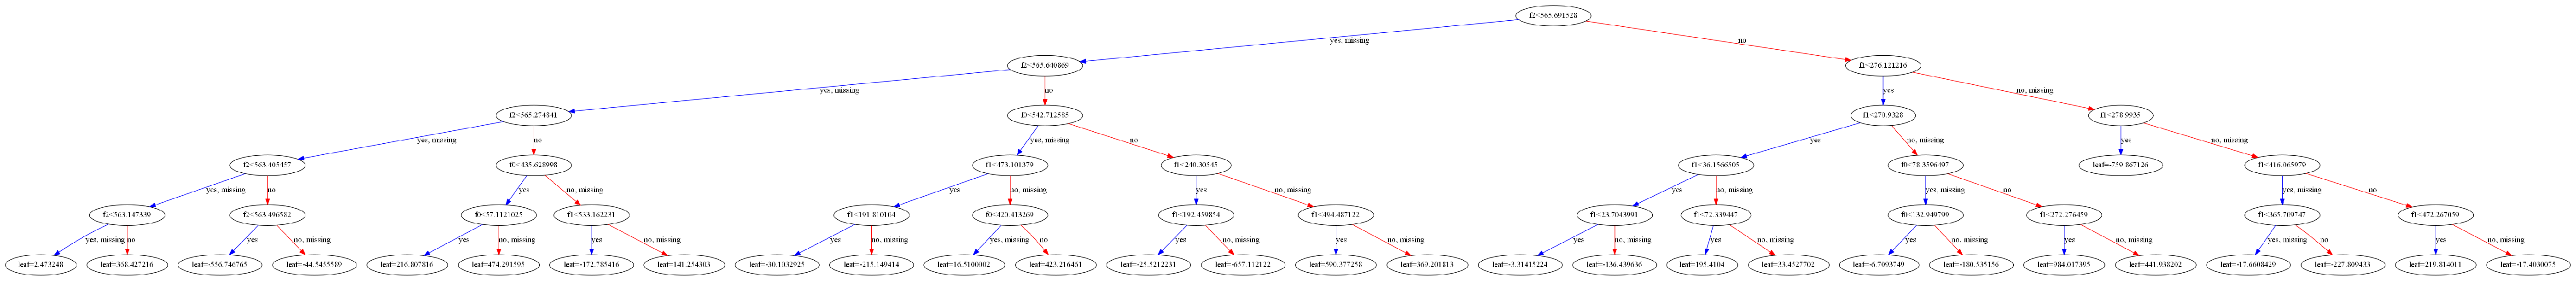

In [7]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#print(os.environ["PATH"])
xg_reg = xgb.XGBRegressor( learning_rate = .1,
                max_depth = 5,  n_estimators = 80,)
xg_reg.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(xg_reg,ax=ax,num_trees=79)
plt.show()

In [169]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
X = df_train[['OverallQual', 'GrLivArea', 'GarageCars']].values.tolist()
Y = df_train['SalePrice'].values.tolist()

In [31]:
import random
X = [[random.randint(1,100)] for i in range(4)]
Y = random.sample(range(1,100),4)
print(X)
print(Y)
mdl = FractBoosting(1)
mdl.fit(X,Y,1,4)
mdl.print_trees()

[[70], [1], [30], [100]]
[4, 7, 48, 13]
itteration 1, mean loss: 16.436747
itteration 2, mean loss: 6.246480
itteration 3, mean loss: 3.415585
0th fractal tree

-----------------

S:

---1.000000
-----------------

T:

---18.000000

-----------------

1th fractal tree

-----------------

S:

---1.000000
-----------------

T:

---X[0] >= 30.000000 
------3.666667
-------11.000000

-----------------

2th fractal tree

-----------------

S:

---X[0] >= 30.000000 
------1.333333
-------0.000000
-----------------

T:

---X[0] >= 70.000000 
-------13.166667
------13.166667

-----------------

3th fractal tree

-----------------

S:

---X[0] >= 70.000000 
------0.900791
------1.519231
-----------------

T:

---X[0] >= 100.000000 
------8.888889
------2.888889

-----------------

